<a href="https://colab.research.google.com/github/Nishant-codex/single_cell_analysis/blob/main/notebooks/Ephys_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import matplotlib 
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
import importlib.util
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
#@title connect gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#@title utils
def loadmat_(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    if ('analyzed' in filename )and ('_CC_' not in filename):
        Data = []
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        try:
            for i in range(len(data)):
                data_ = data[i]
                data_ = _todict(data_) 
                Data.append(_check_keys(data_))
            return Data
        except:
            data_ = data
            data_ = _todict(data_) 
            Data.append(_check_keys(data_))
            return Data
    elif ('analyzed' in filename) and ('_CC_' in filename):
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        data = _todict(data)          
    else:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        data = _todict(data) 
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs nested dictionaries from matobjects
    '''
    dict = {}
    try:
      for strg in matobj._fieldnames:
          elem = matobj.__dict__[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:
              
              dict[strg] = elem
    except:
        for strg in matobj.keys():
          elem = matobj[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:
              
              dict[strg] = elem
    return dict
def join_cond(lis_cond = None):
  path = '/content/gdrive/MyDrive/lists/all_files_new.csv'
  a = pd.read_csv(path)
  cond= np.sort(np.unique(a['condition']))
  temp = []
  if lis_cond ==None:
    return a
  if len(lis_cond)>1:
    for i in lis_cond:
      temp.append(a.groupby('condition').get_group(i))
    new_df = temp[0]
    for j in range(1,len(temp)):
      new_df = pd.concat([new_df,temp[j]])
  else:
    new_df = a.groupby('condition').get_group(lis_cond[0])
  return new_df
#@title impedence functions
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import numpy.matlib 

def makespectrumt(trace, timelen,adcrate):
    # time is the timelength of the sub evaluation 1/time is the freq resolution!
    NFFT  = timelen * adcrate
    
    NFFT2 = int(np.floor(NFFT/2))
    NFFT  = int(2 * NFFT2)
    fas   = np.arange(0,NFFT2-1,(1/timelen)) #(0:(1/timelen):(NFFT2-1)/timelen)'  
    fwdw  = signal.windows.hamming(NFFT)
    start = 0
    last  = len(trace)-NFFT
    count = 0
    pwr = 0
    while start<last:
        endpoint = start + NFFT 
        spoor = trace[start:endpoint]-np.mean(trace[start:endpoint])
        spect = fft(fwdw*spoor,NFFT)/NFFT
        if count == 0: 
          pwr = 2*np.abs(spect[1:NFFT2]) 
        else: 
          pwr = pwr + 2*np.abs(spect[1:NFFT2])
        start = start + NFFT2
        count += 1 
    pwr = pwr/count
    return pwr, fas


def overdracht_wytse(par1, spoordac, spooradc, dacrate, adcrate, par2=None):

    time = par1;
    if par2 is None: 
      nf = 0 
    else: 
      nf = par2
    [pwrdac, fasdac] = makespectrumt(spoordac,time,dacrate)
    [pwradc, fasadc] = makespectrumt(spooradc,time,adcrate)
    lendac = len(pwrdac)
    lenadc = len(pwradc)
    if lendac>lenadc: 
        pwrdac = pwrdac[1:lenadc]
        fas = fasdac[1:lenadc]
    elif lenadc>lendac: 
      pwradc = pwradc[1:lendac]
      fas = fasadc[1:lendac]
    else:
        fas = fasdac
    
    if nf>1:
        pwrdac = signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwrdac)
        pwradc = signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwradc)
    ovr = pwradc/pwrdac
    
    y=ovr  
    return y 


def spectrum_wytse(spoor,rate, par1, par2=None):
    time = par1
    if par2==None: nf = 0
    else: nf = par2
    
    [pwr,fas] = makespectrumt(spoor,time,rate)
    
    if nf>1: pwr = scipy.signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwr)
    x=pwr
    y=fas
    return (x,y)

def  return_stiched_spike_train(data,subthreshold =False,plot=False):

    V= data['membrane_potential']
    I= data['input_current']
    spikes = data['spikeindices']
    if data['input_generation_settings']['tau'] == 250:
        left = 20
        right = 30 
    else:
        left = 20
        right = 20 
    empty_cell = []
    for i in spikes:
        empty_cell.append([np.arange(i-left,i+right)])
        V1 = V[i-left]
        V2 = V[i+right]
        if V1!=V2:
            div = (V2-V1)/(left+right)
            V[i-left:i+right] = np.arange(V1,V2,div)[:left+right] 
        else:
            V[i-left:i+right] = np.ones((1,left+right))*V1        
        
        I1 = I[i-left]
        I2 = I[i+right]       
        if I1!=I2:
            divI = (I2-I1)/(left+right)       

            I[i-left:i+right] = np.arange(I1,I2,divI)[:left+right]    
        else:
            
            I[i-left:i+right] = np.ones((1,left+right))*I1

    V_ = V  
    I_ = I   
    tailored_spikes = np.ndarray.flatten(np.array(empty_cell))    #{cat(2, empty_cell{:})} 
    zero_spikes = np.zeros(np.size(V))
    zero_spikes[tailored_spikes] = True

    if subthreshold == True:
        zero_spikes = ~zero_spikes

    return zero_spikes,V_,I_

# e-PHYS ANALYSIS
1. Mean MP
2. Input resistance 
3. rheobase 
4. AP threshold 
5. AP amplitude 
6. AP width 
7. AHP 
8. ADP
9. First AP latency 
10. UDR 
11. ISI adaptation index 
12. ISI average adaptation 
13. AP amplitude adaptation index 
14. AP amplitude average adaptation index 
15. Max APs 
16. Spike Frequency adaptation 
17. membrane time constant 
18. sag ratio 
19. sag time 
20. sag area 
21. rebound 
22. rebound AP
23. ISI coefficient of variation 
24. ISI fano factor 
25. AP coefficient of variation 
26. AP fano factor
27. burstiness 
 

In [ ]:
#@title all ephys functions
from pandas.core.arrays.numeric import T
from math import isnan
def remove_nan(data):
  ind = ~np.isnan(data)
  data_ = data[ind]
  return data_
def rolling_avg(data):
  start = 0
  length = len(data)//10
  end = len(data)
  finish = False 
  avg = []

  if length ==0 :
    return np.mean(data[start:end])
  else:
    while finish!=True:
      if start+length <end:
        avg.append(np.mean(data[start:start+length]))
        start+=length
      else:
        avg.append(np.mean(data[start:end]))
        finish= True

    return avg


def get_Vm(data):
  Vm = []
  V = data['membrane_potential']
  thr = data['thresholds']
  thr_ind = data['thresholdindices']
  spikes = data['spikeindices']
  ind = ~np.isnan(thr)
  spikes = spikes[ind]
  thr = thr[ind]
  thr_ind = thr_ind[ind]

  for i,j in zip(thr_ind,thr):
    Vm.append(V[int(i)+1:int(i)+50])
  return np.mean(Vm), Vm, np.mean(V)

def get_dvdt(data):
  dvdt_p = []
  dvdt_n = []

  for i in data:
    dv_ = np.diff(i)
    posp = np.where(dv_>0)
    dvdt_ind = np.zeros_like(dv_,dtype=bool)
    dvdt_ind[posp] = True
    posp = dvdt_ind
    posn = ~posp
    dvdt_p.append(np.mean(dv_[posp]))
    dvdt_n.append(np.mean(dv_[posn]))    

  return np.mean(dvdt_p),np.mean(dvdt_n)

def sub_threhold_resistance(data):
  spikes = data['spikeindices']
  V = data['membrane_potential'][:spikes[0]]
  I = data['input_current'][:spikes[0]]
  R = np.mean(V/I)
  return R

def get_thresholds(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(data['thresholds'][ind])

def get_isi(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(np.diff(data['spikeindices'][ind]))

def get_adaptation(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(np.diff(data['thresholds'][ind]))

def get_AP_peak(data):
  max_v = [] 
  for i in data:
    max_v.append(np.max(i))
  return np.mean(max_v) 

def get_AP_peak_adaptation(data):
  max_v = [] 
  for i in data:
    max_v.append(np.max(i))
  return np.mean(np.diff(max_v)) 

def get_AP_width(data):
  thr_ind = data['thresholdindices']
  thr = data['thresholds']
  ind = ~np.isnan(thr_ind)
  spks = data['spikeindices'][ind]
  thr =thr[ind]
  thr_ind=thr_ind[ind]
  V = data['membrane_potential']
  peak = 0
  width = []
  for i,j in zip(spks,thr_ind):
    try:
      spike_wf = V[int(j):int(j)+100]
      # plt.plot(spike_wf)
      left  = V[int(j):i]
      right_ind = i-int(j)
      right = spike_wf[right_ind:]
      half_height = V[i]/2
      left_first = np.where(left<=half_height)
      right_first = np.where(right<=half_height)
      width.append((int(i-j)+right_first[0][0]+1)-(left_first[0][-1]))
    except:
      pass
  return np.mean(width)  

def hyperpolarized_value(data):
  return np.min(data['membrane_potential'])

def first_spike(data):
  return data['thresholdindices'][0]

def get_up_down_ratio(data):
  if len(data['Analysis'])>1 and type(data['Analysis']) ==list:
    avg_up = []
    avg_down = []
    for i in data['Analysis']:
      avg_up.append(i['nup'])
      avg_down.append(i['ndown']) 
  else:
    avg_up = data['Analysis']['nup']
    avg_down = data['Analysis']['ndown']
  return np.nanmean(np.array(avg_up)/np.array(avg_down))

def subthreshold(data,subthreshold =False,plot=False):
    V= data['membrane_potential']
    I= data['input_current']
    spikes = data['spikeindices']
    if data['input_generation_settings']['tau'] == 250:
        left = 20
        right = 30 
    else:
        left = 20
        right = 20 
    empty_cell = []
    for i in spikes:
        empty_cell.append([np.arange(i-left,i+right)])
        V1 = V[i-left]
        V2 = V[i+right]
        if V1!=V2:
            div = (V2-V1)/(left+right)
            V[i-left:i+right] = np.arange(V1,V2,div)[:left+right] 
        else:
            V[i-left:i+right] = np.ones((1,left+right))*V1        
        I1 = I[i-left]
        I2 = I[i+right]       
        if I1!=I2:
            divI = (I2-I1)/(left+right)       
            I[i-left:i+right] = np.arange(I1,I2,divI)[:left+right]    
        else:
            I[i-left:i+right] = np.ones((1,left+right))*I1
    V_ = V  
    I_ = I   
    tailored_spikes = np.ndarray.flatten(np.array(empty_cell))   
    zero_spikes = np.zeros(np.size(V))
    zero_spikes[tailored_spikes] = True
    if subthreshold == True:
        zero_spikes = ~zero_spikes
    return np.mean(V_)

def ISI_adaptation_index(data):
  
  ind = ~np.isnan(data['thresholds'])
  ISI = np.diff(data['spikeindices'][ind])
  len_isi  = len(ISI) 
  fac = len_isi//10
  avgs = []
  for i in range(10):
    avg_ = np.mean(ISI[i*fac:(i+1)*fac])
    avgs.append(avg_)
  factors = []
  for j in range(9):
    factors.append(avgs[j]/avgs[j+1])
  return (np.mean(factors))

def threshold_adaptation_index(data):
  ind = ~np.isnan(data['thresholds'])
  thr = np.diff(data['thresholds'][ind])
  len_thr  = len(thr) 
  fac = len_thr//10
  avgs = []
  for i in range(10):
    avg_ = np.mean(thr[i*fac:(i+1)*fac])
    avgs.append(avg_)
  factors = []
  for j in range(9):
    factors.append(avgs[j]/avgs[j+1])
  return (np.mean(factors))

def PSTH(data):
  V_zero = np.zeros_like(data['membrane_potential'])
  thr = data['thresholdindices']
  ind = ~np.isnan(thr)
  spks = data['spikeindices'][ind]
  V_zero[spks] = 1
  count_spk = []
  start = 0
  width = 50000
  end = len(V_zero)
  run =True
  while run:
    if start+width>end:
      count_spk.append(sum(V_zero[start:end]))
      run=False
    else:
      count_spk.append(sum(V_zero[start:start+width]))
      start=start+width
  return np.mean(count_spk)

def get_inst_fr(data):
  return np.mean( 1/(np.diff(data['spikeindices'])))

def get_firing_rate(data):
  return np.mean(data['firing_rate'])

def spike_frequency_adaptation(data):

  V_zero = np.zeros_like(data['membrane_potential'])
  thr = data['thresholdindices']
  ind = ~np.isnan(thr)
  spks = data['spikeindices'][ind]
  V_zero[spks] = 1
  count_spk = []
  start = 0
  width = 50000
  end = len(V_zero)
  run =True
  while run:
    if start+width>end:
      count_spk.append(sum(V_zero[start:end]))
      run=False
    else:
      count_spk.append(sum(V_zero[start:start+width]))
      start=start+width
  return np.mean(np.diff(count_spk))

def get_impedence(data):
  I_acsf = data['input_current']
  V_acsf = data['membrane_potential']
  spk_acsf,V_acsf,I_acsf = return_stiched_spike_train(data)
  imp = overdracht_wytse(0.01,I_acsf,V_acsf,20001,20001,1)
  return np.mean(imp) 




In [ ]:
#@title compilation of all ephys functions 
def return_all_ephys_dict(cond, experimenter=None):
  def get_ephys_vals(data_i):
    ephys_data = []

    try:
      Vm_avg,Vm,_ = get_Vm(data_i)
      dvdt_p,dvdt_n = get_dvdt(Vm)
      resistance =sub_threhold_resistance(data_i)
      thr = get_thresholds(data_i)
      adaptation = get_adaptation(data_i)
      isi = get_isi(data_i)
      peak = get_AP_peak(Vm)
      peak_adaptation = get_AP_peak_adaptation(Vm)
      ap_width = get_AP_width(data_i)
      hyp_value = hyperpolarized_value(data_i)
      fist_spike = first_spike(data_i)
      up_down_ratio = get_up_down_ratio(data_i)
      isi_adaptation = ISI_adaptation_index(data_i)
      thr_adp_ind = threshold_adaptation_index(data_i)
      psth = PSTH(data_i)
      int_fr = get_inst_fr(data_i)
      fr = get_firing_rate(data_i)
      sub_thr  = subthreshold(data_i)
      spk_fr_adp = spike_frequency_adaptation(data_i)
      imp  = get_impedence(data_i)
      ephys_data.append([Vm_avg,
                                dvdt_p,
                                dvdt_n,
                                resistance,
                                thr,
                                adaptation,
                                isi,
                                peak,
                                peak_adaptation,
                                ap_width,
                                hyp_value,
                                fist_spike,
                                up_down_ratio,
                                isi_adaptation,
                                thr_adp_ind,
                                psth,
                                int_fr,
                                fr,
                                sub_thr,
                                spk_fr_adp,
                                imp])
    except:
      ephys_data.append([Vm_avg,
                                dvdt_p,
                                dvdt_n,
                                resistance,
                                thr,
                                adaptation,
                                isi,
                                peak,
                                peak_adaptation,
                                ap_width,
                                hyp_value,
                                fist_spike,
                                up_down_ratio,
                                isi_adaptation,
                                thr_adp_ind,
                                psth,
                                int_fr,
                                fr,
                                sub_thr,
                                spk_fr_adp,
                                imp])
  
    return ephys_data
  all_ephys_with_cond = {}
  path_i = '/content/gdrive/MyDrive/Analyzed/'
  if type(cond) != list:
    raise ValueError('condition should be a list even if a single value is provided')
  cond_i = cond #['ACSF','aCSF']
  new_a = join_cond(cond_i)
  if experimenter !=None:
    new_a = new_a.groupby('experimenter').get_group(experimenter)
  new_a_inh = new_a.groupby('tau').get_group(50)
  new_a_exc = new_a.groupby('tau').get_group(250)

  exp_name_inh = np.array(new_a_inh['experimentname'])
  trials_inh = np.array(new_a_inh['trialnr'])
  exp_name_exc = np.array(new_a_exc['experimentname'])
  trials_exc = np.array(new_a_exc['trialnr'])
  all_ephys_data_inh = []
  all_ephys_data_exc = []
  all_ephys_data_inh_acsf = []
  all_ephys_data_exc_acsf = []
  problem_cell = []
  count = 0

  for i,j in zip(exp_name_exc,trials_exc-1):
      # try:
        count+=1
        print(count)
        try:
          data  = loadmat_(path_i + i + '_analyzed.mat')
        except:
          data  = loadmat_(path_i + 'Copy of ' + i + '_analyzed.mat')
        for instance in data:
          if instance['input_generation_settings']['condition'] in ['ACSF','aCSF']:
            all_ephys_data_exc_acsf.append(get_ephys_vals(instance))          
        try:
          data_i = data[j]
        except:
          if len(data)==1:
            data_i = data
          else:
            problem_cell.append(i)
            pass
        print(i, data_i['input_generation_settings']['condition'])
        all_ephys_data_exc.append(get_ephys_vals(data_i))
      # except:
      #   print('except')
      #   pass


  for i,j in zip(exp_name_inh,trials_inh-1):
      # try:
        count+=1
        try:
          data  = loadmat_(path_i + i + '_analyzed.mat')
        except:
          data  = loadmat_(path_i + 'Copy of ' + i + '_analyzed.mat')
        for instance in data:
          if instance['input_generation_settings']['condition'] in ['ACSF','aCSF']:
            all_ephys_data_inh_acsf.append(get_ephys_vals(instance))
        try:
          data_i = data[j]
        except:
          if len(data)==1:
            data_i = data
          else:
            problem_cell.append(i)
            pass
        print(i, data_i['input_generation_settings']['condition'])
        all_ephys_data_inh.append(get_ephys_vals(data_i))
      # except:
      #   pass  


  all_ephys_with_cond['exc'] = all_ephys_data_exc     
  all_ephys_with_cond['inh'] = all_ephys_data_inh     
  all_ephys_with_cond['exc_acsf'] = all_ephys_data_exc_acsf     
  all_ephys_with_cond['inh_acsf'] = all_ephys_data_inh_acsf       
  all_ephys_with_cond['cond'] = cond
  return all_ephys_with_cond

In [ ]:
#@title (DO NOT RUN!) run the analysis for conditions 
sag = return_all_ephys_dict(['sag'])
dop = return_all_ephys_dict(['D1', 'DOPA', 'DOPAMINE', 'Dop'])

In [ ]:
# @title (DO NOT RUN!) Save data files with condition 
with open('/content/gdrive/MyDrive/all_ephys_dop.p', 'wb') as fh:
  pickle.dump(dop, fh) 
with open('/content/gdrive/MyDrive/all_ephys_sag.p', 'wb') as fh:
  pickle.dump(sag, fh)   

In [ ]:
#@title load data with conditions
data_dop = pickle.load(open('/content/gdrive/MyDrive/all_ephys_dop.p','rb'))
data_sag = pickle.load(open('/content/gdrive/MyDrive/all_ephys_sag.p','rb'))

In [ ]:
#@title (DO NOT RUN!) save acsf data files 
with open('/content/gdrive/MyDrive/all_ephys_exc_NC_acsf_imp.p', 'wb') as fh:
  pickle.dump({'all':all_ephys_data_exc}, fh)    
with open('/content/gdrive/MyDrive/all_ephys_inh_NC_acsf_imp.p', 'wb') as fh:
  pickle.dump({'all':all_ephys_data_inh}, fh)       

In [ ]:
#@title load data files with impedance acsf
data_exc = pickle.load(open('/content/gdrive/MyDrive/all_ephys_exc_NC_acsf_imp.p','rb'))
data_inh = pickle.load(open('/content/gdrive/MyDrive/all_ephys_inh_NC_acsf_imp.p','rb'))

In [ ]:
#@title utilities
def remove_nans_and_infs(data):
  nan = np.isnan(data)
  nan = np.where(nan==True)
  nan_rem = np.delete(data, [nan[0]],axis=0)
  nan = np.isnan(nan_rem)
  nan = np.where(nan==True)
  data = nan_rem

  inf = np.isinf(data)
  inf = np.where(inf==True)
  inf_rem = np.delete(data, [inf[0]],axis=0)
  inf = np.isnan(inf_rem)
  inf = np.where(inf==True)
  data = inf_rem
  return data

def takeRandomSamples(data,mask_level=1.0):
  if mask_level>1 or mask_level<0:
    raise ValueError('Value must a float between 0 and 1')
  data_ = data
  zero_vals = np.zeros_like(data_)
  rand_vals = np.random.rand(zero_vals.shape[0],zero_vals.shape[1])
  ind = np.where(rand_vals<mask_level )
  zero_vals[ind] = 1
  return zero_vals

def shuffle_prams(data,col,all=False):
  rng = np.random.default_rng()

  data_o = data
  col_shuffled = data[:,col]
  if all:
    col_shuffled = data
    rng.shuffle(col_shuffled)
    data_o=col_shuffled      
    return data_o
     
  rng.shuffle(col_shuffled)
  data_o[:,col]  = col_shuffled
  return data_o  


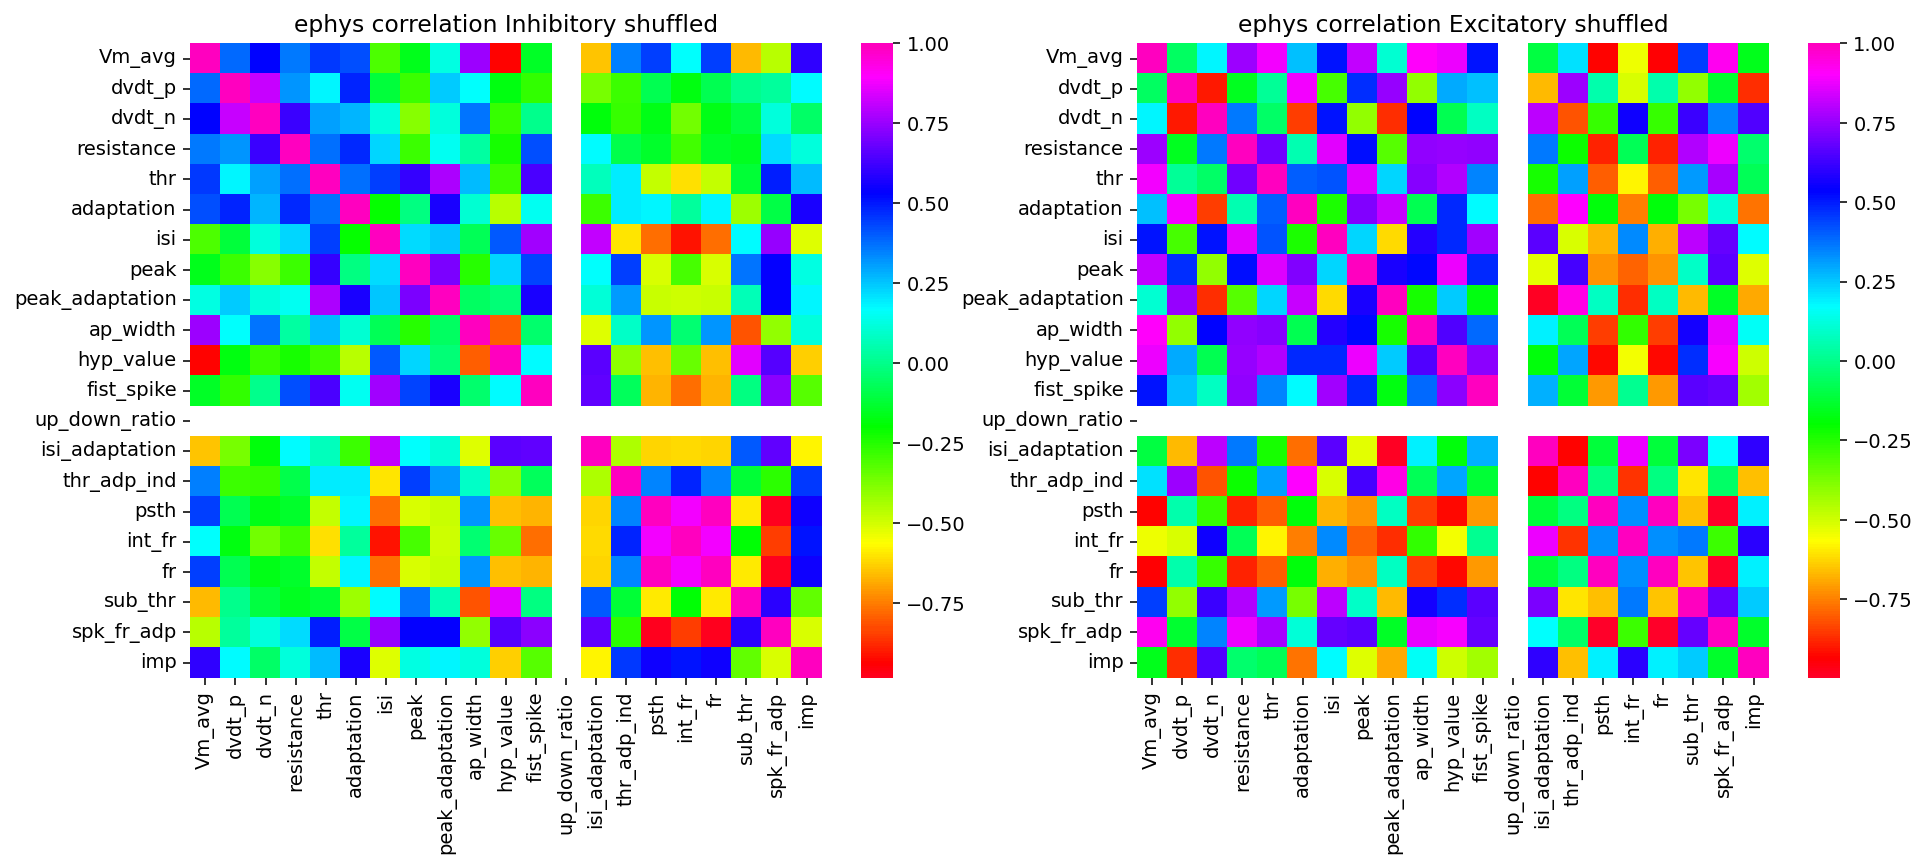

In [ ]:
#@title correlation plot function
def plot_correlation_plot(data_exc, data_inh,shuffle=False,all_cols=False):
  columns=['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation','isi','peak',
          'peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
          'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']
  min_size = min(np.array(data_exc).shape[0],np.array(data_inh).shape[0])
  if all_cols:
    for i in range(len(columns)):
      fig,ax =plt.subplots(1,2,figsize=[16,6])
      fig.set_dpi(140)

      df = pd.DataFrame(columns=columns)
     
      data_shuffled_inh = shuffle_prams(data_inh,i)
      df[columns] = data_shuffled_inh[:min_size,]
      matrix = df.corr()
      sns.heatmap(matrix,ax=ax[0],xticklabels=columns,yticklabels=columns,cmap='gist_rainbow',center=.0)
      ax[0].set_title('ephys correlation Inhibitory '+columns[i]+' shuffled')

      df = pd.DataFrame(columns=columns)
      data_shuffled_exc = shuffle_prams(data_exc,i)
      df[columns] = data_shuffled_exc[:min_size,]
      matrix = df.corr()
      sns.heatmap(matrix,ax=ax[1],cmap='gist_rainbow',xticklabels=columns,yticklabels=columns,center=.0)
      ax[1].set_title('ephys correlation Excitatory '+columns[i]+' shuffled')
      plt.show()
  else:
    fig,ax =plt.subplots(1,2,figsize=[16,6])
    fig.set_dpi(140)

    df = pd.DataFrame(columns=columns)
    if shuffle:
      data_shuffled_inh = shuffle_prams(data_inh,0,all=True)
      df[columns] = data_shuffled_inh[:min_size,]
    else:
      df[columns] = data_inh[:min_size,]
    matrix = df.corr()
    sns.heatmap(matrix,ax=ax[0],xticklabels=columns,yticklabels=columns,cmap='gist_rainbow',center=.0)
    ax[0].set_title('ephys correlation Inhibitory shuffled')

    df = pd.DataFrame(columns=columns)
    
    if shuffle:
      data_shuffled_exc = shuffle_prams(data_exc,0,all=True)
      df[columns] = data_shuffled_exc[:min_size,]
    else:
      df[columns] = data_exc[:min_size,]
    matrix = df.corr()
    sns.heatmap(matrix,ax=ax[1],cmap='gist_rainbow',xticklabels=columns,yticklabels=columns,center=.0)
    ax[1].set_title('ephys correlation Excitatory shuffled')
    plt.show()    
plot_correlation_plot(remove_nans_and_infs(np.squeeze(data_sag['exc'])),remove_nans_and_infs(np.squeeze(data_sag['inh'])))


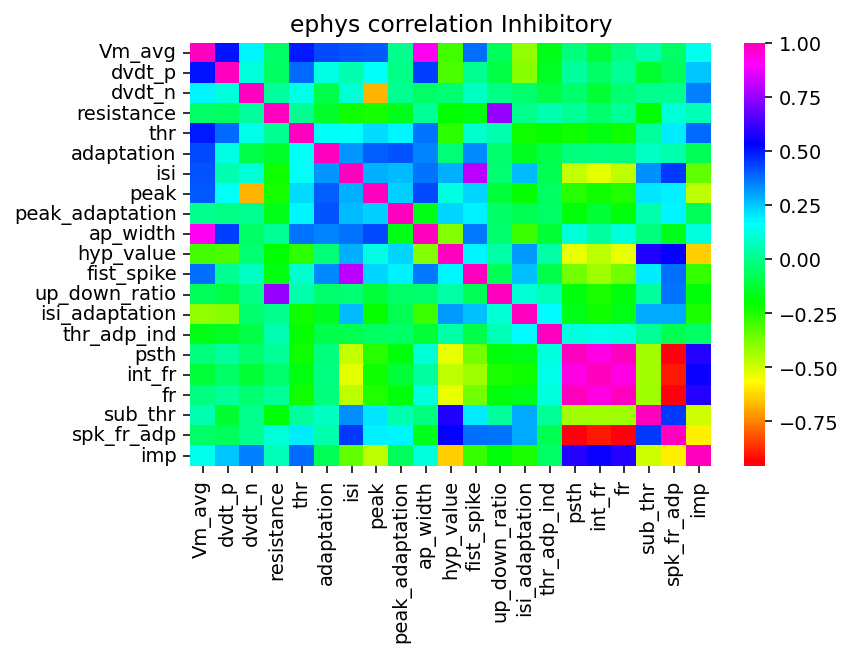

Text(0.5, 1.0, 'ephys correlation Excitatory')

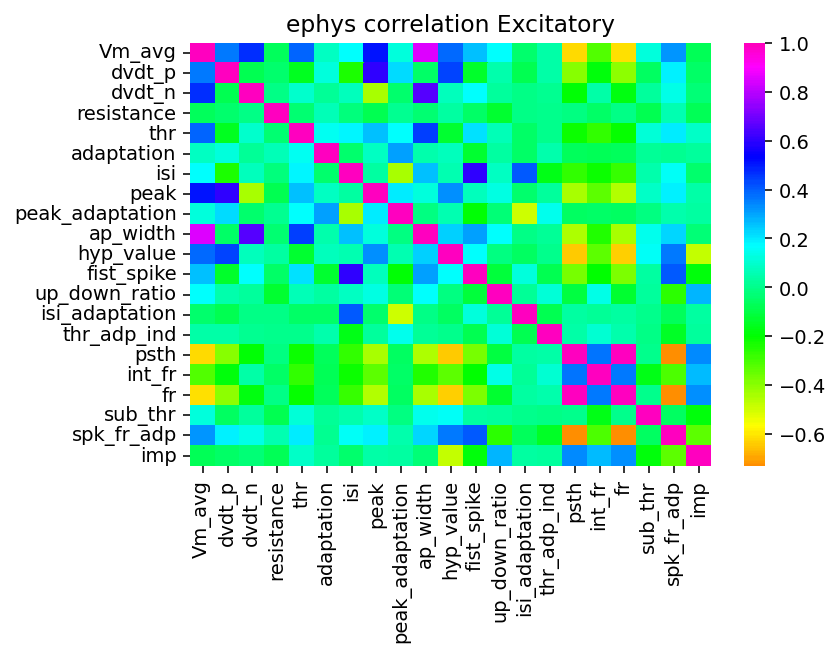

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, normalize
scalar_inh = StandardScaler()
scalar_exc = StandardScaler()

fig,ax =plt.subplots()
fig.set_dpi(140)
min_size = min(data_inh['all'].shape[0],data_exc['all'].shape[0])
columns=['Vm_avg','dvdt_p','dvdt_n',
'resistance','thr','adaptation','isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike',
'up_down_ratio','isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']
df = pd.DataFrame(columns=columns)
cols= df.columns 
df[cols] = normalize(scalar_inh.fit_transform(np.array(data_inh['all'][:min_size,])))
matrix = df.corr()
sns.heatmap(matrix,ax=ax,xticklabels=cols,yticklabels=cols,cmap='gist_rainbow',center=.0,linecolor='black')
plt.title('ephys correlation Inhibitory')
plt.show()
fig,ax =plt.subplots()
fig.set_dpi(140)
df = pd.DataFrame(columns=columns)
cols= df.columns 
df[cols] = normalize(scalar_exc.fit_transform(np.array(data_exc['all'])))
matrix = df.corr()
sns.heatmap(matrix,ax=ax,cmap='gist_rainbow',xticklabels=cols,yticklabels=cols,center=.0)
plt.title('ephys correlation Excitatory')


Text(0.5, 1.0, 'ephys correlation Exc - Inh')

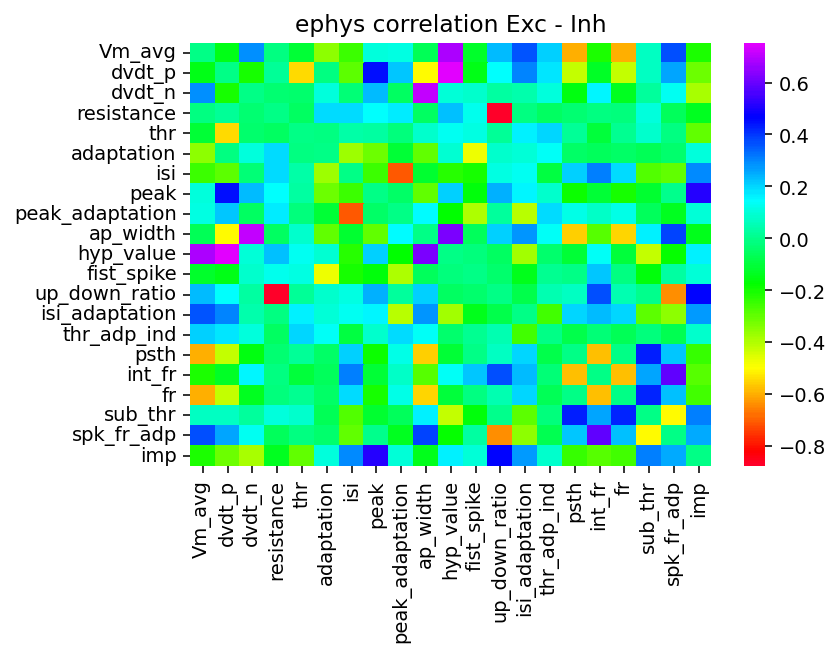

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, normalize
scalar = StandardScaler()
fig,ax =plt.subplots()

fig.set_dpi(140)
df_exc = pd.DataFrame(columns=columns)
cols= df_exc.columns 
df_inh = pd.DataFrame(columns=columns)
cols= df_exc.columns 
min_v = min(np.array(data_exc['all']).shape[0],np.array(data_inh['all']).shape[0])
df_exc[cols] = normalize(scalar.fit_transform(np.array(data_exc['all'])))
matrix_exc = df_exc.corr()
df_inh[cols] = normalize(scalar.fit_transform(np.array(data_inh['all'])[:min_v,])) 
matrix_inh = df_inh.corr()
sns.heatmap(matrix_exc-matrix_inh,ax=ax,cmap='gist_rainbow',xticklabels=cols,yticklabels=cols,center=.0)
plt.title('ephys correlation Exc - Inh')

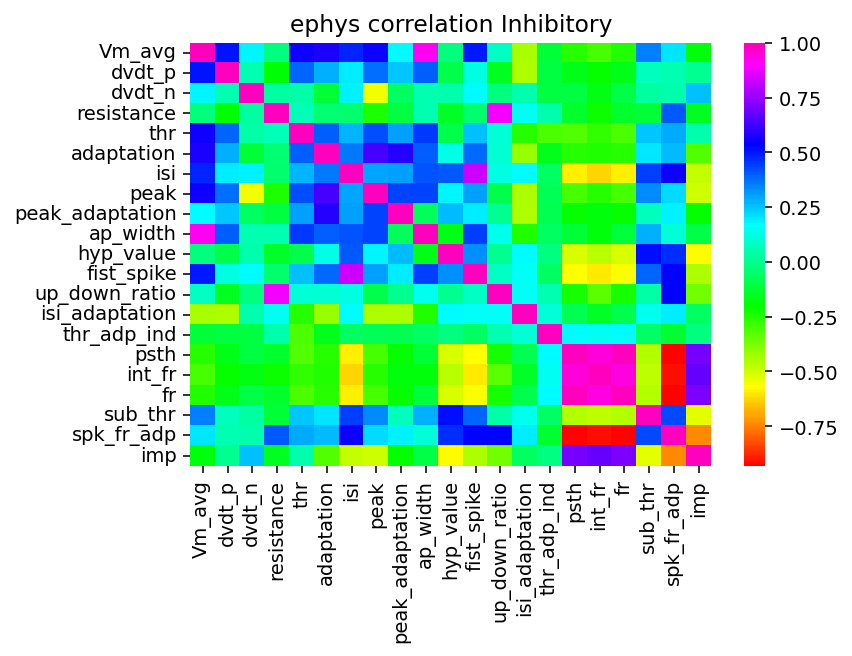

Text(0.5, 1.0, 'ephys correlation Excitatory')

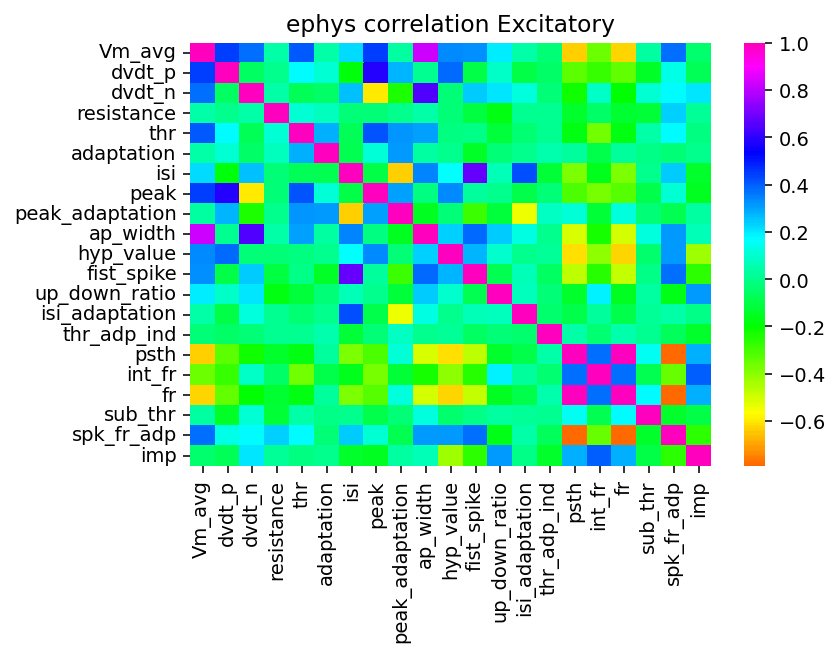

In [ ]:
#@title Correlation matrice for aCSF ephys
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import Normalizer
scalar = StandardScaler()
data_inh_pca = scalar.fit_transform(data_inh['all'])
data_exc_pca = scalar.fit_transform(data_exc['all'])


fig,ax =plt.subplots()
fig.set_dpi(140)
df = pd.DataFrame(columns=['Vm_avg',
'dvdt_p',
'dvdt_n',
'resistance',
'thr',
'adaptation',
'isi',
'peak',
'peak_adaptation',
'ap_width',
'hyp_value',
'fist_spike',
'up_down_ratio',
'isi_adaptation',
'thr_adp_ind',
'psth',
'int_fr',
'fr',
'sub_thr',
'spk_fr_adp',
'imp'])

cols= df.columns 
df[cols] = np.array(data_inh_pca)
matrix = df.corr()
sns.heatmap(matrix,ax=ax,xticklabels=cols,yticklabels=cols,cmap='gist_rainbow',center=.0)
plt.title('ephys correlation Inhibitory')
plt.show()
fig,ax =plt.subplots()
fig.set_dpi(140)
df = pd.DataFrame(columns=['Vm_avg',
'dvdt_p',
'dvdt_n',
'resistance',
'thr',
'adaptation',
'isi',
'peak',
'peak_adaptation',
'ap_width',
'hyp_value',
'fist_spike',
'up_down_ratio',
'isi_adaptation',
'thr_adp_ind',
'psth',
'int_fr',
'fr',
'sub_thr',
'spk_fr_adp',
'imp'])
cols= df.columns 
df[cols] = np.array(data_exc_pca)
matrix = df.corr()
sns.heatmap(matrix,ax=ax,cmap='gist_rainbow',xticklabels=cols,yticklabels=cols,center=.0)
plt.title('ephys correlation Excitatory')
# df

#PCA

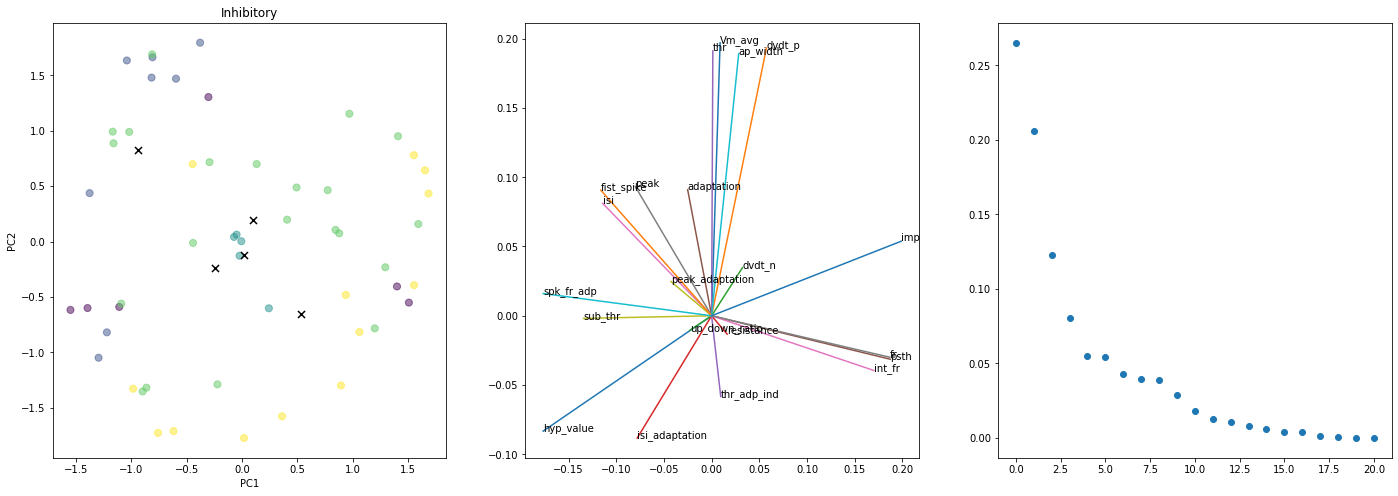

0.6248777657875265


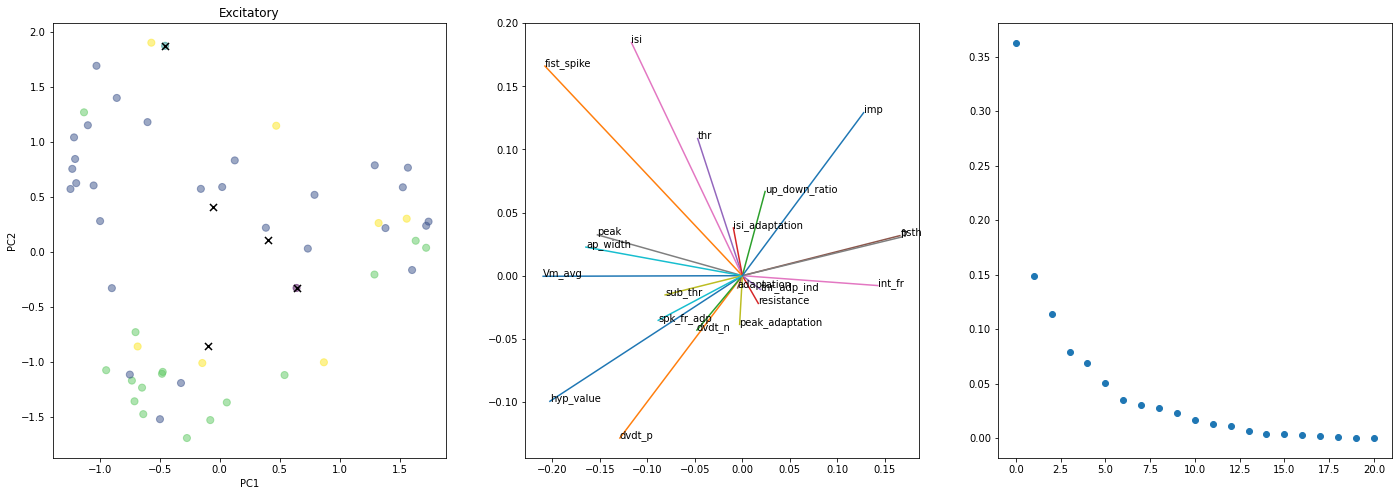

In [ ]:
#@title plot PCA all aCSF
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler, normalize
import plotly.express as px
import plotly.graph_objects as go


features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

min_size = min(data_inh['all'].shape[0],data_exc['all'].shape[0])

# def normalize(data):
#   return (data-np.mean(data))/np.std(data)

scalar_inh = StandardScaler()
scalar_exc = StandardScaler()

data_inh_pca = scalar_inh.fit_transform(data_inh['all'])
data_inh_pca = normalize(data_inh_pca) #normalize(data_inh['all'])
data_exc_pca = scalar_exc.fit_transform(data_exc['all'])
data_exc_pca = normalize(data_exc_pca) #normalize(data_exc['all'])

pca_x = PCA(whiten=True,random_state=40)

fig, ax = plt.subplots(1,3,figsize=[24,8])

# Project the data in 2D

reduced_data_inh = pca_x.fit_transform(data_inh_pca[:min_size,:])
exp_var_inh = pca_x.explained_variance_ratio_
loadings = pca_x.components_.T * np.sqrt(pca_x.explained_variance_)

n_components = 3

kmeans = KMeans(n_clusters=5).fit(reduced_data_inh)
centroids_inh = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)

ax[0].scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c=label, s=50, alpha=0.5,marker = 'o')
ax[0].scatter(centroids_inh[:, 0], centroids_inh[:, 1],c='black', s=50,marker = 'x')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('Inhibitory')

for i, feature in enumerate(features):
  # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.5:
    ax[1].plot([0,loadings[i, 0]],[0,loadings[i, 1]])
    ax[1].annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])
ax[2].scatter(np.arange(len(exp_var_inh)),exp_var_inh)

plt.show()

fig, ax = plt.subplots(1,3,figsize=[24,8])

pca_x_exc = PCA(whiten=True,random_state=40)
# Project the data in 2D
reduced_data_exc = pca_x_exc.fit_transform(data_exc_pca[:min_size,:])
exp_var_exc = pca_x_exc.explained_variance_ratio_
print(sum(exp_var_exc[:3]))
loadings = pca_x_exc.components_.T * np.sqrt(pca_x_exc.explained_variance_)
n_components = 2

kmeans = KMeans(n_clusters=5).fit(reduced_data_exc)
centroids_exc = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)

ax[0].Projection ='3d'                   
ax[0].scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c=label, s=50, alpha=0.5,marker = 'o')
ax[0].scatter(centroids_exc[:, 0], centroids_exc[:, 1],c='black', s=50,marker = 'x')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('Excitatory')

for i, feature in enumerate(features):
  # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.4:
    ax[1].plot([0,loadings[i, 0]],[0,loadings[i, 1]])
    ax[1].annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])


ax[2].scatter(np.arange(len(exp_var_exc)),exp_var_exc)
plt.show()

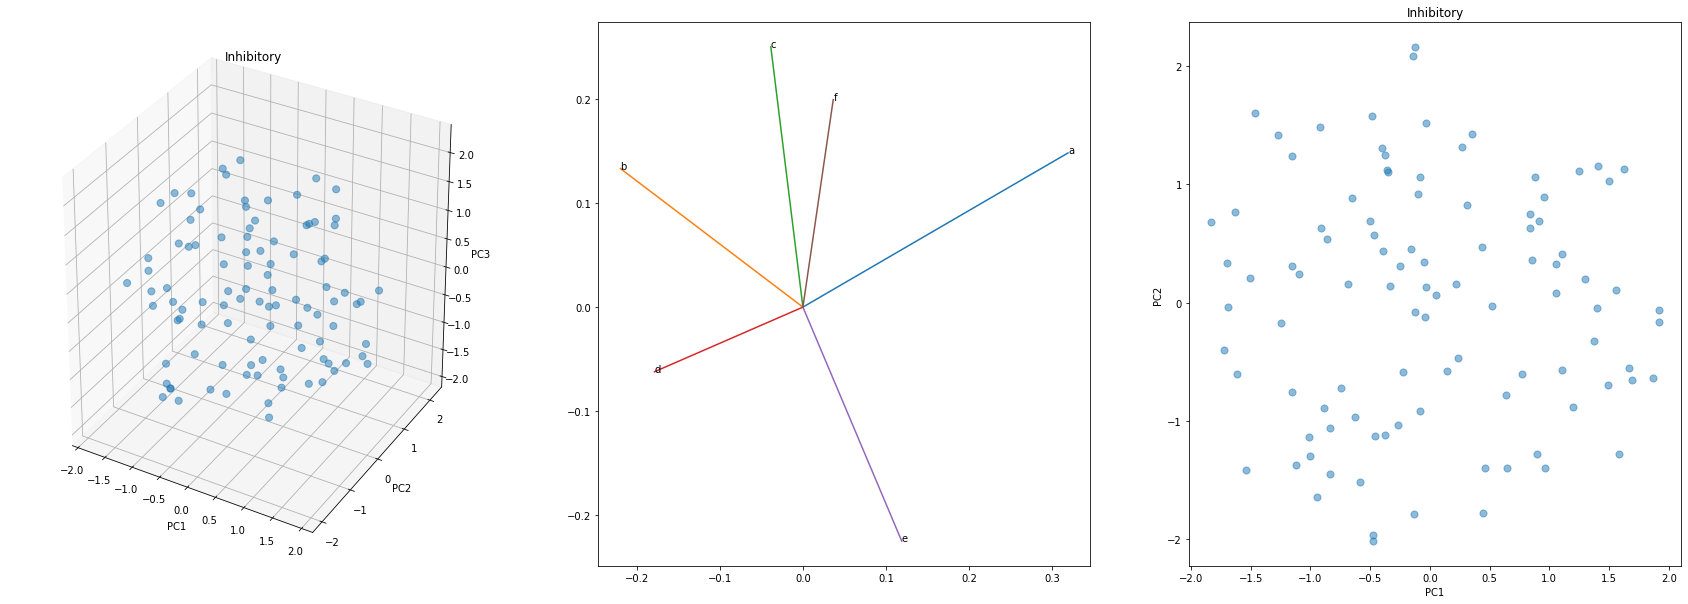

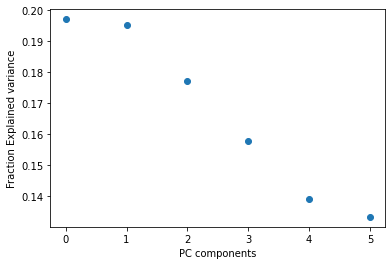

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import manifold, datasets
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler, normalize

#pass your data as ndarray
#features should be a list of labels from your data


def plot_pca_with_loadings(data,features):

  features = features
  scalar = StandardScaler()

  data = scalar.fit_transform(data)
  data = normalize(data) 

  pca_x = PCA(whiten=True,random_state=40)
  # Project the data in 2D
  reduced_data = pca_x.fit_transform(data)
  exp_var = pca_x.explained_variance_ratio_
  loadings = pca_x.components_.T * np.sqrt(pca_x.explained_variance_)
  n_components = 2


  fig = plt.figure(figsize=[30,10])

  ax3d = fig.add_subplot(1,3,1,projection='3d',)
  axloadings = fig.add_subplot(1,3,2)
  ax2d = fig.add_subplot(1,3,3)

  ax2d.scatter(reduced_data[:,0], reduced_data[:,1],s=50, alpha=0.5,marker = 'o')
  ax2d.set_xlabel('PC1')
  ax2d.set_ylabel('PC2')
  ax2d.set_title('Inhibitory')


  for i, feature in enumerate(features):
    # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.5:
      axloadings.plot([0,loadings[i, 0]],[0,loadings[i, 1]])
      axloadings.annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])


  ax3d.scatter(reduced_data[:,0], reduced_data[:,1],reduced_data[:,2], s=50,  alpha=0.5,marker = 'o')
  ax3d.set_xlabel('PC1')
  ax3d.set_ylabel('PC2')
  ax3d.set_zlabel('PC3')
  ax3d.set_title('Inhibitory')
  plt.show()
  plt.scatter(np.arange(len(exp_var)),exp_var)
  plt.xlabel('PC components')
  plt.ylabel('Fraction Explained variance')
  plt.show()

#Example 
features = ['a','b','c','d','e','f']
rand_df = pd.DataFrame(data=np.random.randn(100,6),columns=features)
plot_pca_with_loadings(rand_df,features)

Text(0.5, 0.92, 'Excitatory')

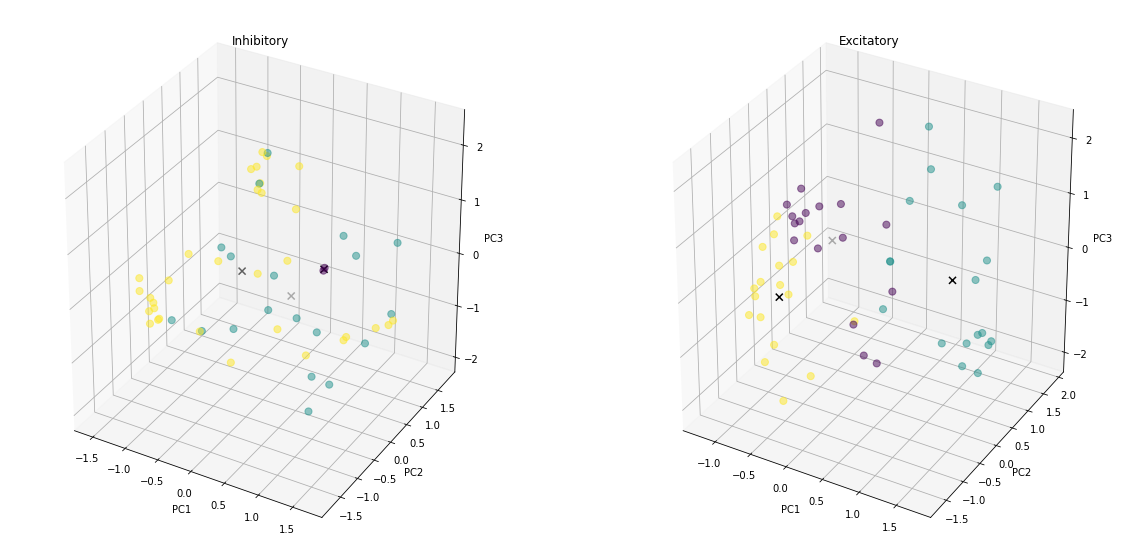

In [ ]:
#@title PCA 3D
scalar_inh = StandardScaler()
scalar_exc = StandardScaler()
size_inh = data_inh['all'].shape
size_exc = data_exc['all'].shape
min_size = min(size_inh[0],size_exc[0])

data_inh_pca = scalar_inh.fit_transform(data_inh['all'])
data_inh_pca = normalize(data_inh_pca)
data_exc_pca = scalar_exc.fit_transform(data_exc['all'])
data_exc_pca = normalize(data_exc_pca)

pca_x = PCA(whiten=True)

fig = plt.figure(figsize=[20,10])

ax = fig.add_subplot(1, 2, 1, projection='3d')

reduced_data_inh = pca_x.fit_transform(data_inh_pca[:min_size,:])
exp_var_inh = pca_x.explained_variance_ratio_

n_components = 3
N_clusters_inh = 3 #@param
kmeans = KMeans(n_clusters=N_clusters_inh).fit(reduced_data_inh)
centroids_inh = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)

ax.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1],reduced_data_inh[:,2], c=label, s=50, alpha=0.5,marker = 'o')
ax.scatter(centroids_inh[:, 0], centroids_inh[:, 1],centroids_inh[:, 2],c='black', s=50,marker = 'x')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_title('Inhibitory')


pca_x = PCA(n_components,whiten=True)
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Project the data in 3D
reduced_data_exc = pca_x.fit_transform(data_exc_pca[:min_size,:])
exp_var_exc = pca_x.explained_variance_ratio_

n_components = 3
N_clusters_exc = 3 #@param
kmeans = KMeans(n_clusters=N_clusters_exc).fit(reduced_data_exc)
centroids_exc = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)

ax.scatter(reduced_data_exc[:,0], reduced_data_exc[:,1],reduced_data_exc[:,2], c=label, s=50, alpha=0.5,marker = 'o')
ax.scatter(centroids_exc[:, 0], centroids_exc[:, 1],centroids_exc[:, 2],c='black', s=50,marker = 'x')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_title('Excitatory')

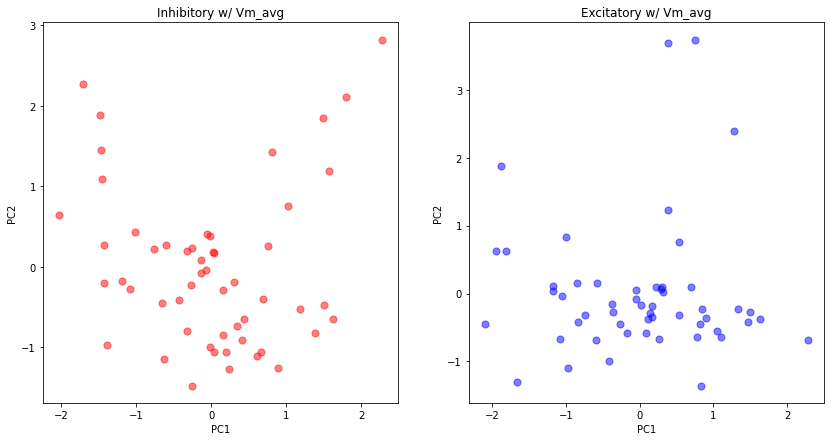

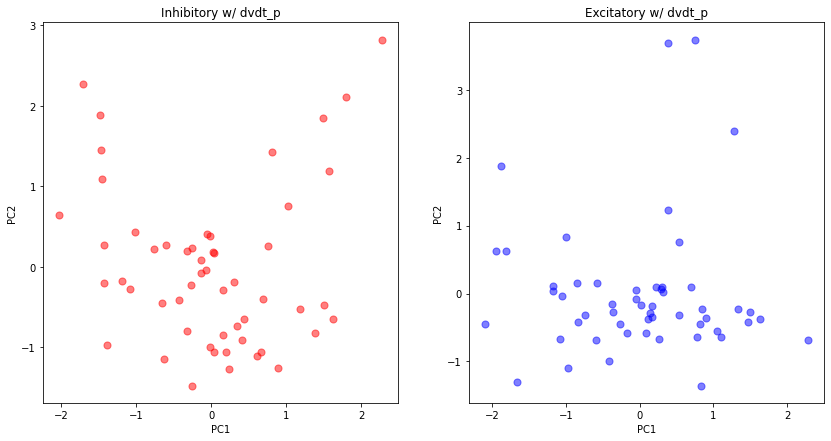

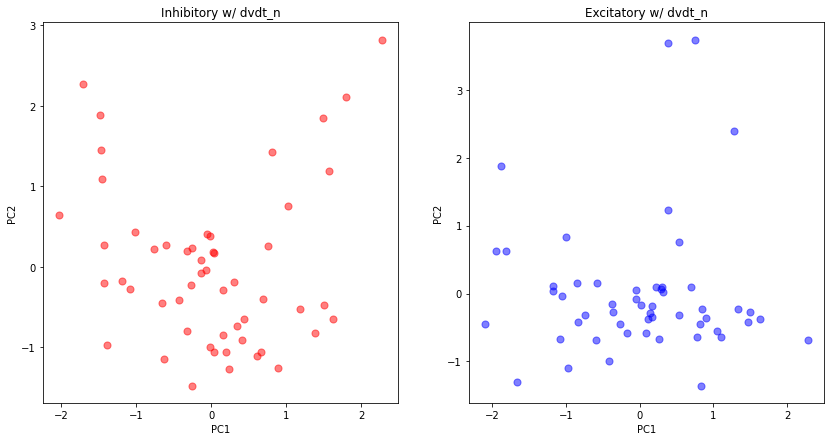

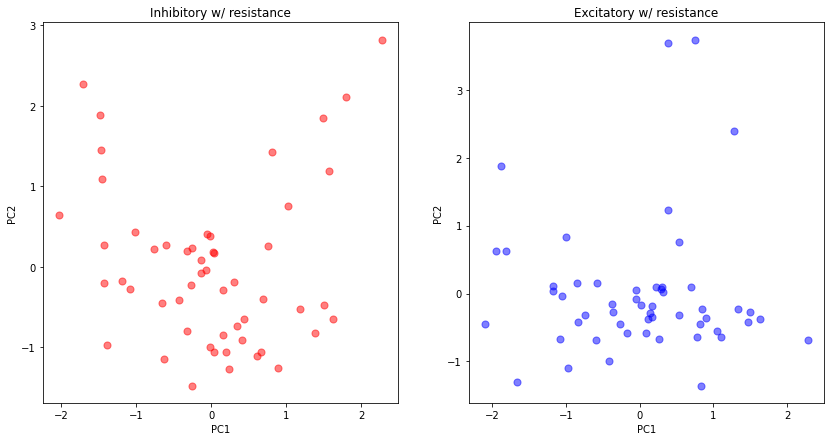

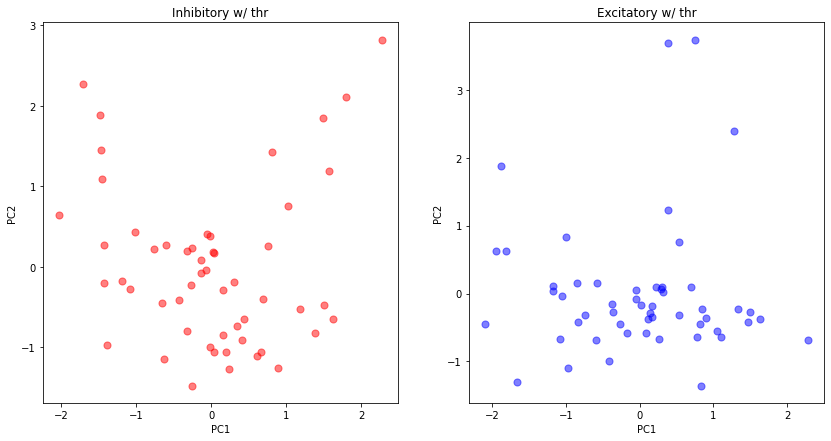

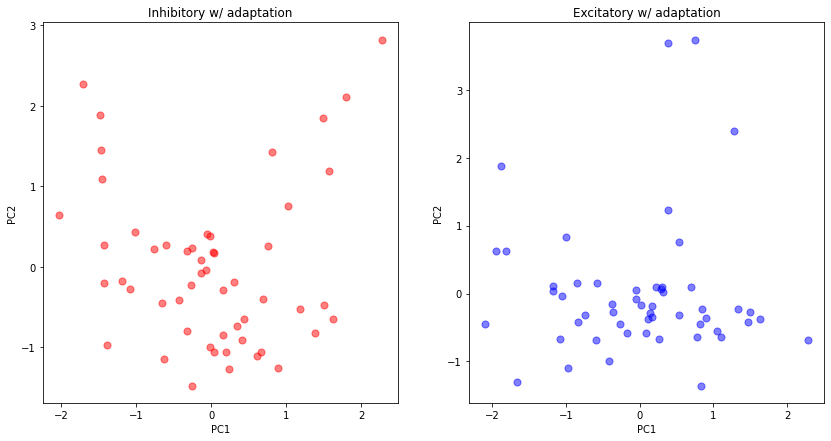

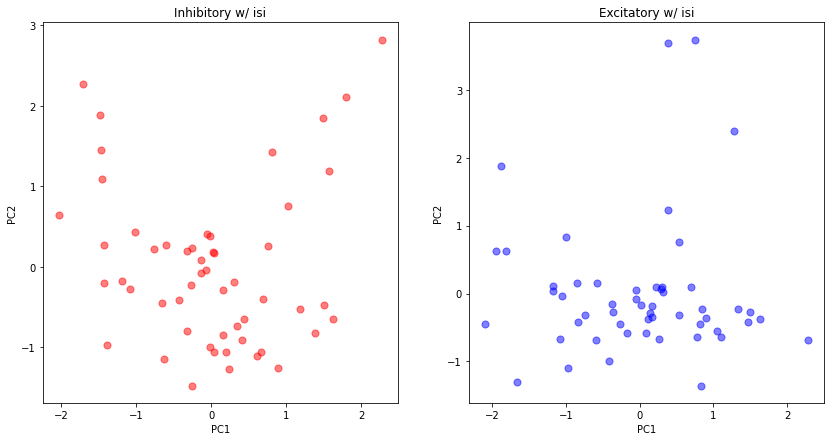

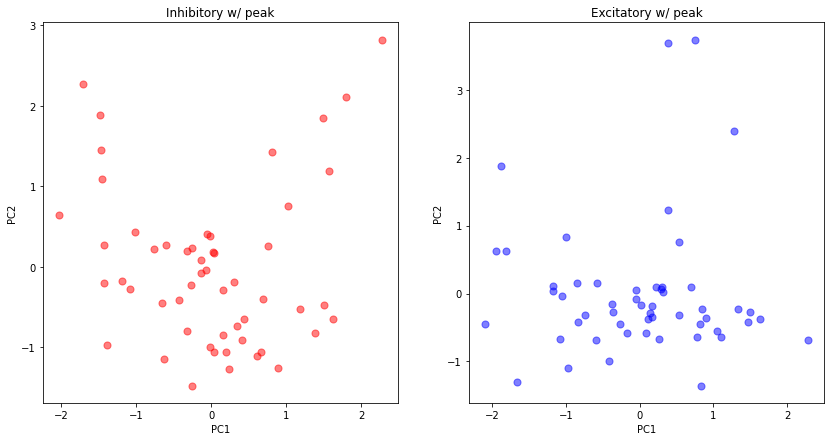

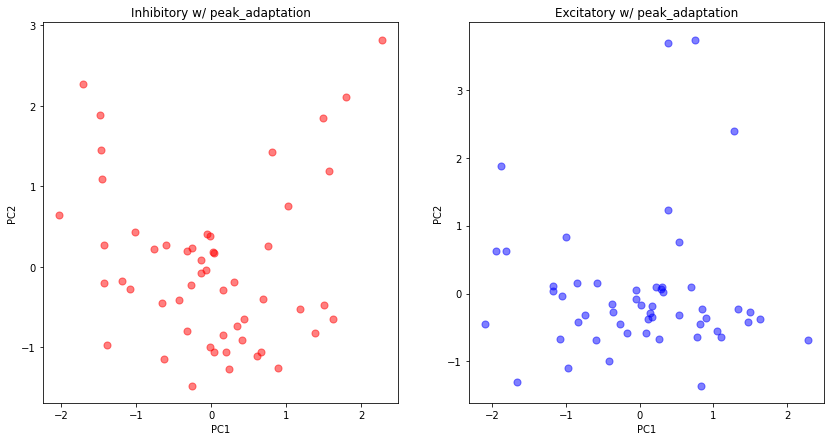

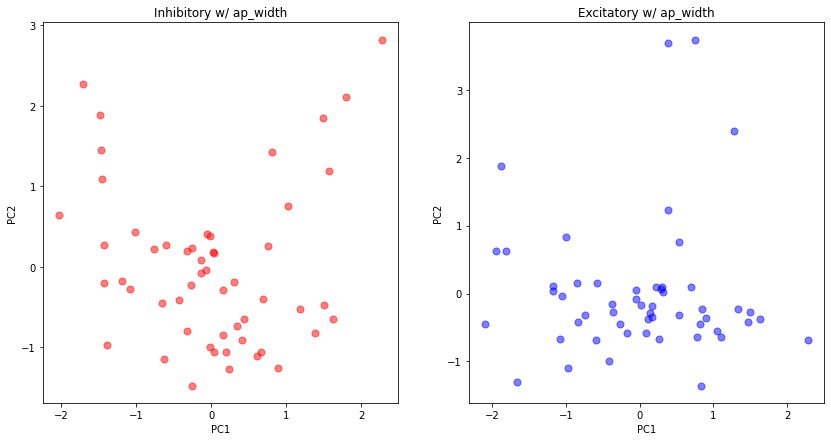

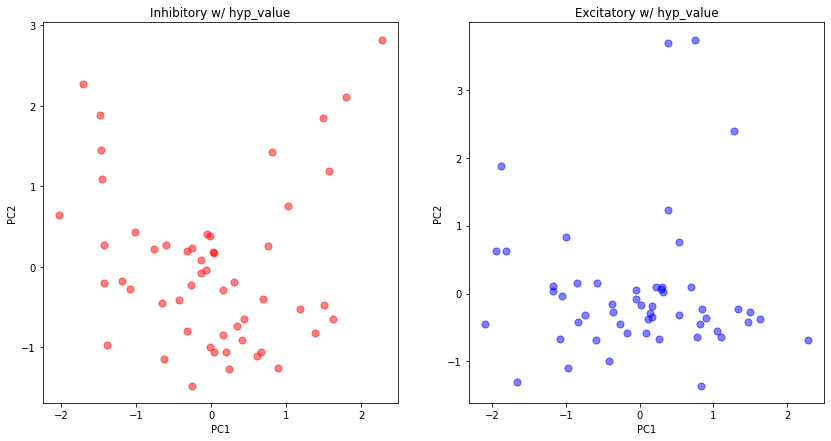

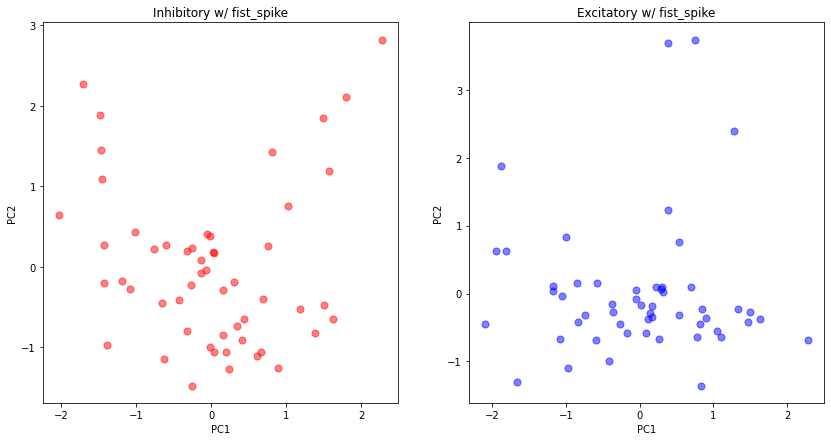

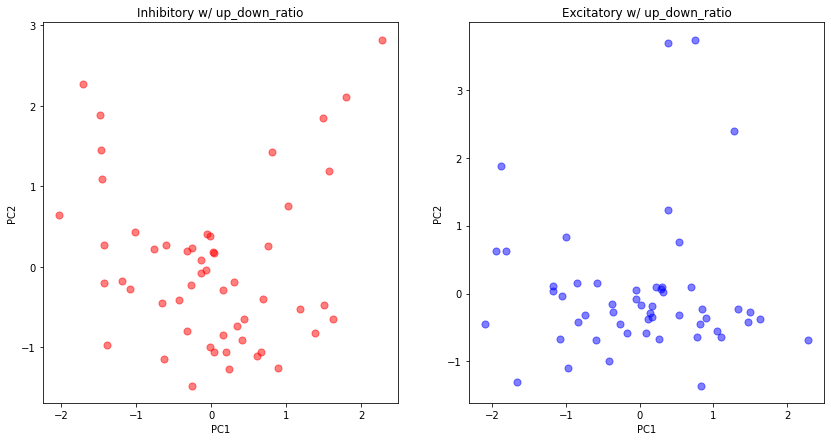

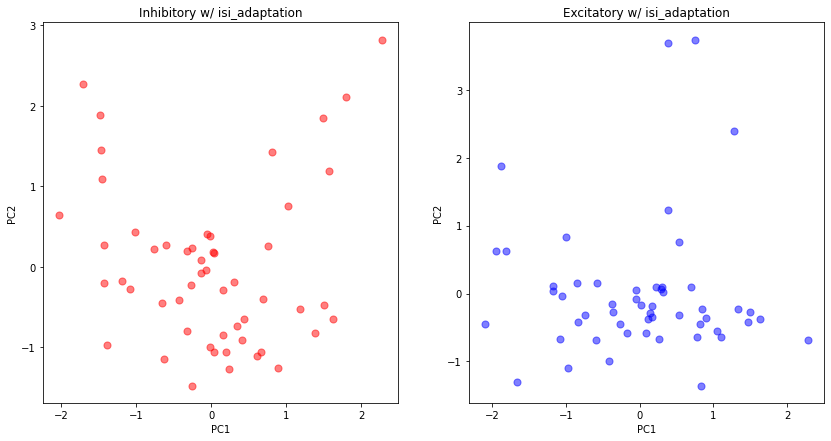

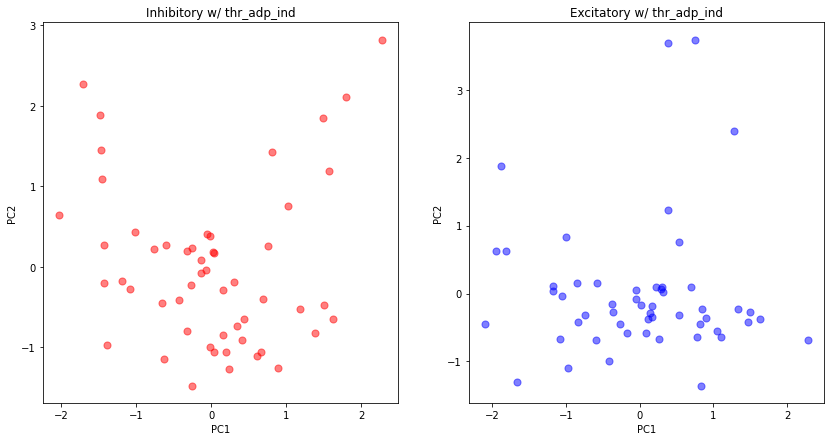

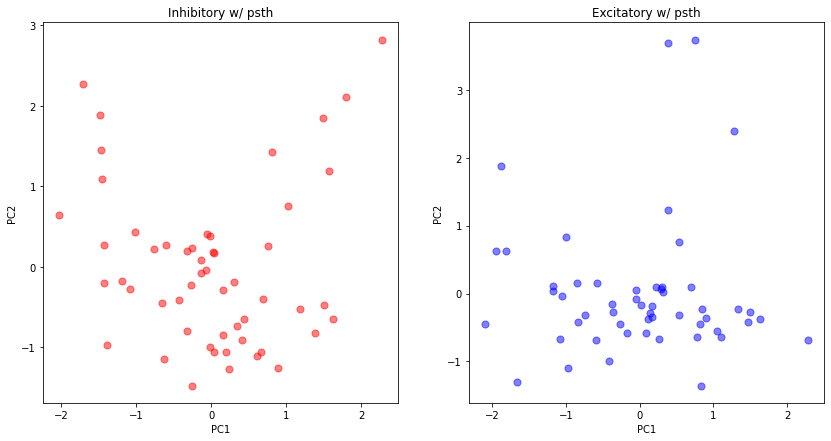

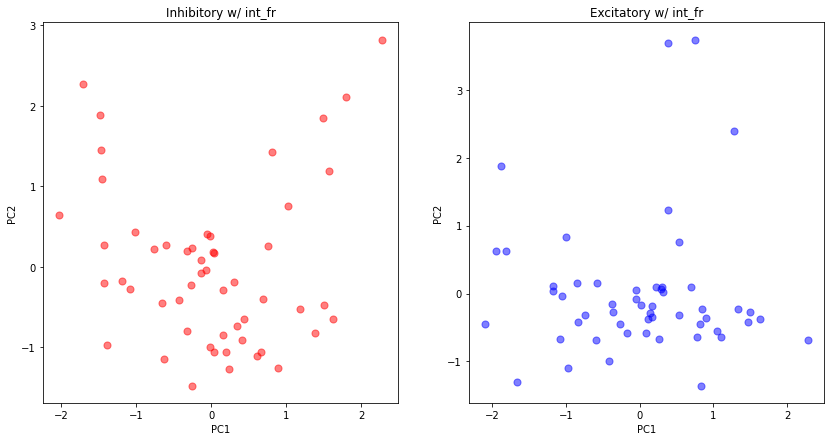

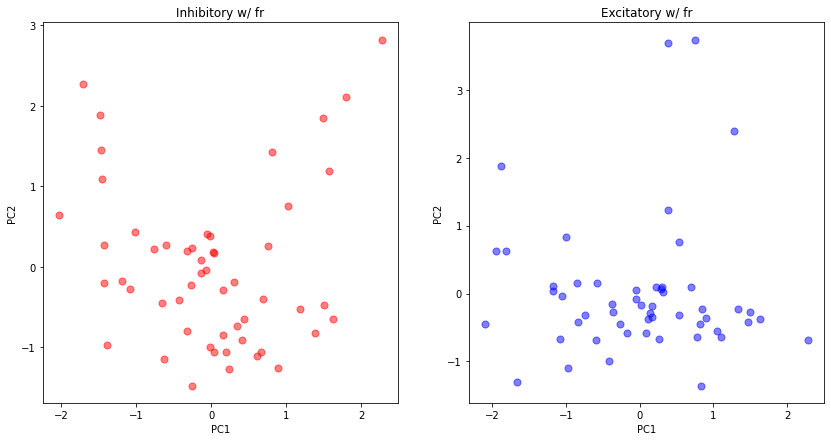

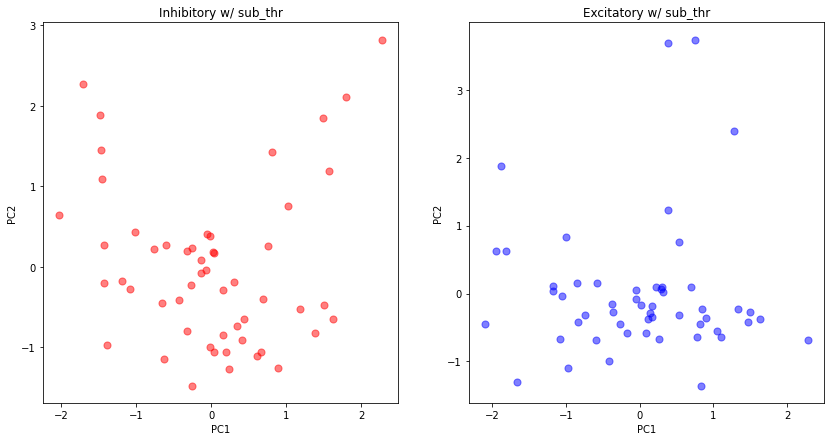

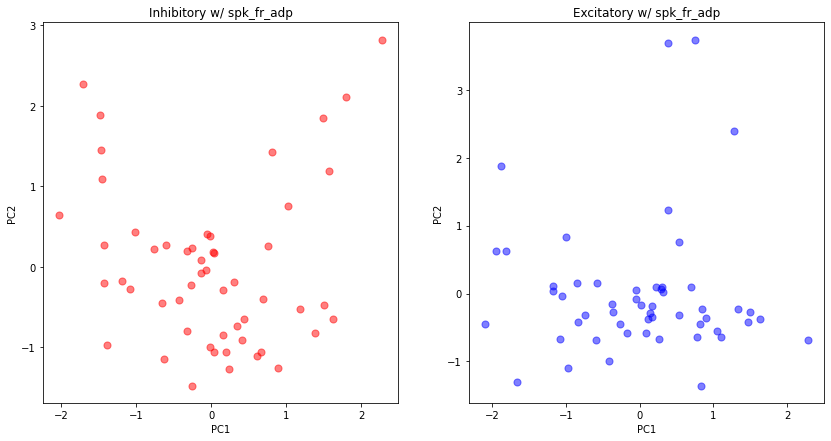

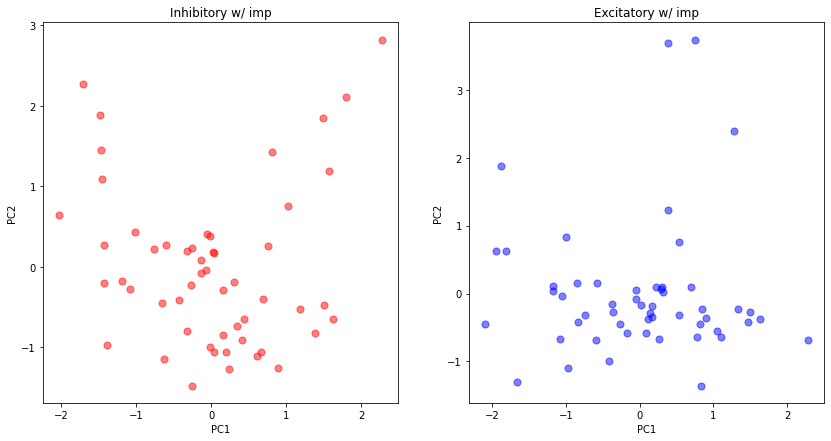

In [ ]:
#@title plot PCA one off 
scalar_inh = StandardScaler()
scalar_inh.fit(data_inh['all'])
scalar_exc = StandardScaler()
scalar_exc.fit(data_exc['all'])
data_inh_pca = scalar_inh.transform(data_inh['all'])
data_exc_pca = scalar_exc.transform(data_exc['all'])
size_inh = data_inh['all'].shape
size_exc = data_exc['all'].shape
min_size = min(size_inh[0],size_exc[0])

for m in range(21):
  data_inh_pca = np.array(data_inh_pca[:min_size,:])
  data_exc_pca = np.array(data_exc_pca[:min_size,:])
  
  # mask
  # mask_exc = np.ones_like(data_exc_pca)
  # mask_inh = np.ones_like(data_inh_pca)
  # mask_inh[:,m] = 0
  # mask_exc[:,m] = 0
  # data_inh_pca= data_inh_pca*mask_inh




  pca_x = PCA(n_components=10,whiten=True)

  fig = plt.figure(figsize=[14,7])

  ax = fig.add_subplot(1, 2, 1, ) #projection='3d'
  # Project the data in 2D
  reduced_data_inh = pca_x.fit_transform(data_inh_pca)
  n_components = 2

  kmeans = KMeans(n_clusters=5).fit(reduced_data_inh)
  centroids_inh = kmeans.cluster_centers_
  label = kmeans.labels_.astype(float)
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c='red', s=50, alpha=0.5,marker = 'o') #,reduced_data_inh[:,2]
  # ax.scatter(centroids_inh[:, 0], centroids_inh[:, 1],c='black', s=50,marker = 'x')
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_title('Inhibitory w/ '+cols[m])
  
  ## Excitatory plot 

  # mask
  # data_exc_pca = data_exc_pca*mask_exc



  pca_x = PCA(whiten=True)

  # Project the data in 2D
  reduced_data_exc = pca_x.fit_transform(data_exc_pca)
  n_components = 2
  ax = fig.add_subplot(1, 2, 2, ) #projection='3d'

  kmeans = KMeans(n_clusters=5).fit(reduced_data_exc)
  centroids_exc = kmeans.cluster_centers_
  label = kmeans.labels_.astype(float)
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax.scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c='blue', s=50, alpha=0.5,marker = 'o') #,reduced_data_exc[:,2]
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_title('Excitatory w/ '+cols[m])
  plt.show()

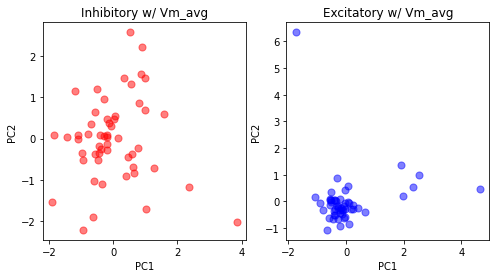

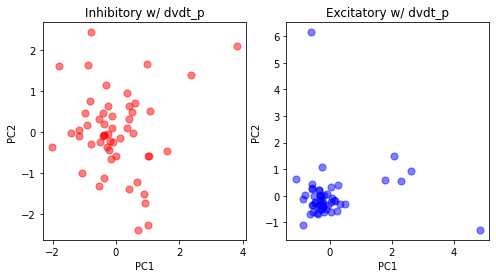

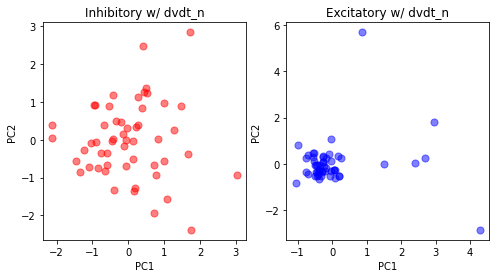

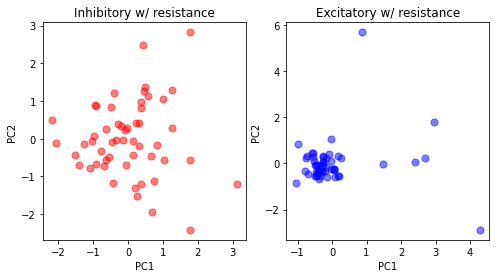

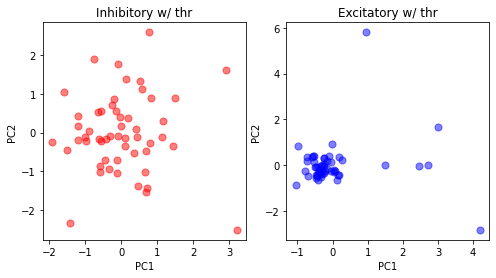

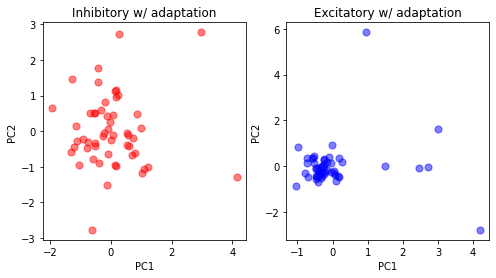

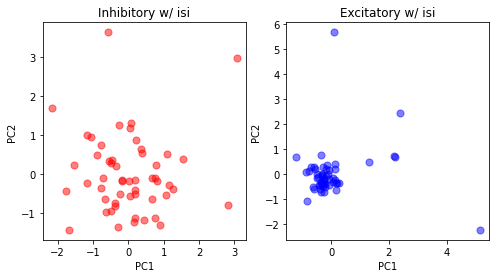

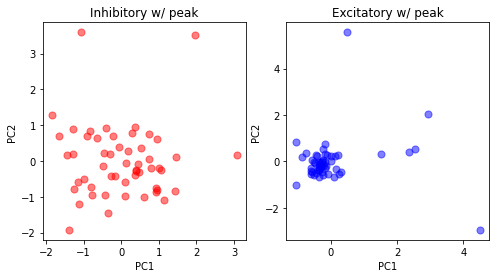

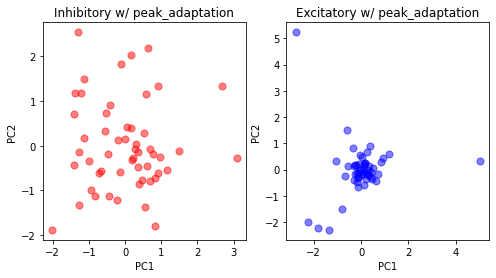

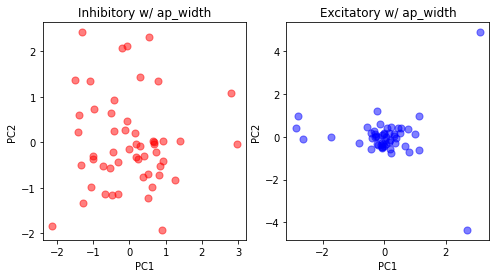

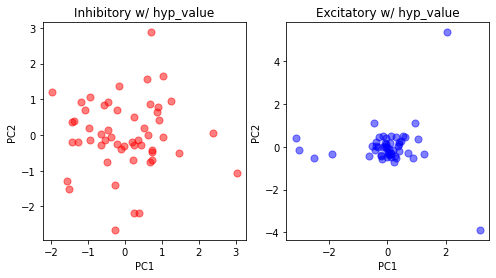

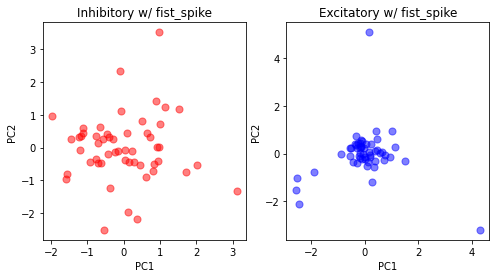

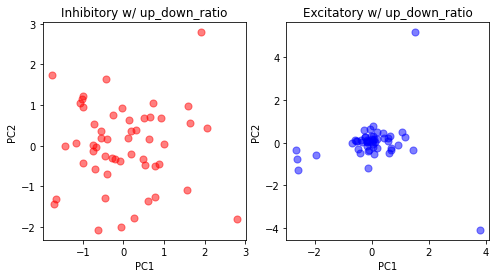

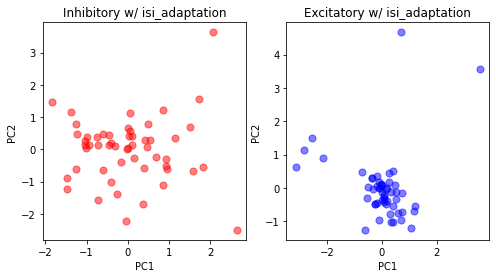

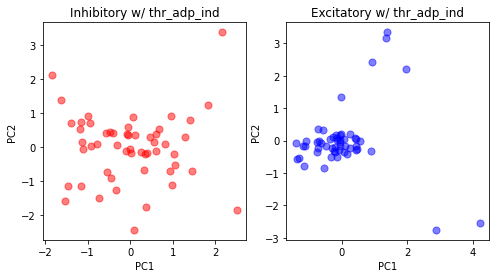

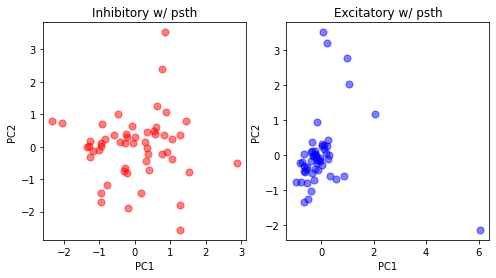

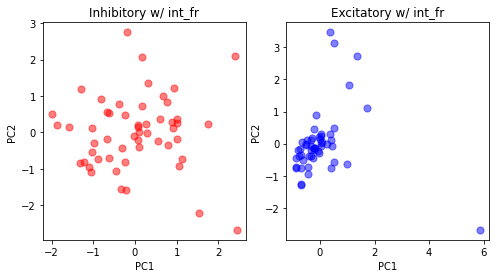

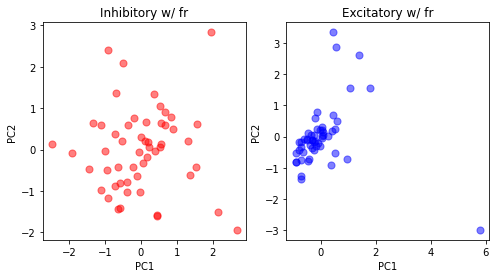

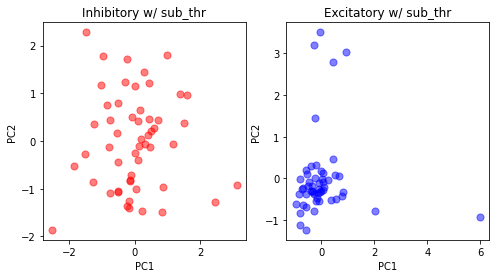

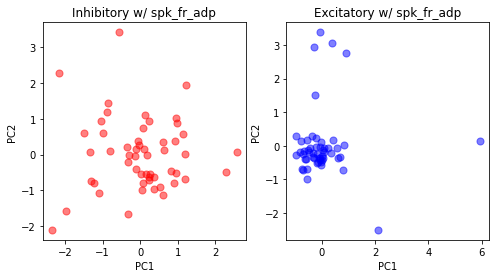

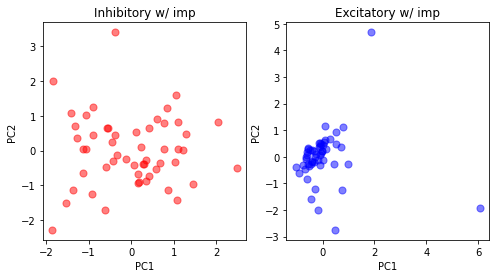

In [ ]:
#@title plot PCA one off with shuffling
scalar_inh = StandardScaler()
scalar_inh.fit_transform(data_inh['all'])
scalar_exc = StandardScaler()
scalar_exc.fit_transform(data_exc['all'])
data_inh_pca = scalar_inh.transform(data_inh['all'])
data_exc_pca = scalar_exc.transform(data_exc['all'])
size_inh = data_inh['all'].shape
size_exc = data_exc['all'].shape
min_size = min(size_inh[0],size_exc[0])

for m in range(21):
  data_inh_pca = np.array(data_inh_pca[:min_size,:])
  data_exc_pca = np.array(data_exc_pca[:min_size,:])
  
  # mask
  # mask_exc = np.ones_like(data_exc_pca)
  # mask_inh = np.ones_like(data_inh_pca)
  # mask_inh[:,m] = 0
  # mask_exc[:,m] = 0
  # data_inh_pca= data_inh_pca*mask_inh

  # shuffle 
  data_inh_pca= shuffle_prams(data_inh_pca,m)


  pca_x = PCA(n_components=10,whiten=True)

  fig = plt.figure(figsize=[8,4])

  ax = fig.add_subplot(1, 2, 1, ) #projection='3d'
  # Project the data in 2D
  reduced_data_inh = pca_x.fit_transform(data_inh_pca)
  n_components = 2

  kmeans = KMeans(n_clusters=5).fit(reduced_data_inh)
  centroids_inh = kmeans.cluster_centers_
  label = kmeans.labels_.astype(float)
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c='red', s=50, alpha=0.5,marker = 'o') #,reduced_data_inh[:,2]
  # ax.scatter(centroids_inh[:, 0], centroids_inh[:, 1],c='black', s=50,marker = 'x')
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_title('Inhibitory w/ '+features[m])
  
  ## Excitatory plot 

  # mask
  # data_exc_pca = data_exc_pca*mask_exc

  #shuffle 
  data_exc_pca= shuffle_prams(data_exc_pca,m)

  pca_x = PCA(whiten=True)

  # Project the data in 2D
  reduced_data_exc = pca_x.fit_transform(data_exc_pca)
  n_components = 2
  ax = fig.add_subplot(1, 2, 2, ) #projection='3d'

  kmeans = KMeans(n_clusters=5).fit(reduced_data_exc)
  centroids_exc = kmeans.cluster_centers_
  label = kmeans.labels_.astype(float)
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax.scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c='blue', s=50, alpha=0.5,marker = 'o') #,reduced_data_exc[:,2]
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_title('Excitatory w/ '+features[m])
  plt.show()

## PCA with drug condition (D1 and Serotonin)

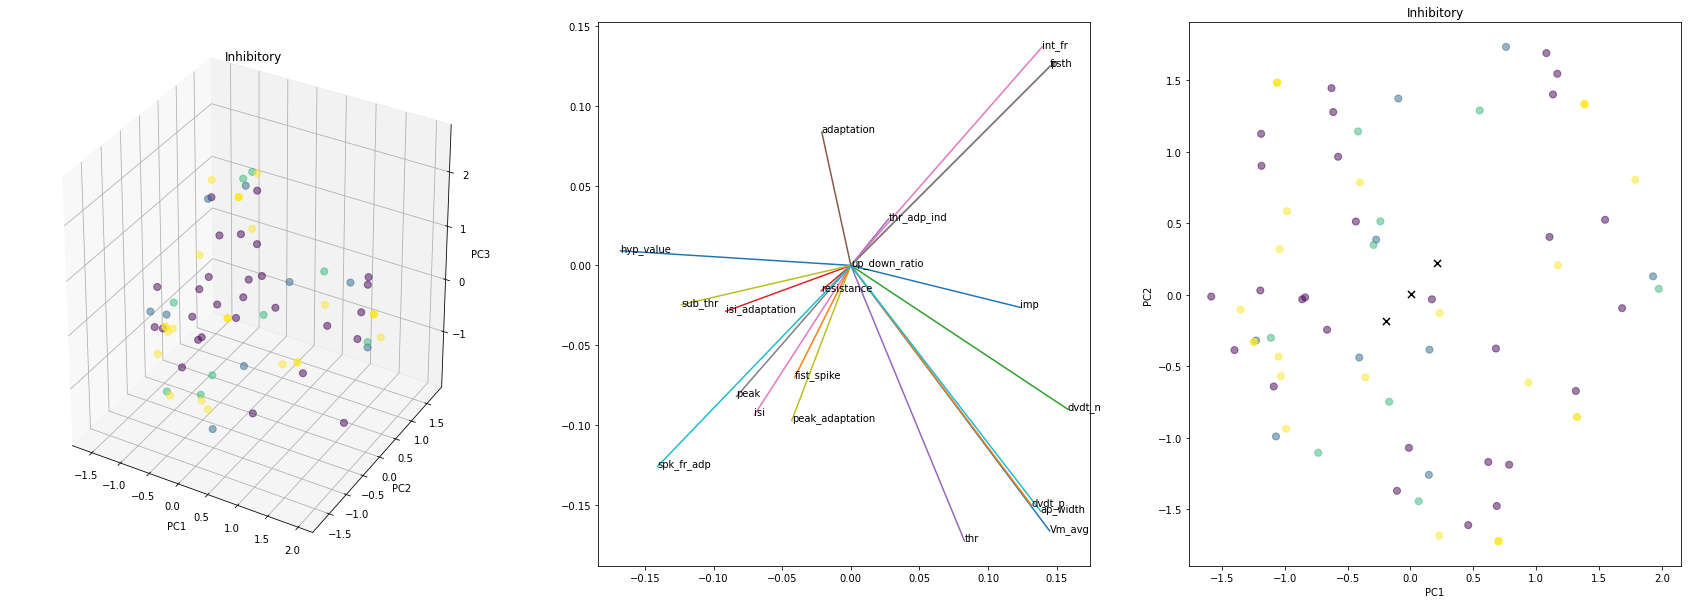

0.5798312559198854


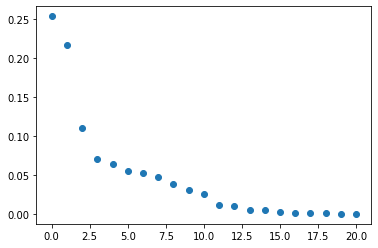

In [ ]:
from mpl_toolkits.mplot3d import axes3d
#@title PCA Inhibitory with Drug 
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

data_inh_umap_scaler = StandardScaler()
data_sag_inh = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh']))))  #
data_dop_inh = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh']))))  #
data_sag_inh_acsf = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh_acsf']))))  #
data_dop_inh_acsf = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh_acsf']))))  #

data_all_inh_cond = np.concatenate((data_dop_inh,data_sag_inh),axis=0)
data_inh_umap_acsf = np.concatenate((data_sag_inh_acsf, data_dop_inh_acsf),axis=0)
data_all_combined = np.concatenate((data_all_inh_cond, data_inh_umap_acsf),axis=0)

pca_x = PCA(whiten=True,random_state=40)

# fig, ax = plt.subplots(1,3,figsize=[16,8])

fig = plt.figure(figsize=[30,10])

ax3d = fig.add_subplot(1,3,1,projection='3d',)
axloadings = fig.add_subplot(1,3,2)
ax2d = fig.add_subplot(1,3,3)

# Project the data in 2D

reduced_data_inh = pca_x.fit_transform(data_all_combined)

reduced_data_inh_sag = pca_x.fit_transform(data_sag_inh)
reduced_data_inh_dop = pca_x.fit_transform(data_dop_inh)
reduced_data_inh_acsf = pca_x.fit_transform(data_inh_umap_acsf)

exp_var_inh = pca_x.explained_variance_ratio_
loadings = pca_x.components_.T * np.sqrt(pca_x.explained_variance_)

n_components = 3

kmeans = KMeans(n_clusters=3).fit(data_all_combined)

centroids_inh = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)
labels_inh = np.zeros(data_all_combined.shape[0])
lengths = [data_dop_inh.shape[0],data_sag_inh.shape[0],data_sag_inh_acsf.shape[0],data_dop_inh_acsf.shape[0]]

for i in range(len(labels_inh)):
  if i<=lengths[0]-1:
    labels_inh[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_inh[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_inh[i] = 2
  elif i<=(lengths[0]+lengths[1]+lengths[2]+lengths[3])-1 and i >(lengths[0]+lengths[1]+lengths[2])-1:
    labels_inh[i] = 3
ax2d.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c=labels_inh, s=50, alpha=0.5,marker = 'o')
ax2d.scatter(centroids_inh[:, 0], centroids_inh[:, 1],c='black', s=50,marker = 'x')
ax2d.set_xlabel('PC1')
ax2d.set_ylabel('PC2')
ax2d.set_title('Inhibitory')


for i, feature in enumerate(features):
  # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.5:
    axloadings.plot([0,loadings[i, 0]],[0,loadings[i, 1]])
    axloadings.annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])


ax3d.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1],reduced_data_inh[:,2], c=labels_inh,s=50,  alpha=0.5,marker = 'o')
# ax3d.scatter(centroids_inh[:, 0], centroids_inh[:, 1],centroids_inh[:,2],s=50,c='black', marker = 'x')
ax3d.set_xlabel('PC1')
ax3d.set_ylabel('PC2')
ax3d.set_zlabel('PC3')
ax3d.set_title('Inhibitory')
plt.show()
plt.scatter(np.arange(len(exp_var_inh)),exp_var_inh)
print(sum(exp_var_inh[:3]))
plt.show()

Text(0.5, 1.0, 'Inhibitory')

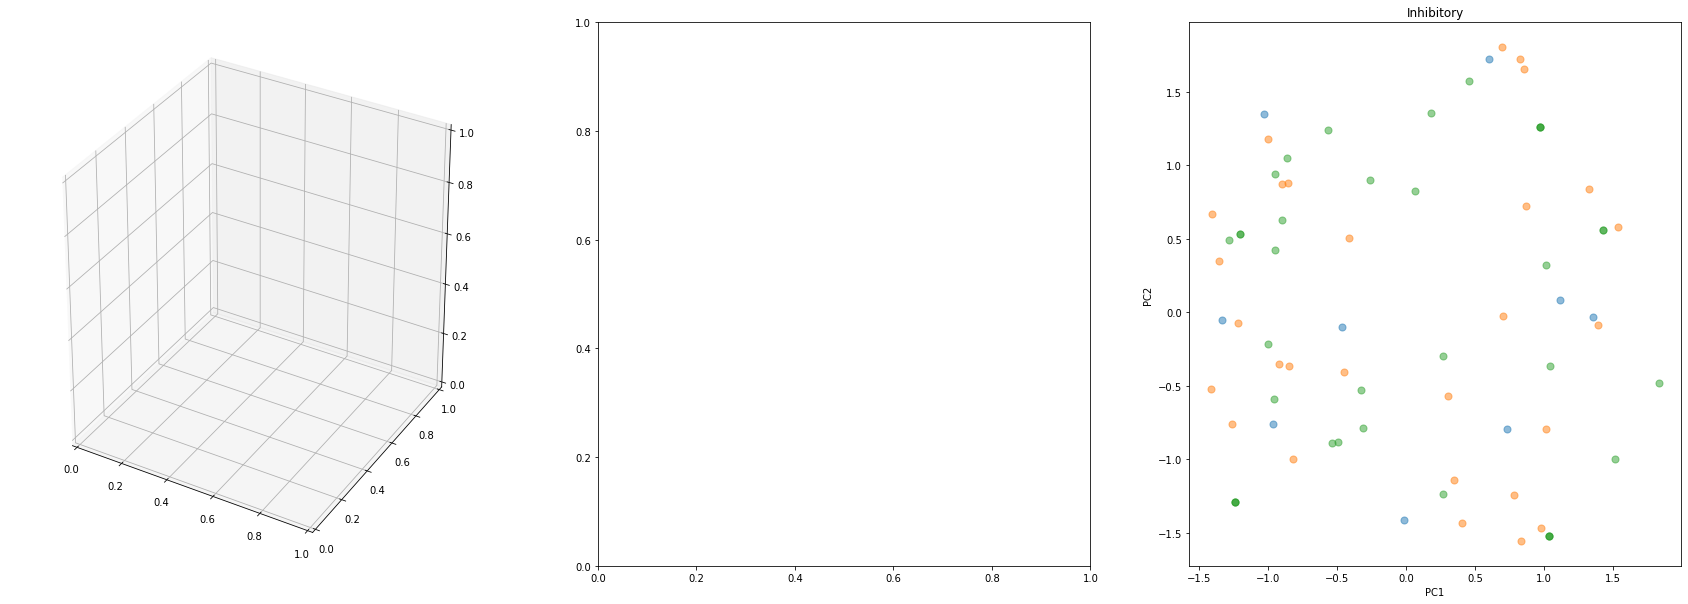

In [ ]:
from mpl_toolkits.mplot3d import axes3d
#@title PCA Inhibitory with Drug 
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

data_inh_umap_scaler = StandardScaler()
data_sag_inh = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh']))))  #
data_dop_inh = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh']))))  #
data_sag_inh_acsf = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh_acsf']))))  #
data_dop_inh_acsf = normalize(data_inh_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh_acsf']))))  #

data_all_inh_cond = np.concatenate((data_dop_inh,data_sag_inh),axis=0)
data_inh_umap_acsf = np.concatenate((data_sag_inh_acsf, data_dop_inh_acsf),axis=0)
data_all_combined = np.concatenate((data_all_inh_cond, data_inh_umap_acsf),axis=0)

pca_x_sag = PCA(whiten=True,random_state=40)

pca_x_dop = PCA(whiten=True,random_state=40)

pca_x_acsf = PCA(whiten=True,random_state=40)

# fig, ax = plt.subplots(1,3,figsize=[16,8])

fig = plt.figure(figsize=[30,10])

ax3d = fig.add_subplot(1,3,1,projection='3d',)
axloadings = fig.add_subplot(1,3,2)
ax2d = fig.add_subplot(1,3,3)

# Project the data in 2D

# reduced_data_inh = pca_x.fit_transform(data_all_combined)

reduced_data_inh_sag = pca_x_sag.fit_transform(data_sag_inh)
reduced_data_inh_dop = pca_x_dop.fit_transform(data_dop_inh)
reduced_data_inh_acsf = pca_x_acsf.fit_transform(data_inh_umap_acsf)

exp_var_inh_sag = pca_x_sag.explained_variance_ratio_
exp_var_inh_dop = pca_x_dop.explained_variance_ratio_
exp_var_inh_acsf = pca_x_acsf.explained_variance_ratio_


loadings_sag = pca_x_sag.components_.T * np.sqrt(pca_x_sag.explained_variance_)

loadings_dop = pca_x_dop.components_.T * np.sqrt(pca_x_dop.explained_variance_)

loadings_acsf = pca_x_acsf.components_.T * np.sqrt(pca_x_acsf.explained_variance_)

n_components = 3

kmeans = KMeans(n_clusters=3).fit(data_all_combined)

centroids_inh = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)
labels_inh = np.zeros(data_all_combined.shape[0])
lengths = [data_dop_inh.shape[0],data_sag_inh.shape[0],data_sag_inh_acsf.shape[0],data_dop_inh_acsf.shape[0]]

for i in range(len(labels_inh)):
  if i<=lengths[0]-1:
    labels_inh[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_inh[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_inh[i] = 2
  elif i<=(lengths[0]+lengths[1]+lengths[2]+lengths[3])-1 and i >(lengths[0]+lengths[1]+lengths[2])-1:
    labels_inh[i] = 3
ax2d.scatter(reduced_data_inh_sag[:,0], reduced_data_inh_sag[:,1], s=50, alpha=0.5,marker = 'o') #c=labels_inh[:lengths[0]]
ax2d.scatter(reduced_data_inh_dop[:,0], reduced_data_inh_dop[:,1],  s=50, alpha=0.5,marker = 'o') #c=labels_inh[lengths[0]:lengths[1]],
ax2d.scatter(reduced_data_inh_acsf[:,0], reduced_data_inh_acsf[:,1], s=50, alpha=0.5,marker = 'o') # c=labels_inh[lengths[1]:lengths[2]+lengths[3]],

# ax2d.scatter(centroids_inh[:, 0], centroids_inh[:, 1],c='black', s=50,marker = 'x')
ax2d.set_xlabel('PC1')
ax2d.set_ylabel('PC2')
ax2d.set_title('Inhibitory')


# for i, feature in enumerate(features):
#   # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.5:
#     axloadings.plot([0,loadings[i, 0]],[0,loadings[i, 1]])
#     axloadings.annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])


# ax3d.scatter(reduced_data_inh[:,0], reduced_data_inh[:,1],reduced_data_inh[:,2], c=labels_inh,s=50,  alpha=0.5,marker = 'o')
# # ax3d.scatter(centroids_inh[:, 0], centroids_inh[:, 1],centroids_inh[:,2],s=50,c='black', marker = 'x')
# ax3d.set_xlabel('PC1')
# ax3d.set_ylabel('PC2')
# ax3d.set_zlabel('PC3')
# ax3d.set_title('Inhibitory')
# plt.show()
# plt.scatter(np.arange(len(exp_var_inh)),exp_var_inh)
# print(sum(exp_var_inh[:3]))
# plt.show()

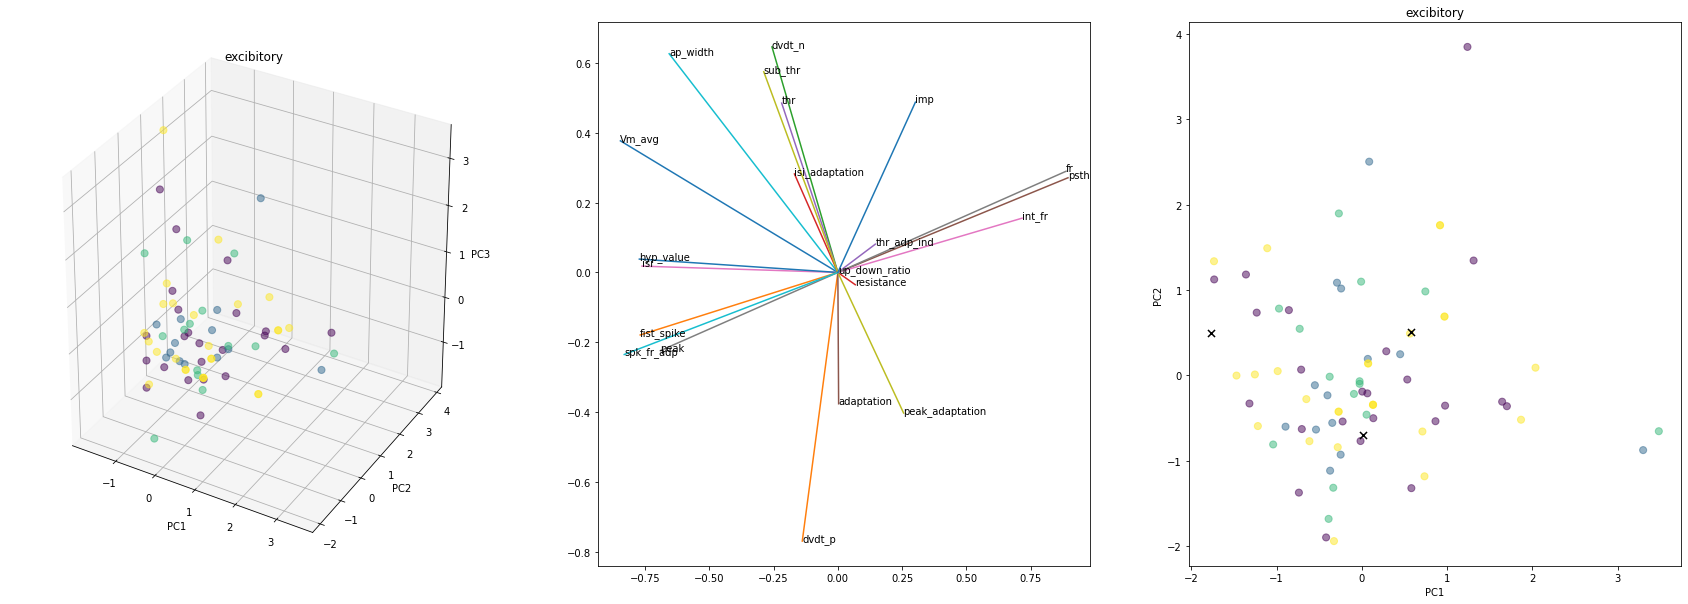

0.6085368843137187


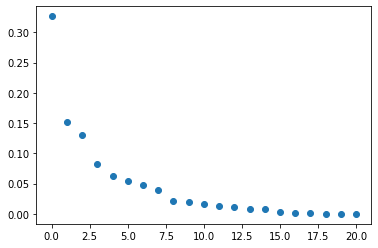

In [ ]:
from mpl_toolkits.mplot3d import axes3d
#@title PCA Inhibitory with Drug 
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

data_exc_umap_scaler_dop = StandardScaler()
data_exc_umap_scaler_sag = StandardScaler()
data_exc_umap_scaler_acsf = StandardScaler()

data_sag_exc =  data_exc_umap_scaler_sag.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['exc'])))  #
data_dop_exc =  data_exc_umap_scaler_dop.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['exc'])))  #
data_sag_exc_acsf =  data_exc_umap_scaler_acsf.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['exc_acsf'])))  #
data_dop_exc_acsf =  data_exc_umap_scaler_acsf.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['exc_acsf'])))  #

data_all_exc_cond = np.concatenate((data_dop_exc,data_sag_exc),axis=0)
data_exc_umap_acsf = np.concatenate((data_sag_exc_acsf, data_dop_exc_acsf),axis=0)
data_all_combined = np.concatenate((data_all_exc_cond, data_exc_umap_acsf),axis=0)

pca_x = PCA(whiten=True,random_state=40)

# fig, ax = plt.subplots(1,3,figsize=[16,8])

fig = plt.figure(figsize=[30,10])

ax3d = fig.add_subplot(1,3,1,projection='3d',)
axloadings = fig.add_subplot(1,3,2)
ax2d = fig.add_subplot(1,3,3)

# Project the data in 2D

reduced_data_exc = pca_x.fit_transform(data_all_combined)
exp_var_exc = pca_x.explained_variance_ratio_
loadings = pca_x.components_.T * np.sqrt(pca_x.explained_variance_)

n_components = 3

kmeans = KMeans(n_clusters=3).fit(data_all_combined)

centroids_exc = kmeans.cluster_centers_
label = kmeans.labels_.astype(float)
labels_exc = np.zeros(data_all_combined.shape[0])
lengths = [data_dop_exc.shape[0],data_sag_exc.shape[0],data_sag_exc_acsf.shape[0],data_dop_exc_acsf.shape[0]]

for i in range(len(labels_exc)):
  if i<=lengths[0]-1:
    labels_exc[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_exc[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_exc[i] = 2
  elif i<=(lengths[0]+lengths[1]+lengths[2]+lengths[3])-1 and i >(lengths[0]+lengths[1]+lengths[2])-1:
    labels_exc[i] = 3
ax2d.scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c=labels_exc, s=50, alpha=0.5,marker = 'o')
ax2d.scatter(centroids_exc[:, 0], centroids_exc[:, 1],c='black', s=50,marker = 'x')
ax2d.set_xlabel('PC1')
ax2d.set_ylabel('PC2')
ax2d.set_title('excibitory')


for i, feature in enumerate(features):
  # if (abs(loadings[i, 0])+abs(loadings[i, 1]))>0.5:
    axloadings.plot([0,loadings[i, 0]],[0,loadings[i, 1]])
    axloadings.annotate(feature, xy = [loadings[i, 0], loadings[i, 1]])


ax3d.scatter(reduced_data_exc[:,0], reduced_data_exc[:,1],reduced_data_exc[:,2], c=labels_exc,s=50,  alpha=0.5,marker = 'o')
# ax3d.scatter(centroids_exc[:, 0], centroids_exc[:, 1],centroids_exc[:,2],s=50,c='black', marker = 'x')
ax3d.set_xlabel('PC1')
ax3d.set_ylabel('PC2')
ax3d.set_zlabel('PC3')
ax3d.set_title('excibitory')
plt.show()
plt.scatter(np.arange(len(exp_var_exc)),exp_var_exc)
print(sum(exp_var_exc[:3]))
plt.show()

#t-SNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

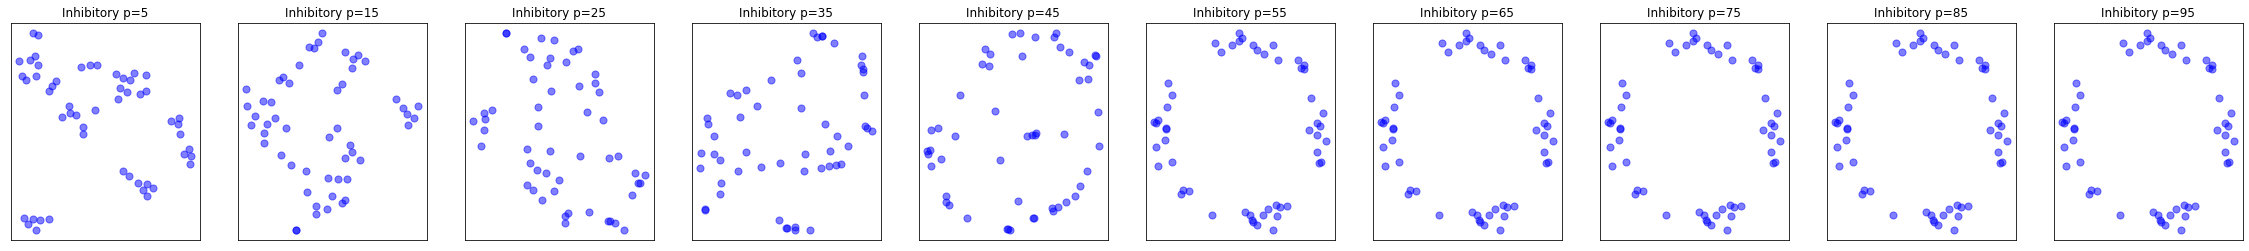

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

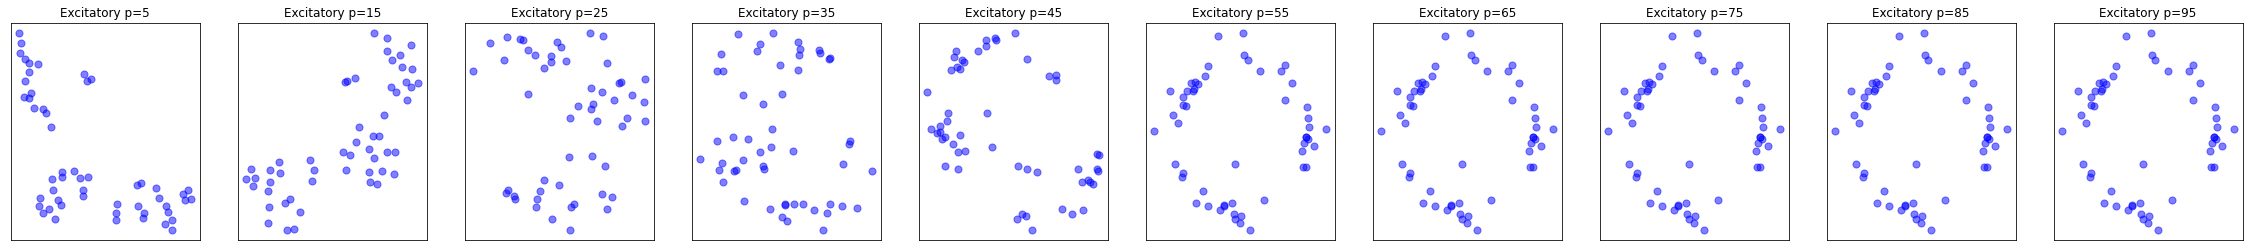

In [ ]:
#@title plot t-SNE all
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.cluster import KMeans

scalar_inh_tsne = StandardScaler()
scalar_exc_tsne = StandardScaler()
min_size = min(data_inh['all'].shape[0],data_exc['all'].shape[0])


data_inh_tsne = scalar_inh_tsne.fit_transform(data_inh['all'])
data_inh_tsne = normalize(data_inh_tsne)
# data_inh_tsne = data_inh['all']


data_exc_tsne = scalar_exc_tsne.fit_transform(data_exc['all'])
data_exc_tsne = normalize(data_exc_tsne)
# data_exc_tsne = data_exc['all']
data_inh_tsne = data_inh_tsne[:min_size,] 

n_components = 2
perplexity_ = np.arange(5,100,10)
fig, ax = plt.subplots(1,len(perplexity_),figsize=[40,4])

for p,j in enumerate(perplexity_):
  tsne = manifold.TSNE(
      n_components=n_components,
      init="pca",
      random_state=0,
      perplexity=j,
      learning_rate="auto",
      n_iter=1000,)

  reduced_data = tsne.fit_transform(np.array(data_inh_tsne))
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c='blue', s=50, alpha=0.5,marker = 'o')
  ax[p].set_title('Inhibitory p='+str(j))
  ax[p].get_xaxis().set_visible(False)
  ax[p].get_yaxis().set_visible(False)    
plt.show()

data_exc_tsne = data_exc_tsne[:min_size,] 

n_components = 2
perplexity_ = np.arange(5,100,10)
fig, ax = plt.subplots(1,len(perplexity_),figsize=[40,4])

for p,j in enumerate(perplexity_):
  tsne = manifold.TSNE(
      n_components=n_components,
      init="pca",
      random_state=0,
      perplexity=j,
      learning_rate="auto",
      n_iter=400,)

  reduced_data = tsne.fit_transform(np.array(data_exc_tsne))
  labels  = [] 
  for i in  kmeans.labels_.astype(float):
    if i ==0:
      labels.append('r')
    if i ==1:
      labels.append('b')
    if i ==2:
      labels.append('green')
    if i ==3:
      labels.append('cyan')
    if i ==4:
      labels.append('purple')                
  ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c='blue', s=50, alpha=0.5,marker = 'o')
  # ax[p].scatter(centroids[:, 0], centroids[:, 1],c='black', s=50,marker = 'x')
  # ax[p].set_xlabel('PC1')
  # ax[p].set_ylabel('PC2')
  ax[p].set_title('Excitatory p='+str(j))
  ax[p].get_xaxis().set_visible(False)
  ax[p].get_yaxis().set_visible(False)
plt.show()  

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


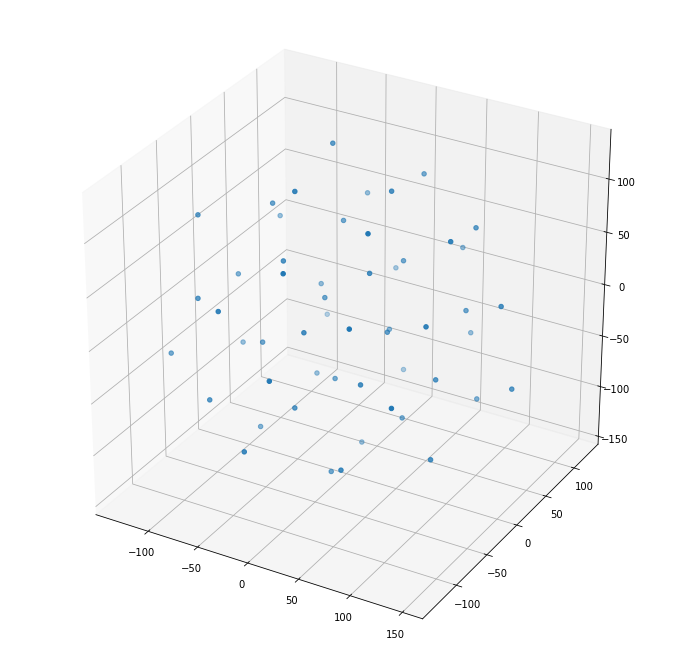

In [ ]:

tsne = manifold.TSNE(
    n_components=3,
    init="pca",
    random_state=0,
    perplexity=55,
    learning_rate="auto",
    n_iter=1000,)

reduced_data = tsne.fit_transform(np.array(data_inh_tsne))
ax = plt.figure(figsize=[12,12]).add_subplot(projection='3d')
ax.scatter(reduced_data[:,0],
           reduced_data[:,1],
           reduced_data[:,2])
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

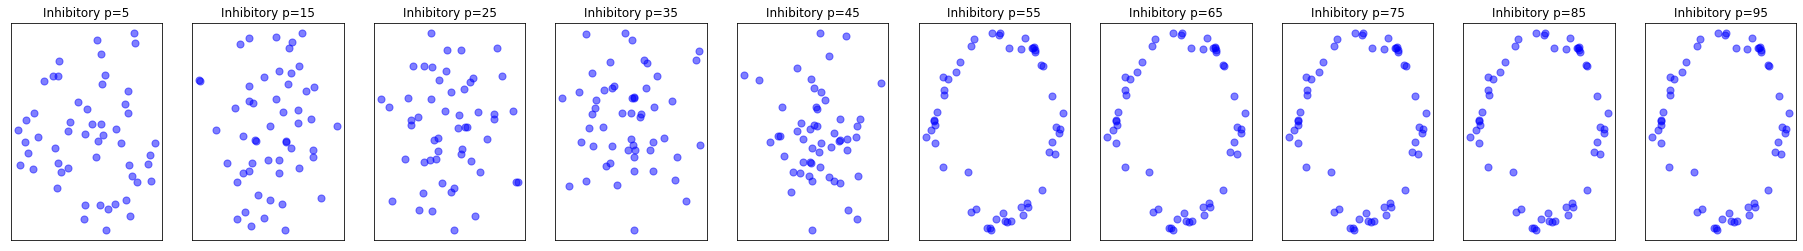

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

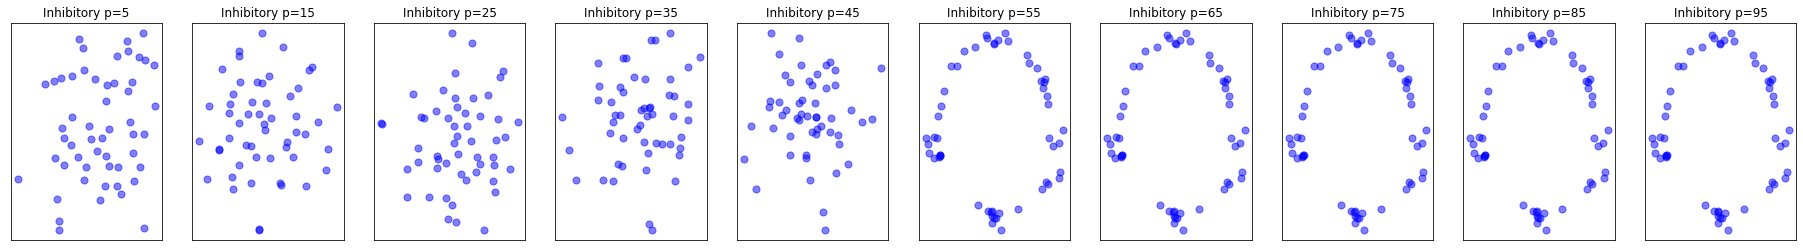

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

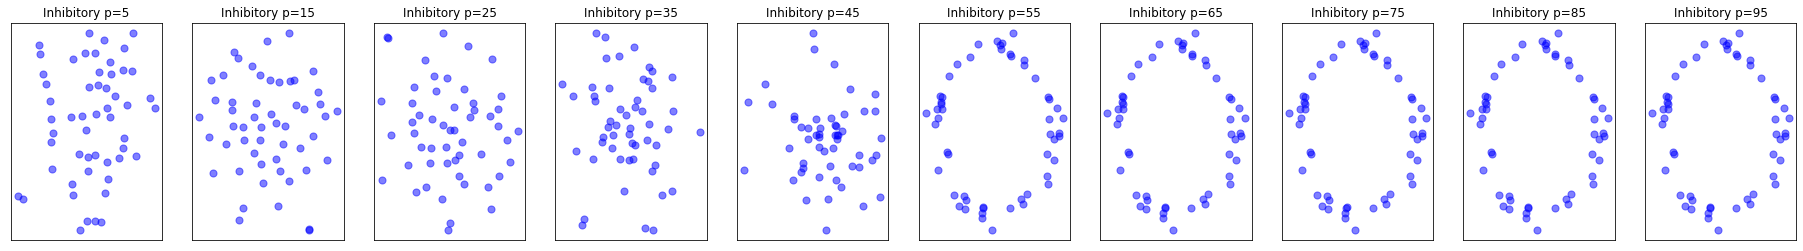

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

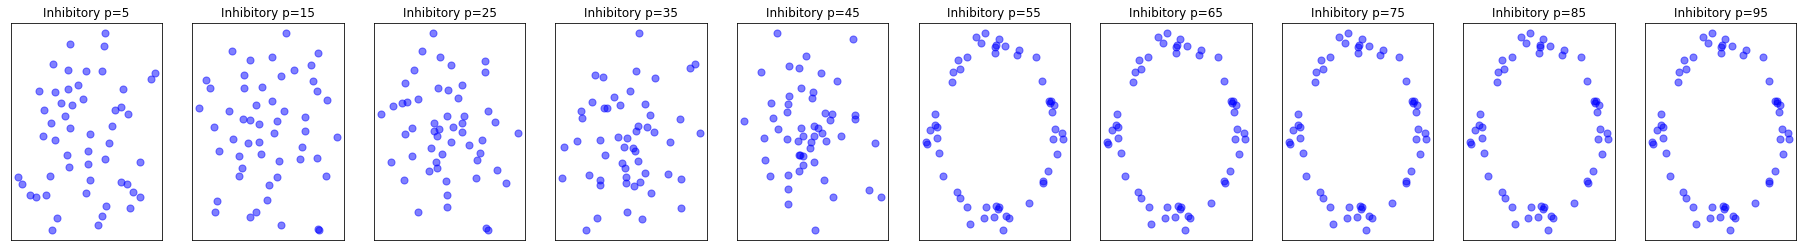

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

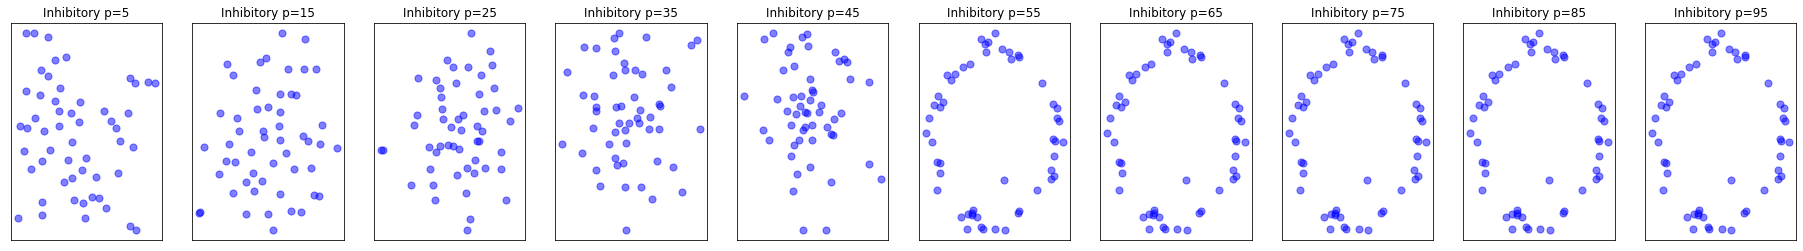

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

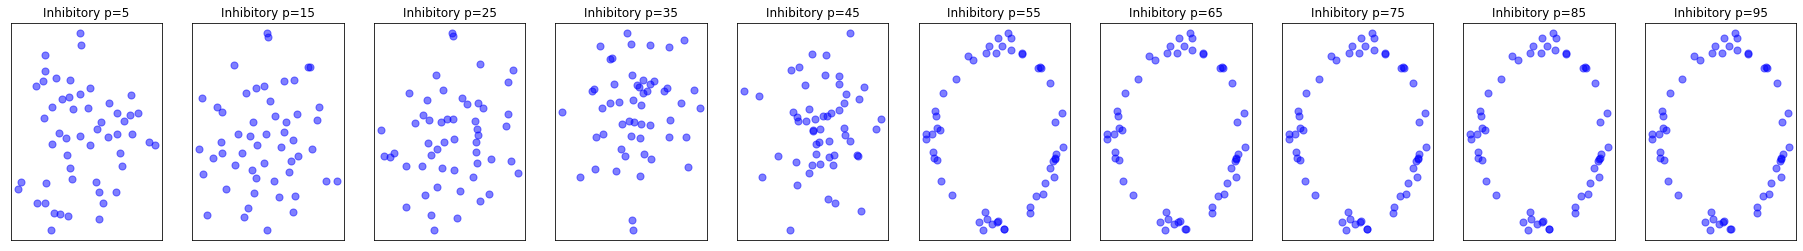

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

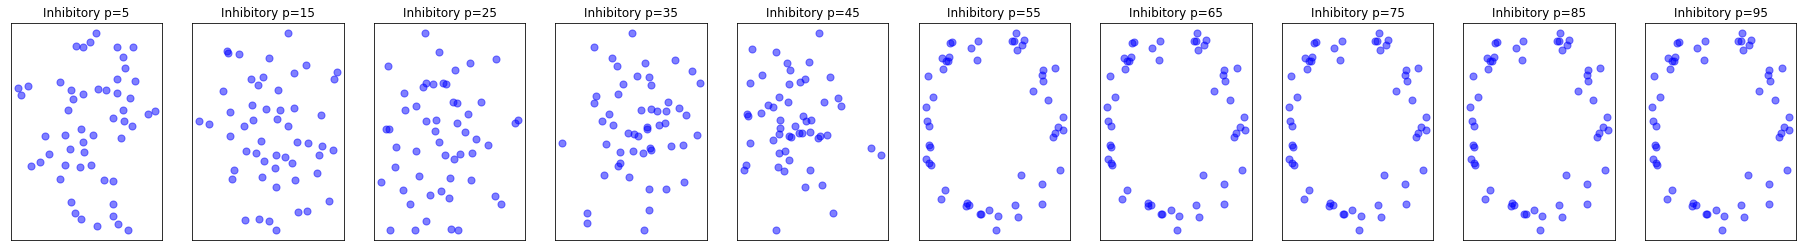

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

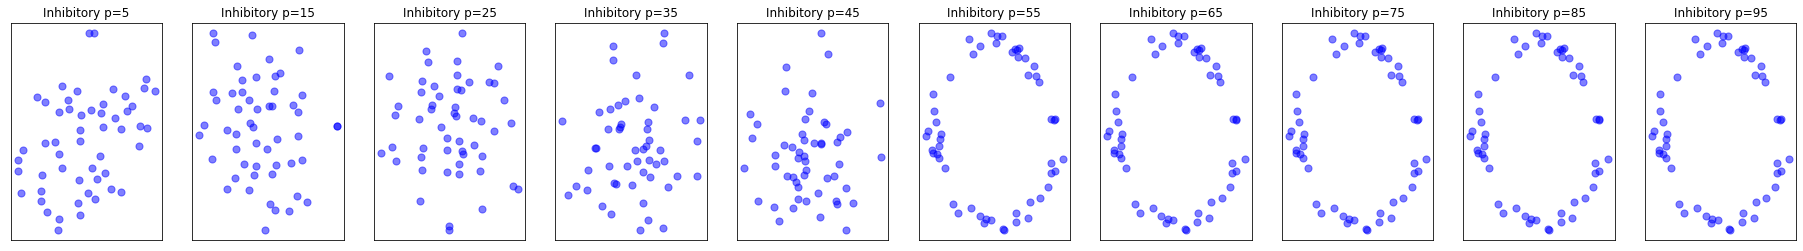

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

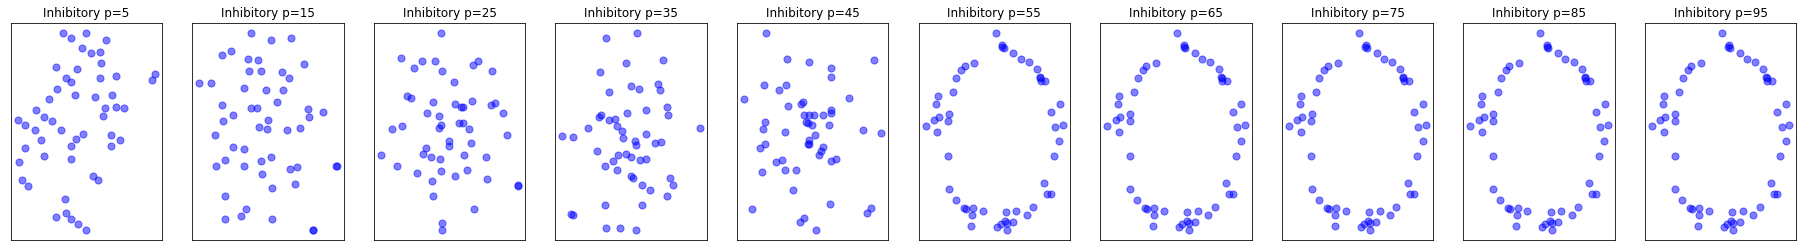

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

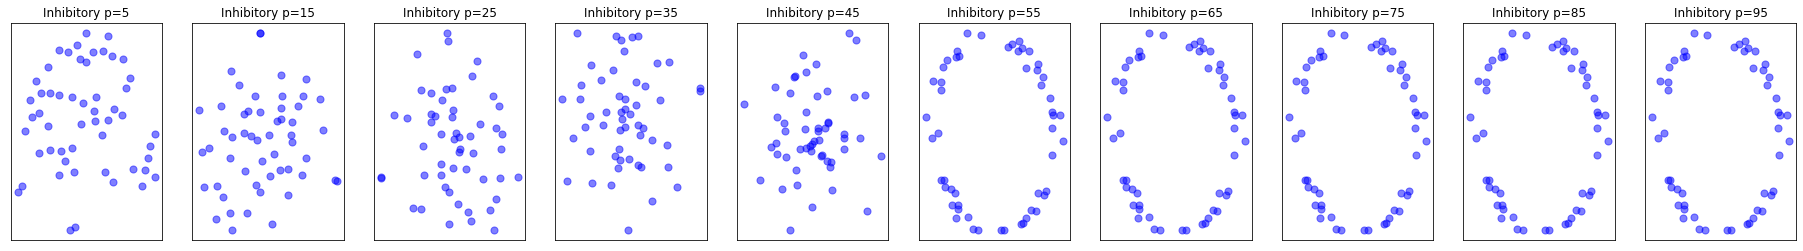

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

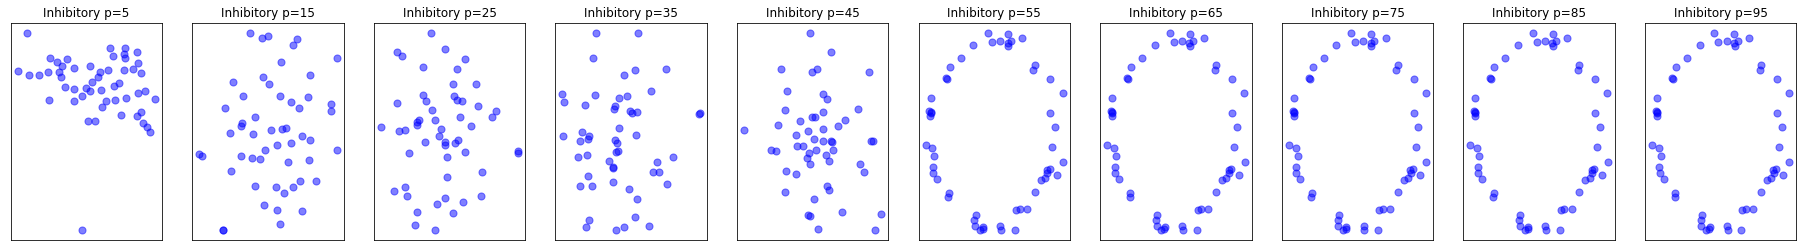

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

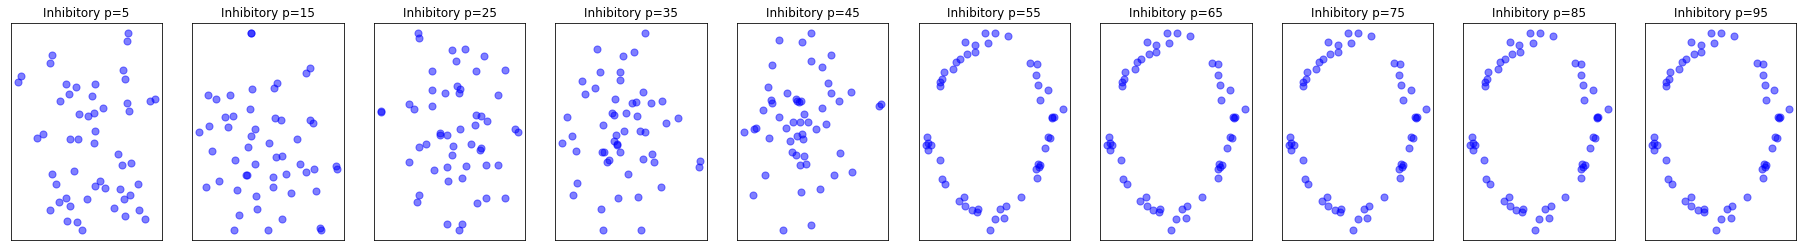

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

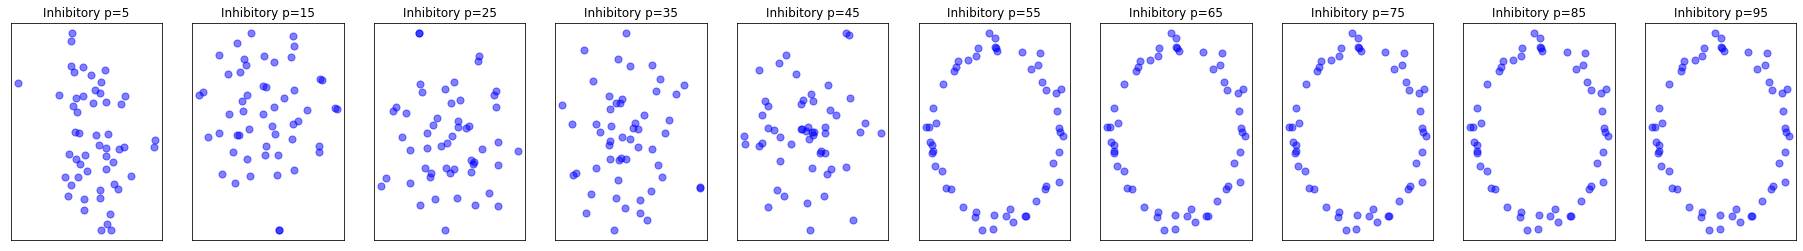

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

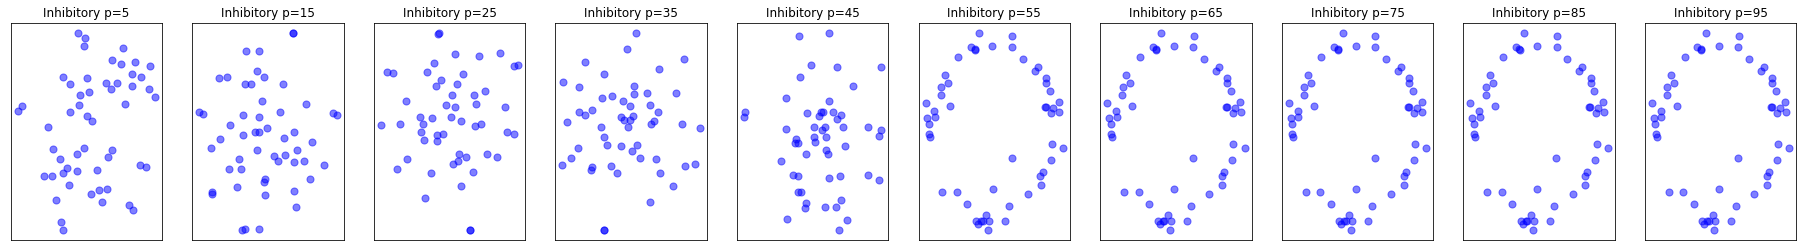

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

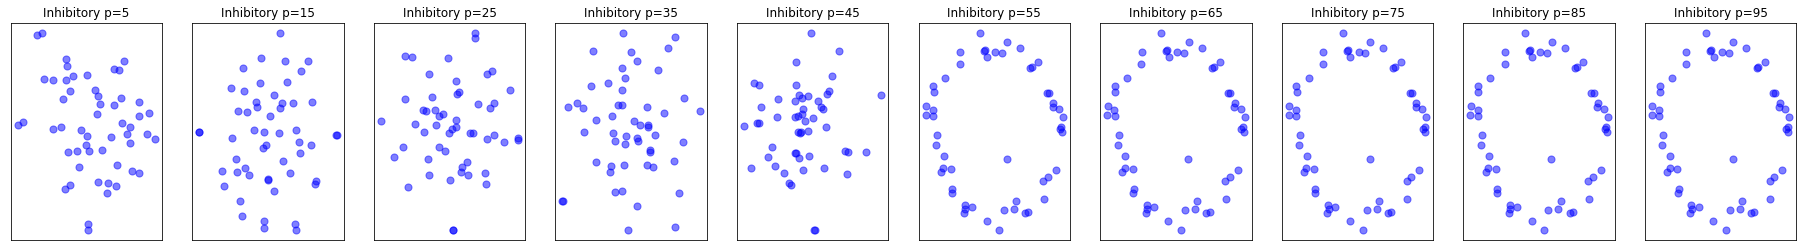

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

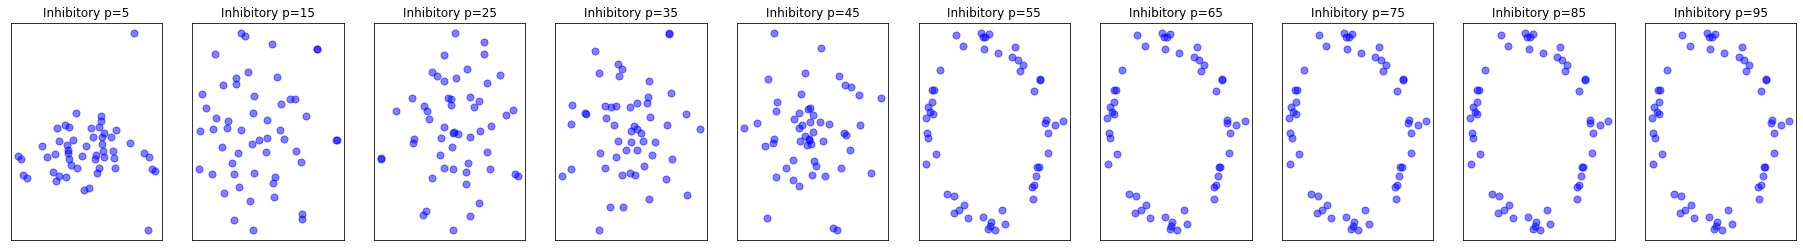

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

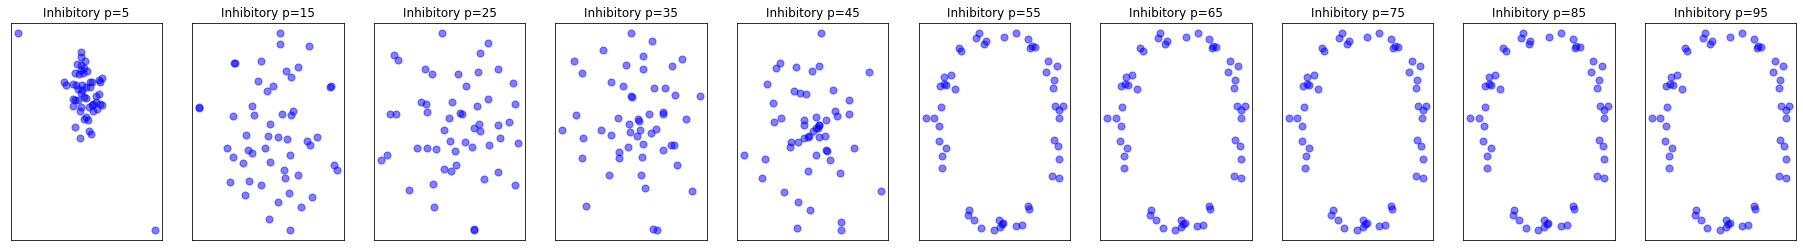

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

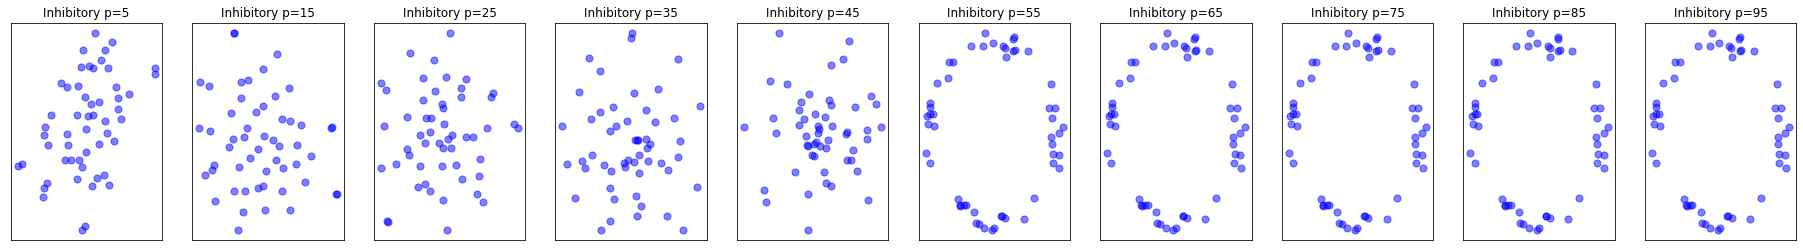

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

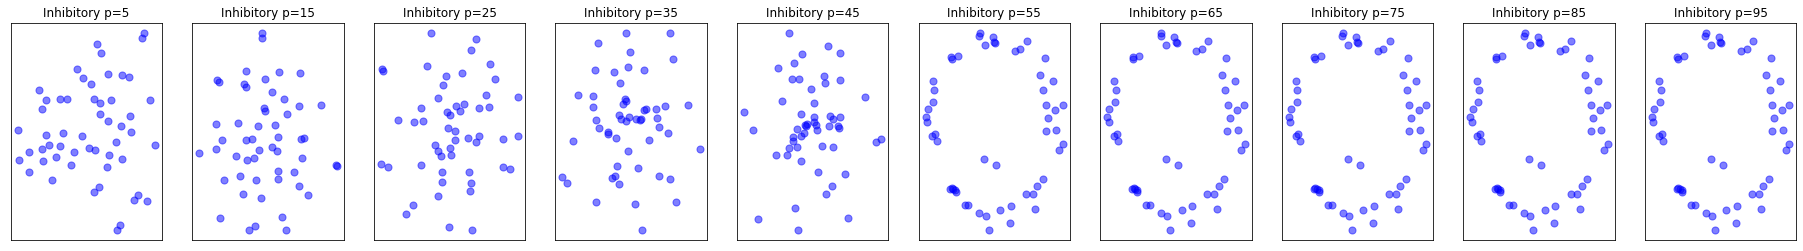

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

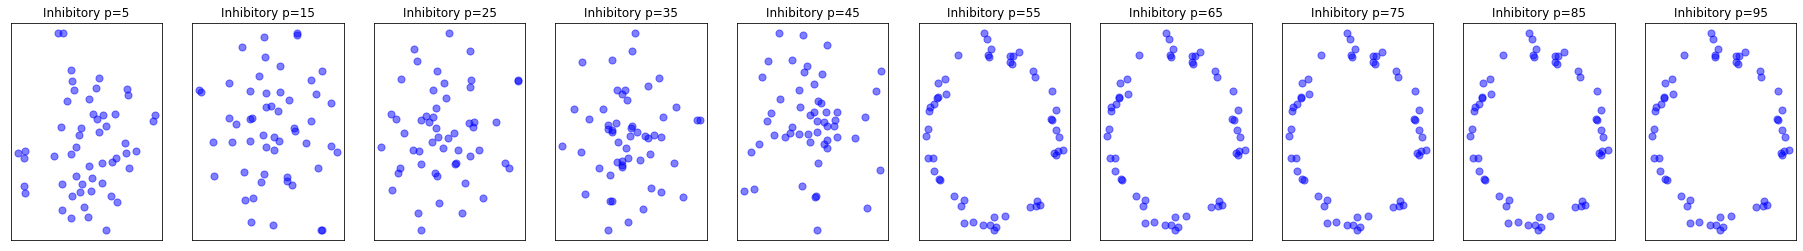

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

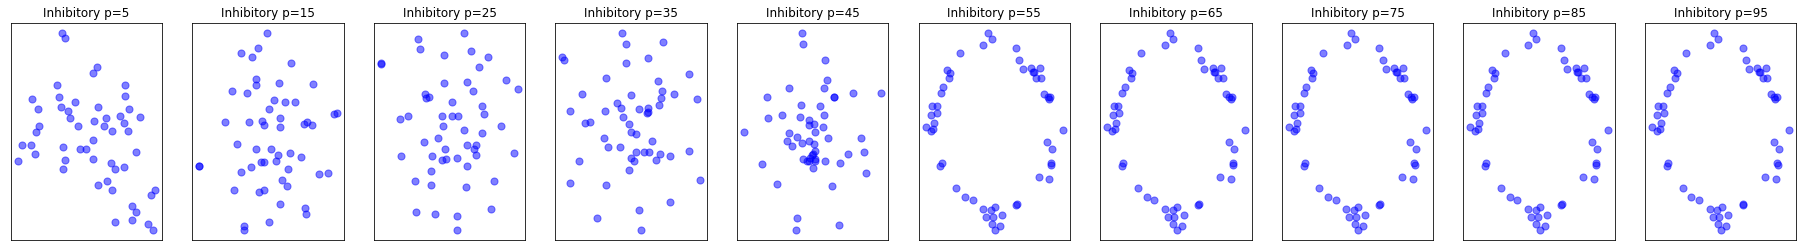

In [ ]:
#@title plot t-SNE one off 
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.cluster import KMeans

data_inh_tsne_scaler = StandardScaler() 

data_inh_tsne = data_inh_tsne_scaler.fit_transform(data_inh['all'])

def normalize(data):
  return (data-np.mean(data))/np.std(data)
for m in range(21):
  data_inh_ = data_inh_tsne[:min_size,] 

  #shuffle 
  data_inh_ = shuffle_prams(data_inh_tsne[:min_size,] ,m)

  # Project the data in 2D
  n_components = 2
  perplexity_ = np.arange(5,100,10)
  fig, ax = plt.subplots(1,len(perplexity_),figsize=[32,4])

  for p,j in enumerate(perplexity_):
    tsne = manifold.TSNE(
        n_components=n_components,
        init="pca",
        random_state=0,
        perplexity=j,
        learning_rate="auto",
        n_iter=1000,)

    reduced_data = tsne.fit_transform(np.array(data_inh_))


    kmeans = KMeans(n_clusters=5).fit(reduced_data)
    centroids = kmeans.cluster_centers_
    label = kmeans.labels_.astype(float)
    xs = np.repeat('x',281)
    os = np.repeat('o',418-281)
    mark = np.concatenate((xs,os))
    mark
    labels  = [] 
    for i in  kmeans.labels_.astype(float):
      if i ==0:
        labels.append('r')
      if i ==1:
        labels.append('b')
      if i ==2:
        labels.append('green')
      if i ==3:
        labels.append('cyan')
      if i ==4:
        labels.append('purple')                
    ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c='blue', s=50, alpha=0.5,marker = 'o')
    ax[p].set_title('Inhibitory p='+str(j))
    ax[p].get_xaxis().set_visible(False)
    ax[p].get_yaxis().set_visible(False)   
  plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

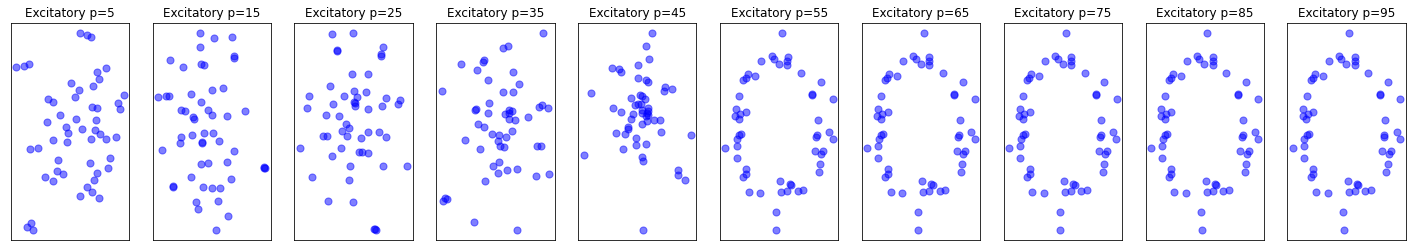

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

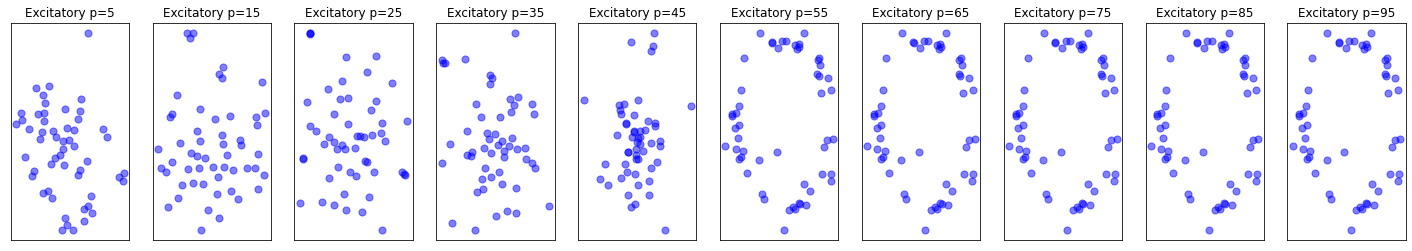

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

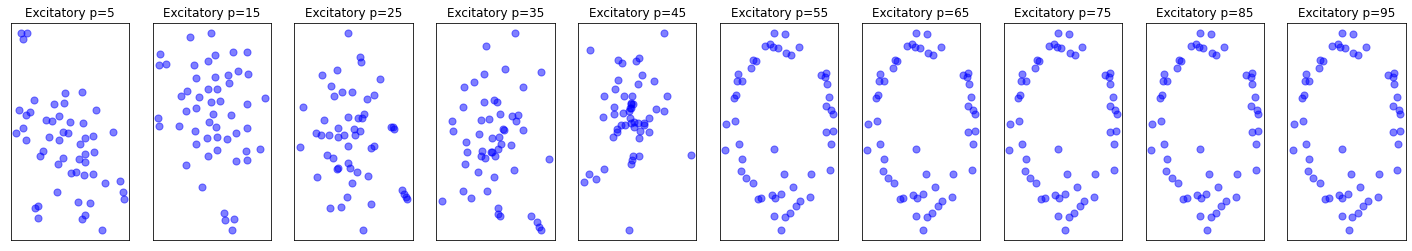

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

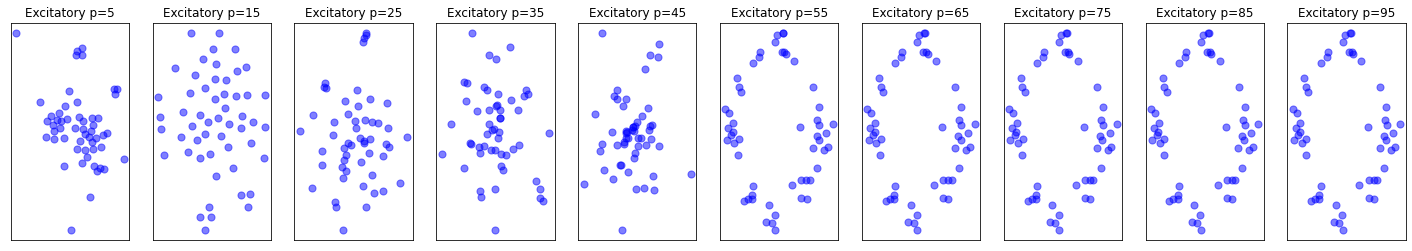

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

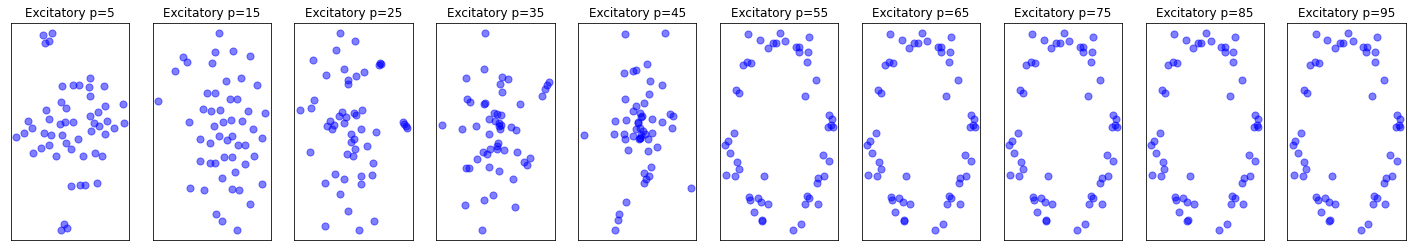

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

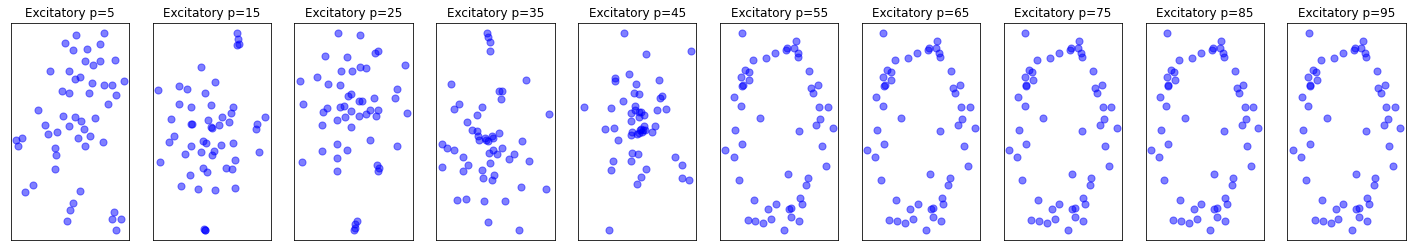

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

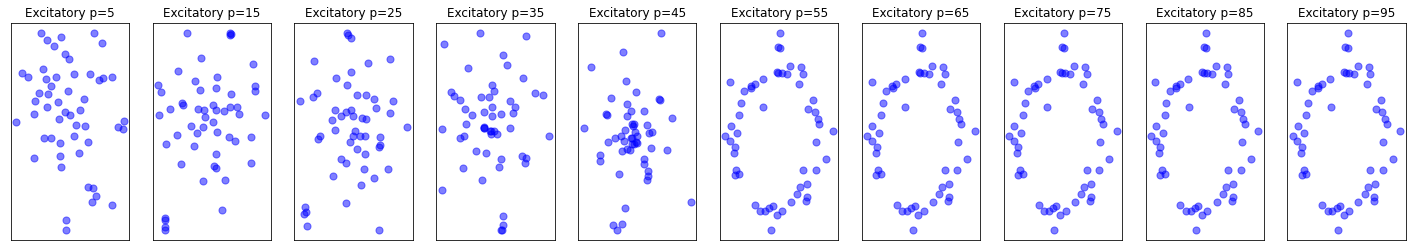

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

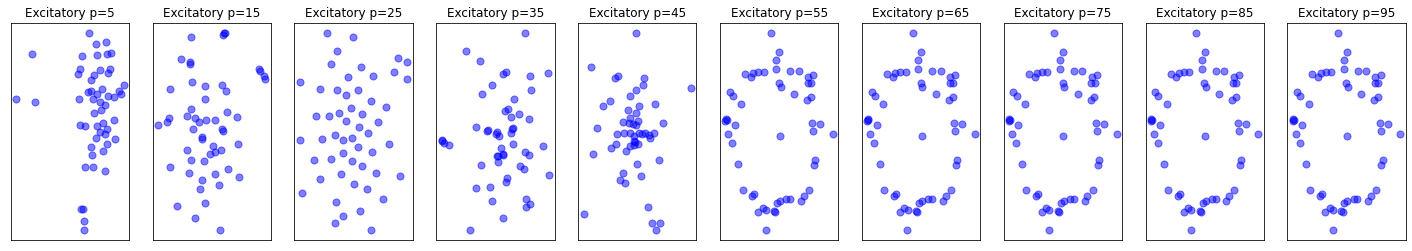

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

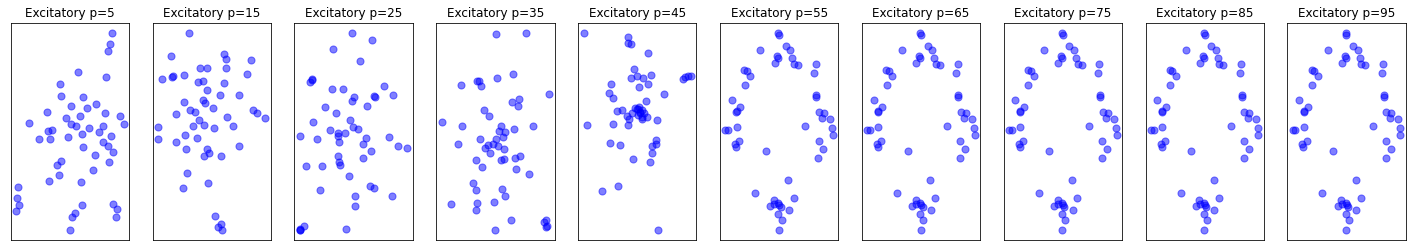

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

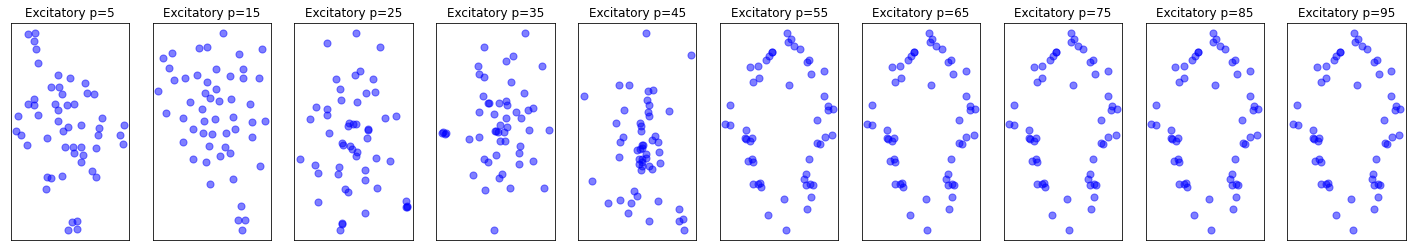

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

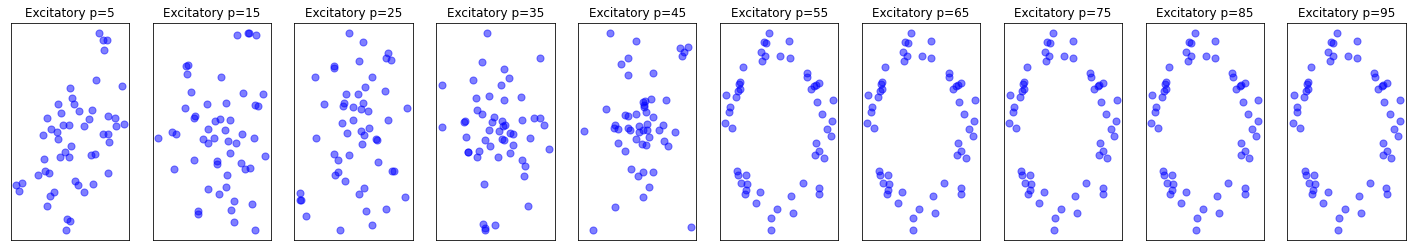

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

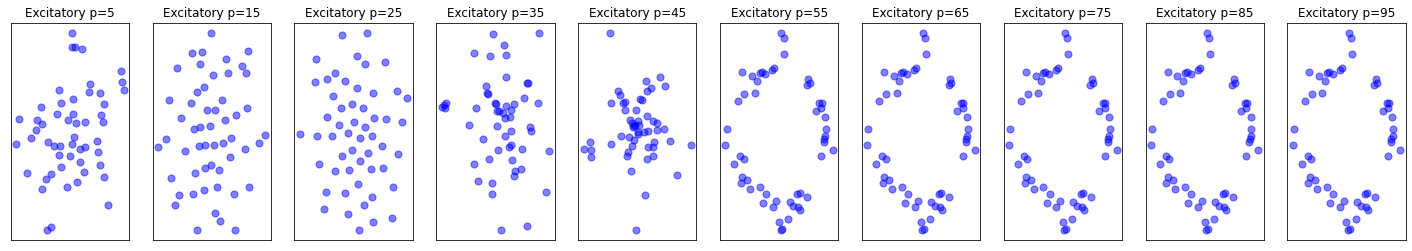

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

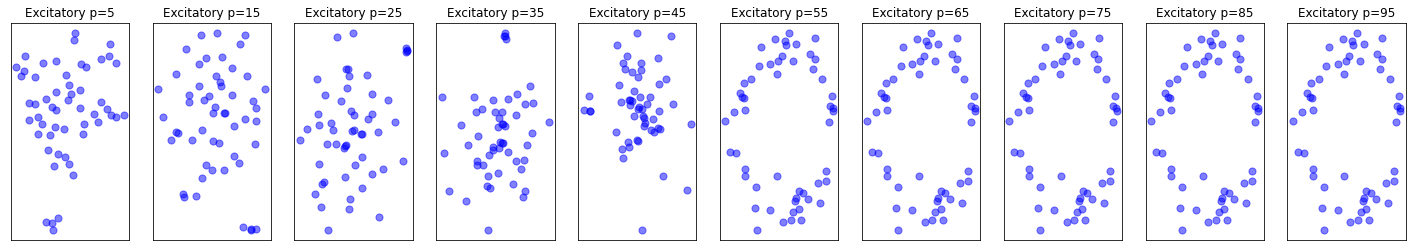

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

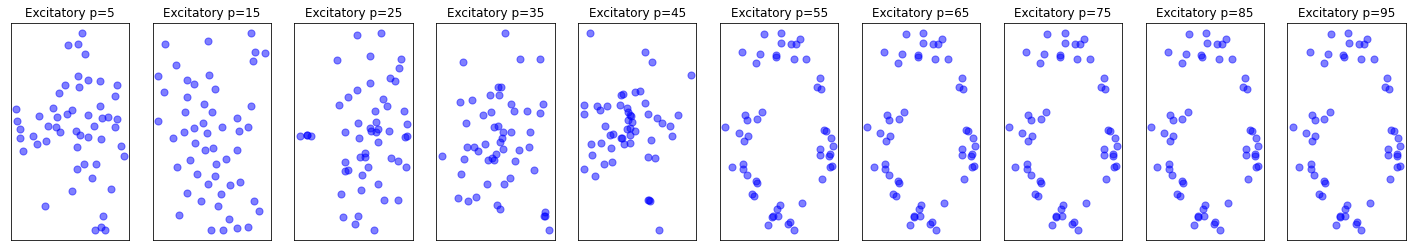

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

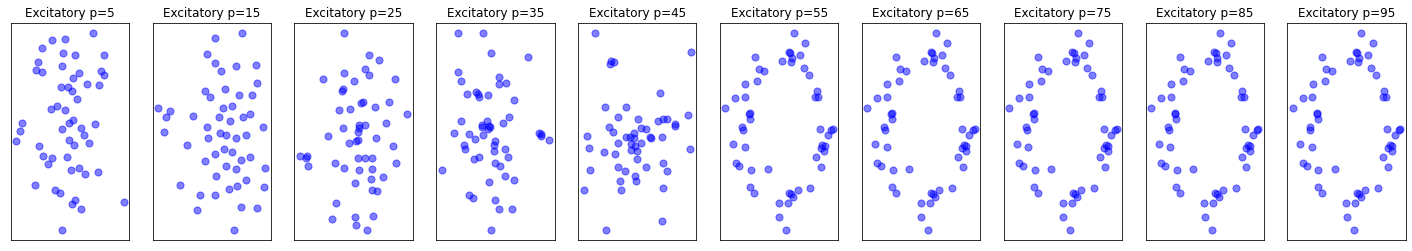

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

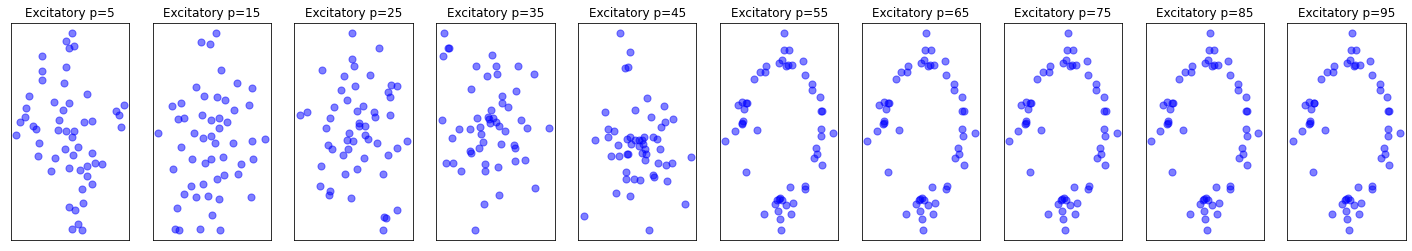

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

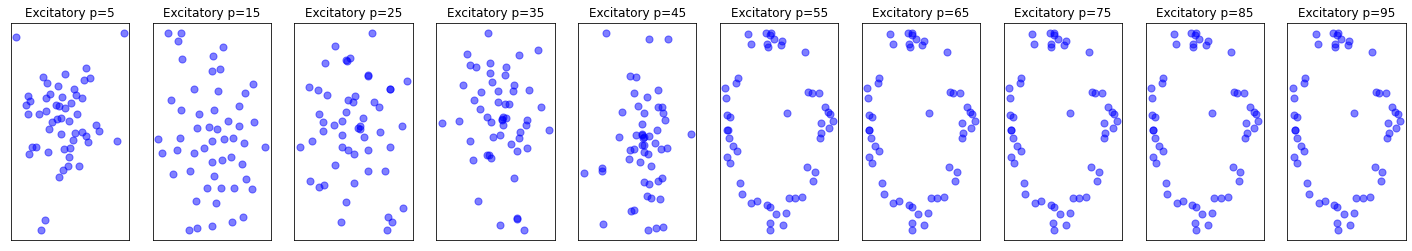

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

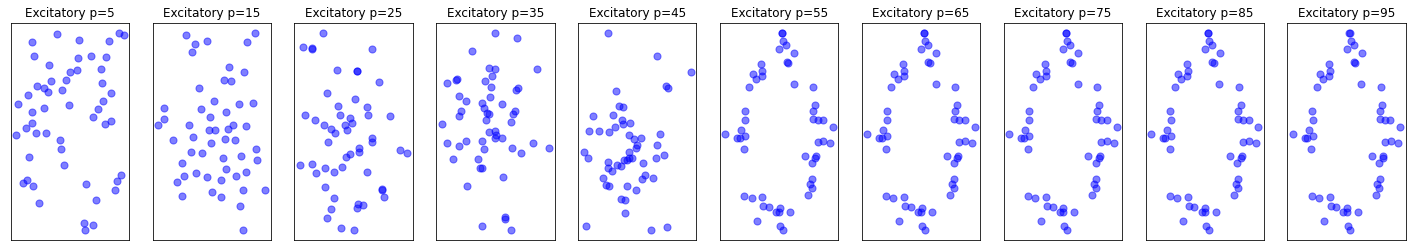

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

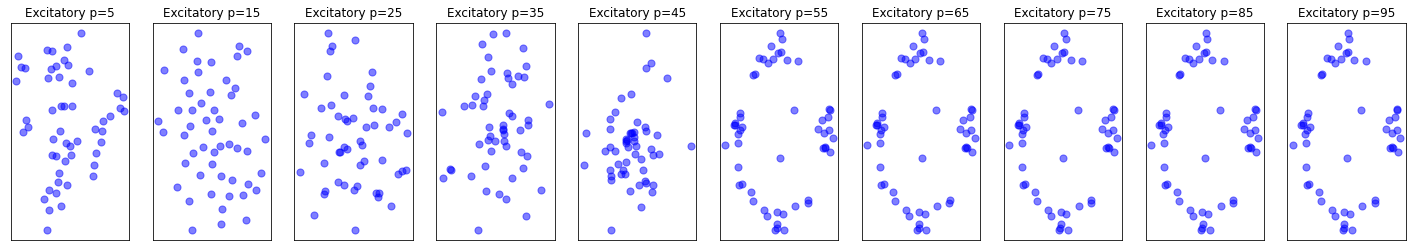

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

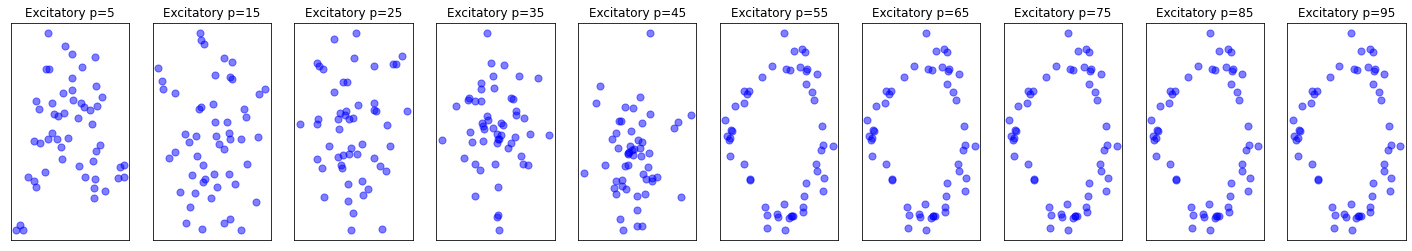

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

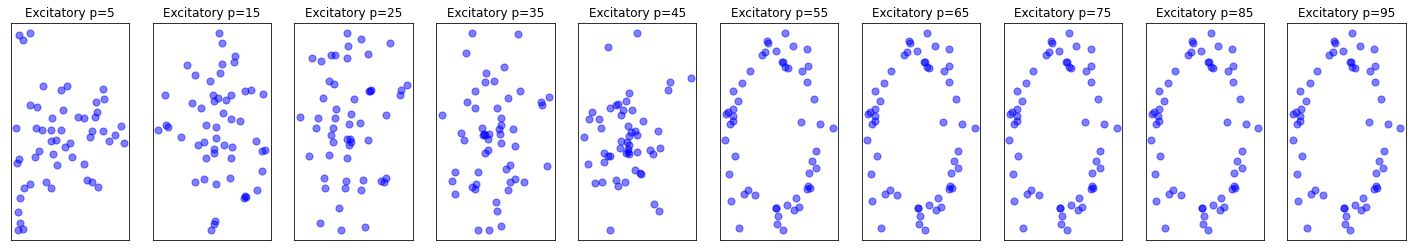

In [ ]:
#@title t-sne one off 
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.cluster import KMeans
data_exc_tsne_scaler = StandardScaler()
# data_exc_tsne_scaler.fit(data_exc['all'])
data_exc_tsne = data_exc_tsne_scaler.fit_transform(data_exc['all'])

def normalize(data):
  return (data-np.mean(data))/np.std(data)
for m in range(21):
  data_exc_ = data_exc_tsne[:min_size,] 
  # mask
  # mask_exc = np.ones_like(data_exc_)
  # mask_exc[:,m] = 0
  # data_exc_ = data_exc_*mask_exc

  #shuffle 
  data_exc_ = shuffle_prams(data_exc_tsne[:min_size,] ,m)

  # Project the data in 2D
 
  n_components = 2
  perplexity_ = np.arange(5,100,10)
  fig, ax = plt.subplots(1,len(perplexity_),figsize=[25,4])

  for p,j in enumerate(perplexity_):
    tsne = manifold.TSNE(
        n_components=n_components,
        init="pca",
        random_state=0,
        perplexity=j,
        learning_rate="auto",
        n_iter=400,)

    reduced_data = tsne.fit_transform(np.array(data_exc_))


    kmeans = KMeans(n_clusters=5).fit(reduced_data)
    centroids = kmeans.cluster_centers_
    label = kmeans.labels_.astype(float)
    xs = np.repeat('x',281)
    os = np.repeat('o',418-281)
    mark = np.concatenate((xs,os))
    mark
    labels  = [] 
    for i in  kmeans.labels_.astype(float):
      if i ==0:
        labels.append('r')
      if i ==1:
        labels.append('b')
      if i ==2:
        labels.append('green')
      if i ==3:
        labels.append('cyan')
      if i ==4:
        labels.append('purple')                
    ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c='blue', s=50, alpha=0.5,marker = 'o')
    # ax[p].scatter(centroids[:, 0], centroids[:, 1],c='black', s=50,marker = 'x')
    # ax[p].set_xlabel('PC1')
    # ax[p].set_ylabel('PC2')
    ax[p].set_title('Excitatory p='+str(j))
    ax[p].get_xaxis().set_visible(False)
    ax[p].get_yaxis().set_visible(False)   
  plt.show()

## t-SNE with drug condition(Serotonin and D1)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

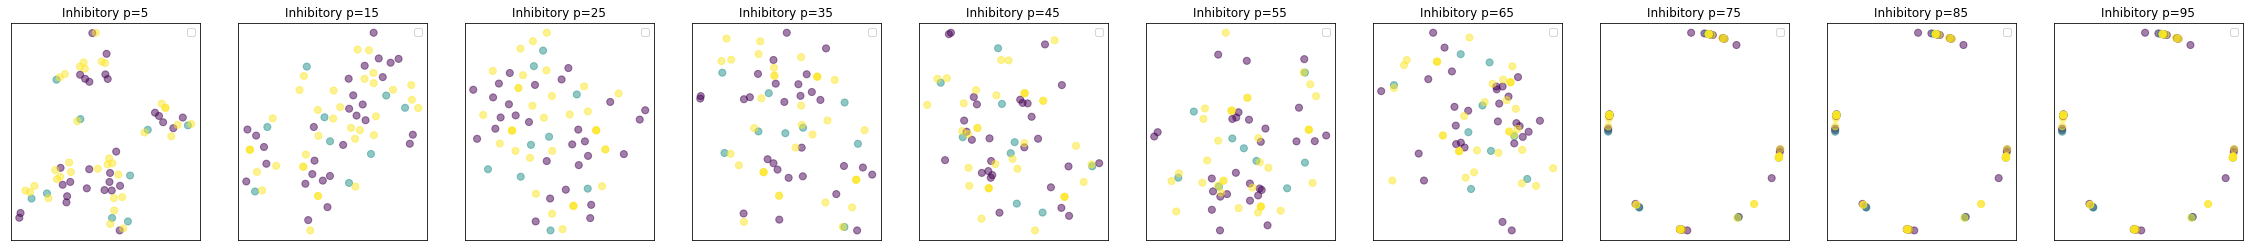

In [ ]:
data_exc_umap_scaler = StandardScaler()
data_inh_umap_scaler = StandardScaler()

data_sag_inh = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh'])))
data_sag_inh_acsf = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['inh_acsf'])))
data_dop_inh = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh'])))
data_dop_inh_acsf = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh_acsf'])))
data_all_inh = np.concatenate((data_dop_inh,data_sag_inh),axis=0)
data_inh_acsf = np.concatenate((data_dop_inh_acsf, data_sag_inh_acsf),axis=0)
data_all_cond_combined_inh = np.concatenate((data_all_inh, data_inh_acsf),axis=0)
# data_all_cond_combined_inh = normalize(data_all_cond_combined_inh)
n_components = 2

perplexity_ = np.arange(5,100,10)
fig, ax = plt.subplots(1,len(perplexity_),figsize=[40,4])
labels_inh = np.zeros(data_all_cond_combined_inh.shape[0])
lengths = [data_dop_inh.shape[0],data_sag_inh.shape[0],data_inh_acsf.shape[0]]
label_names =np.concatenate((np.concatenate((np.repeat('sag',lengths[0]),np.repeat('dop',lengths[1]))),np.repeat('acsf',lengths[2])))
for i in range(len(labels_inh)):
  if i<=lengths[0]-1:
    labels_inh[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_inh[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_inh[i] = 2

for p,j in enumerate(perplexity_):
  tsne = manifold.TSNE(
      n_components=n_components,
      init="pca",
      random_state=0,
      perplexity=j,
      learning_rate="auto",
      n_iter=1000,)

  reduced_data = tsne.fit_transform(np.array(data_all_cond_combined_inh))
              
  ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c=labels_inh, s=50, alpha=0.5,marker = 'o')
  ax[p].set_title('Inhibitory p='+str(j))
  ax[p].get_xaxis().set_visible(False)
  ax[p].get_yaxis().set_visible(False)
  ax[p].legend()
plt.show() 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA in

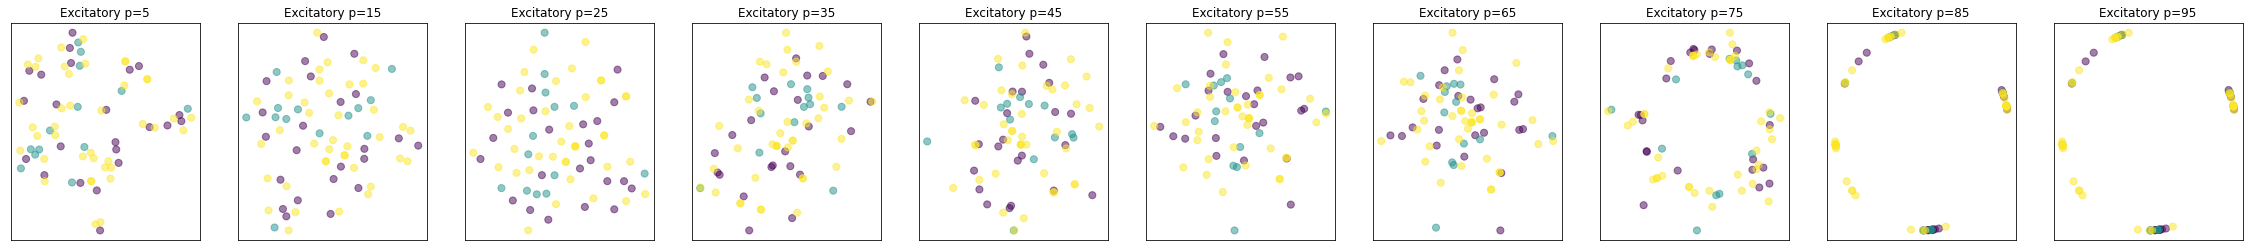

In [ ]:
scaler = StandardScaler()

data_sag_exc = scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['exc'])))
data_sag_exc_acsf = scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_sag['exc_acsf'])))
data_dop_exc = scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['exc'])))
data_dop_exc_acsf = scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['exc_acsf'])))
data_all_exc = np.concatenate((data_dop_exc,data_sag_exc),axis=0)
data_exc_acsf = np.concatenate((data_dop_exc_acsf, data_sag_exc_acsf),axis=0)
data_all_cond_combined_exc = np.concatenate((data_all_exc, data_exc_acsf),axis=0)
# data_all_cond_combined_exc = normalize(data_all_cond_combined_exc)


labels_exc = np.zeros(data_all_cond_combined_exc.shape[0])
lengths = [data_dop_exc.shape[0],data_sag_exc.shape[0],data_all_cond_combined_exc.shape[0]]
for i in range(len(labels_exc)):
  if i<=lengths[0]-1:
    labels_exc[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_exc[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_exc[i] = 2

n_components = 2

perplexity_ = np.arange(5,100,10)
fig, ax = plt.subplots(1,len(perplexity_),figsize=[40,4])
labels_exc = np.zeros(data_all_cond_combined_exc.shape[0])
lengths = [data_dop_exc.shape[0],data_sag_exc.shape[0],data_all_cond_combined_exc.shape[0]]
for i in range(len(labels_exc)):
  if i<=lengths[0]-1:
    labels_exc[i] = 0
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    labels_exc[i] = 1
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    labels_exc[i] = 2

for p,j in enumerate(perplexity_):
  tsne = manifold.TSNE(
      n_components=n_components,
      init="pca",
      random_state=0,
      perplexity=j,
      learning_rate="auto",
      n_iter=1000,)

  reduced_data = tsne.fit_transform(np.array(data_all_cond_combined_exc))
              
  ax[p].scatter(reduced_data[:,0], reduced_data[:,1], c=labels_exc, s=50, alpha=0.5,marker = 'o')
  ax[p].set_title('Excitatory p='+str(j))
  ax[p].get_xaxis().set_visible(False)
  ax[p].get_yaxis().set_visible(False)
plt.show() 

#UMAP

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ab8975993c8a08181945c0f09768df1db373cf7ac604386dc775f55f8fa75827
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=fd8d9804aeb3e9cdd6c5ac4c8425c7d735dcd1931ec20605f9a483eeb8d40599
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


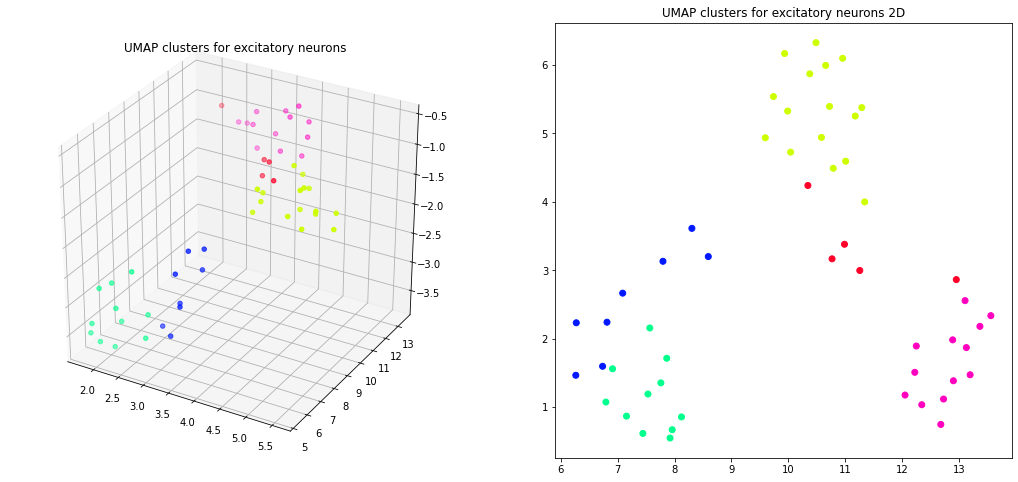

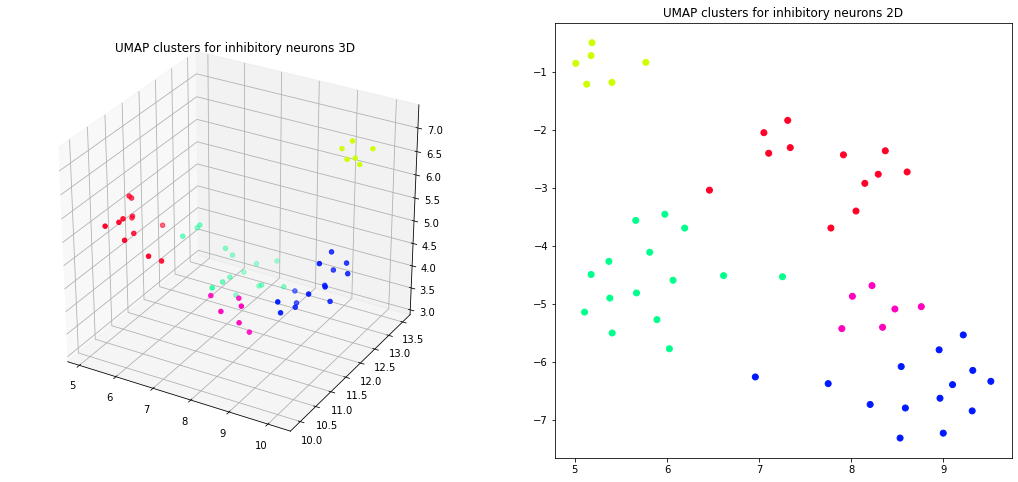

In [ ]:
#@title UMAP acsf

# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

data_exc_umap_scaler = StandardScaler()
data_exc_umap = data_exc_umap_scaler.fit_transform(data_exc['all'])
data_exc_umap = normalize(data_exc_umap)
data_inh_umap = data_exc_umap_scaler.fit_transform(data_inh['all'])
data_inh_umap = normalize(data_inh_umap)
min_size = min(data_exc_umap.shape[0],data_inh_umap.shape[0])
kmeans_labels_inh = cluster.KMeans(n_clusters=5).fit_predict(data_inh_umap[:min_size,])
kmeans_labels_exc = cluster.KMeans(n_clusters=5).fit_predict(data_exc_umap[:min_size,])
fig = plt.figure(figsize=[18,8])
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax12d = fig.add_subplot(1,2,2)

clusterable_embedding3d = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=3,
    random_state=42,
).fit_transform(data_exc_umap[:min_size,])
clusterable_embedding2d = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=2,
    random_state=42,
).fit_transform(data_exc_umap[:min_size,])

ax1.scatter(clusterable_embedding3d[:, 0], clusterable_embedding3d[:, 1], clusterable_embedding3d[:, 2], c= kmeans_labels_exc, cmap='gist_rainbow')
ax1.set_title('UMAP clusters for excitatory neurons')
ax12d.scatter(clusterable_embedding2d[:, 0], clusterable_embedding2d[:, 1], c= kmeans_labels_exc, cmap='gist_rainbow')
ax12d.set_title('UMAP clusters for excitatory neurons 2D')

plt.show()
fig = plt.figure(figsize=[18,8])
ax2 = fig.add_subplot(1,2,1,projection='3d')
ax22d = fig.add_subplot(1,2,2)

clusterable_embedding3d = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=3,
    random_state=42,
).fit_transform(data_inh_umap[:min_size,])

clusterable_embedding2d = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=2,
    random_state=42,
).fit_transform(data_inh_umap[:min_size,])

ax2.scatter(clusterable_embedding3d[:, 0], clusterable_embedding3d[:, 1], clusterable_embedding3d[:, 2],c= kmeans_labels_inh,  cmap='gist_rainbow')
ax2.set_title('UMAP clusters for inhibitory neurons 3D')
ax22d.scatter(clusterable_embedding2d[:, 0], clusterable_embedding2d[:, 1],c= kmeans_labels_inh,  cmap='gist_rainbow')
ax22d.set_title('UMAP clusters for inhibitory neurons 2D')

plt.show()

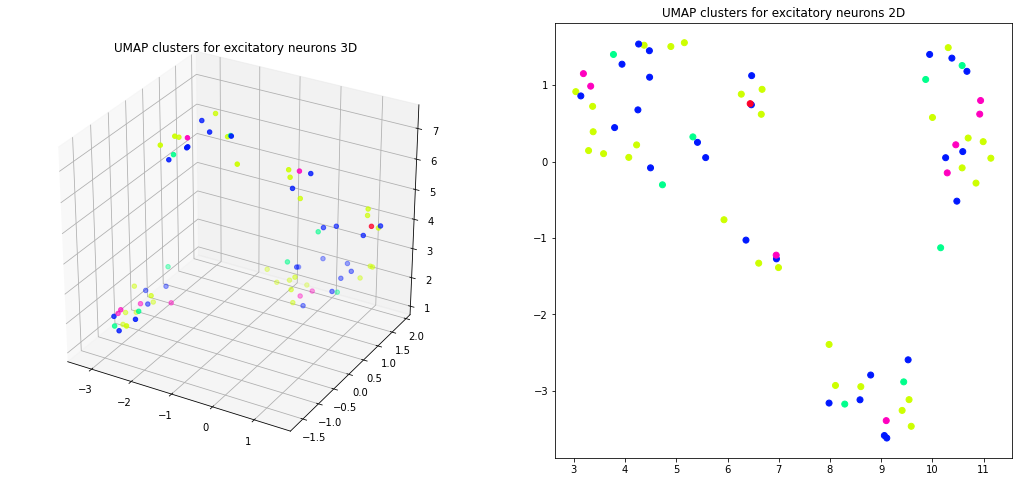

In [ ]:
#@title UMAP Dop and Serotonin combined

# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

data_exc_umap_scaler = StandardScaler()
data_exc_umap = data_exc_umap_scaler.fit_transform(data_exc['all'])



data_sag_inh = data_exc_umap_scaler.fit_transform(np.squeeze(data_sag['inh']))
data_sag_inh = normalize(data_sag_inh)

data_sag_inh_acsf = data_exc_umap_scaler.fit_transform(np.squeeze(data_sag['inh_acsf']))
data_sag_inh_acsf = normalize(data_sag_inh_acsf)

data_dop_inh = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh'])))
data_dop_inh = normalize(data_dop_inh)
data_dop_inh_acsf = data_exc_umap_scaler.fit_transform(remove_nans_and_infs(np.squeeze(data_dop['inh_acsf'])))
data_dop_inh_acsf = normalize(data_dop_inh_acsf)

data_inh_umap = np.concatenate((data_sag_inh_acsf,data_dop_inh_acsf),axis=0)
data_all_inh = np.concatenate((data_dop_inh,data_sag_inh),axis=0)
data_inh_umap = np.concatenate((data_all_inh, data_inh_umap),axis=0)
colors_inh = np.zeros(data_inh_umap.shape[0])
lengths = [data_dop_inh.shape[0],data_sag_inh.shape[0],data_dop_inh_acsf.shape[0],data_sag_inh_acsf[0].shape[0]]
labels_inh = np.concatenate((np.concatenate((np.repeat('dop_inh',lengths[0]),np.repeat('sag_inh',lengths[1]))),np.concatenate((np.repeat('dop_inh_acsf',lengths[2]),np.repeat('sag_inh_acsf',lengths[3])))))

for i in range(len(colors_inh)-1):
  if i<=lengths[0]:
    colors_inh[i] = 1
  elif i>lengths[0]-1 and i<=(lengths[0]+lengths[1])-1 :
    colors_inh[i] = 2
  elif i<=(lengths[0]+lengths[1]+lengths[2])-1 and i >(lengths[0]+lengths[1])-1:
    colors_inh[i] = 3
  elif i<=(lengths[0]+lengths[1]+lengths[2]+lengths[3])-1 and i >(lengths[0]+lengths[1]+lengths[2])-1 :
    colors_inh[i] = 4
fig = plt.figure(figsize=[18,8])
ax3d = fig.add_subplot(1,2,1,projection='3d')
ax2d = fig.add_subplot(1,2,2)
min_size = min(data_exc_umap.shape[0],data_inh_umap.shape[0])
kmeans_labels_inh = cluster.KMeans(n_clusters=5).fit_predict(data_inh_umap[:min_size,])
kmeans_labels_exc = cluster.KMeans(n_clusters=5).fit_predict(data_exc_umap[:min_size,])
clusterable_embedding2d = umap.UMAP(
                      n_neighbors=10,
                      min_dist=0.1,
                      n_components=2,
                      random_state=42,).fit_transform(data_inh_umap)
clusterable_embedding3d = umap.UMAP(
                      n_neighbors=10,
                      min_dist=0.1,
                      n_components=3,
                      random_state=42,).fit_transform(data_inh_umap)

ax2d.scatter(clusterable_embedding2d[:, 0], clusterable_embedding2d[:, 1],c= colors_inh, cmap='gist_rainbow')
ax3d.scatter(clusterable_embedding3d[:, 0], clusterable_embedding3d[:, 1],clusterable_embedding3d[:, 2],c= colors_inh, cmap='gist_rainbow')

ax2d.set_title('UMAP clusters for excitatory neurons 2D')

ax3d.set_title('UMAP clusters for excitatory neurons 3D')
# plt.legend(labels_inh,)
plt.show()



# Heirarchical clustering 

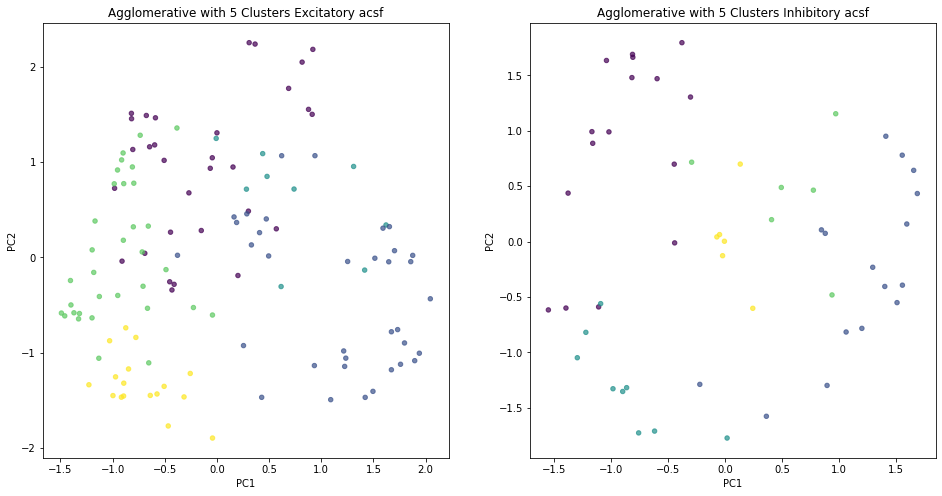

In [ ]:
#@title Heirarchical clustering with drug
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
scalar = StandardScaler()
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

data_inh_pca = scalar.fit_transform(data_inh['all'])
data_inh_pca = normalize(data_inh_pca)
data_exc_pca = scalar.fit_transform(data_exc['all'])
data_exc_pca = normalize(data_exc_pca)

pca_x = PCA(whiten=True,random_state=40)
fig, ax = plt.subplots(1,2,figsize=[16,8])

# Project the data in 2D

reduced_data_exc = pca_x.fit_transform(data_exc_pca)
pca_x.get_covariance
plt.plot()
agglom_exc = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(data_exc_pca)
labels_exc = agglom_exc.labels_

ax[0].scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c=labels_exc, s=20, alpha=0.7,marker = 'o')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('Agglomerative with 5 Clusters Excitatory acsf')

reduced_data_inh = pca_x.fit_transform(data_inh_pca)

agglom_inh = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(data_inh_pca)
labels_inh = agglom_inh.labels_

ax[1].scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c=labels_inh, s=20, alpha=0.7,marker = 'o')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Agglomerative with 5 Clusters Inhibitory acsf')

plt.show()

Exc
(23, 21)
(13, 21)
(40, 21)
Inh
(28, 21)
(9, 21)
(35, 21)


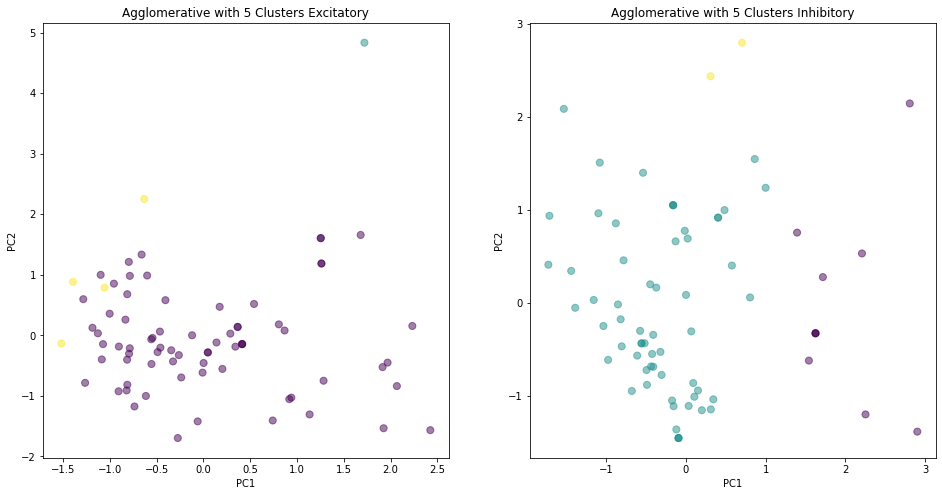

In [ ]:
#@title Heirarchical clustering with drug
from sklearn.cluster import AgglomerativeClustering 

features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

#excitatory
data_exc_scaler = StandardScaler()
data_sag_exc = remove_nans_and_infs(np.squeeze(data_sag['exc']))
data_dop_exc = remove_nans_and_infs(np.squeeze(data_dop['exc']))
data_sag_exc_acsf = remove_nans_and_infs(np.squeeze(data_sag['exc_acsf']))
data_dop_exc_acsf = remove_nans_and_infs(np.squeeze(data_dop['exc_acsf']))

data_all_exc_cond = np.concatenate((data_dop_exc,data_sag_exc),axis=0)
data_all_exc_acsf = np.concatenate((data_sag_exc_acsf, data_dop_exc_acsf),axis=0)

data_all_combined_exc = np.concatenate((data_all_exc_cond, data_all_exc_acsf),axis=0)
data_all_combined_exc= data_exc_scaler.fit_transform(data_all_combined_exc)
# data_all_combined_exc = normalize(data_all_combined_exc)
# data_all_combined_exc_scaled_normalized = normalize(data_all_combined_exc_scaled) 

print('Exc')
print(np.shape(data_dop_exc))
print(np.shape(data_sag_exc))
print(np.shape(data_all_exc_acsf))
#inhibitory
data_inh_scaler = StandardScaler()
data_sag_inh = remove_nans_and_infs(np.squeeze(data_sag['inh']))
data_dop_inh = remove_nans_and_infs(np.squeeze(data_dop['inh']))
data_sag_inh_acsf = remove_nans_and_infs(np.squeeze(data_sag['inh_acsf']))
data_dop_inh_acsf = remove_nans_and_infs(np.squeeze(data_dop['inh_acsf']))

data_all_inh_cond = np.concatenate((data_dop_inh,data_sag_inh),axis=0)
data_all_inh_acsf = np.concatenate((data_sag_inh_acsf, data_dop_inh_acsf),axis=0)
data_all_combined_inh = np.concatenate((data_all_inh_cond, data_all_inh_acsf),axis=0)
data_all_combined_inh  = data_inh_scaler.fit_transform(data_all_combined_inh)
# data_all_combined_inh = normalize(data_all_combined_inh)
# data_all_combined_inh_scaled_normalized = normalize(data_all_combined_inh_scaled) 
print('Inh')
print(np.shape(data_dop_inh))
print(np.shape(data_sag_inh))
print(np.shape(data_all_inh_acsf))

pca_x = PCA(n_components = 2, whiten=True,random_state=40)

fig, ax = plt.subplots(1,2,figsize=[16,8])

# Project the data in 2D

reduced_data_exc = pca_x.fit_transform(data_all_combined_exc)
reduced_data_inh = pca_x.fit_transform(data_all_combined_inh)

agglom_exc = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(data_all_combined_exc)
labels_exc = agglom_exc.labels_

agglom_inh = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(data_all_combined_inh)
labels_inh = agglom_inh.labels_

ax[0].scatter(reduced_data_exc[:,0], reduced_data_exc[:,1], c=labels_exc, s=50, alpha=0.5,marker = 'o')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('Agglomerative with 5 Clusters Excitatory')

ax[1].scatter(reduced_data_inh[:,0], reduced_data_inh[:,1], c=labels_inh, s=50, alpha=0.5,marker = 'o')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Agglomerative with 5 Clusters Inhibitory')

plt.show()


In [ ]:
!pip install fastcluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 11.2 MB/s eta 0:00:00


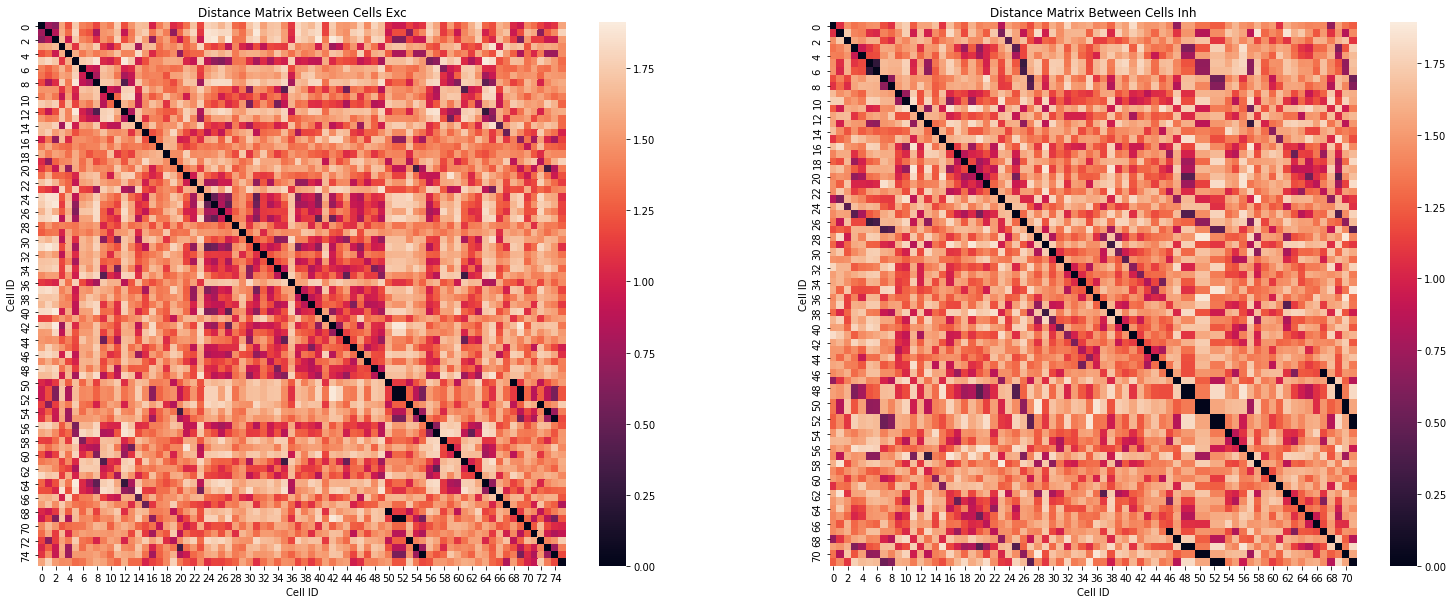

In [ ]:
#@title distance matrix for Dopamine and Serotonin
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage
scalar = StandardScaler()
fig,ax = plt.subplots(1,2,figsize=[26,10])
#load Inhibitory data
data_inh_drug = data_all_combined_inh
data_inh_drug = normalize(data_inh_drug)
#load Excitatory data
data_exc_drug = data_all_combined_exc
data_exc_drug = normalize(data_exc_drug)

#calculate Exc Distance
dist_exc_drug = distance_matrix(data_exc_drug, data_exc_drug,p=2,)
# dist_exc_drug = compute_serial_matrix(dist_exc_drug)

# sns.heatmap(dist_exc_drug[0],ax=ax[0],xticklabels=dist_exc_drug[1],yticklabels=dist_exc_drug[1])
sns.heatmap(dist_exc_drug,ax=ax[0])

ax[0].set_xlabel('Cell ID')
ax[0].set_ylabel('Cell ID')
ax[0].set_title('Distance Matrix Between Cells Exc')

#calculate Inh Distance
dist_inh_drug = distance_matrix(data_inh_drug, data_inh_drug ,p=2)
# dist_inh_drug = compute_serial_matrix(dist_inh_drug)
# sns.heatmap(dist_inh_drug[0],ax=ax[1],xticklabels=dist_inh_drug[1],yticklabels=dist_inh_drug[1])
sns.heatmap(dist_inh_drug,ax=ax[1])

ax[1].set_xlabel('Cell ID')
ax[1].set_ylabel('Cell ID')
ax[1].set_title('Distance Matrix Between Cells Inh')

plt.show()

(53, 21) (125, 21)


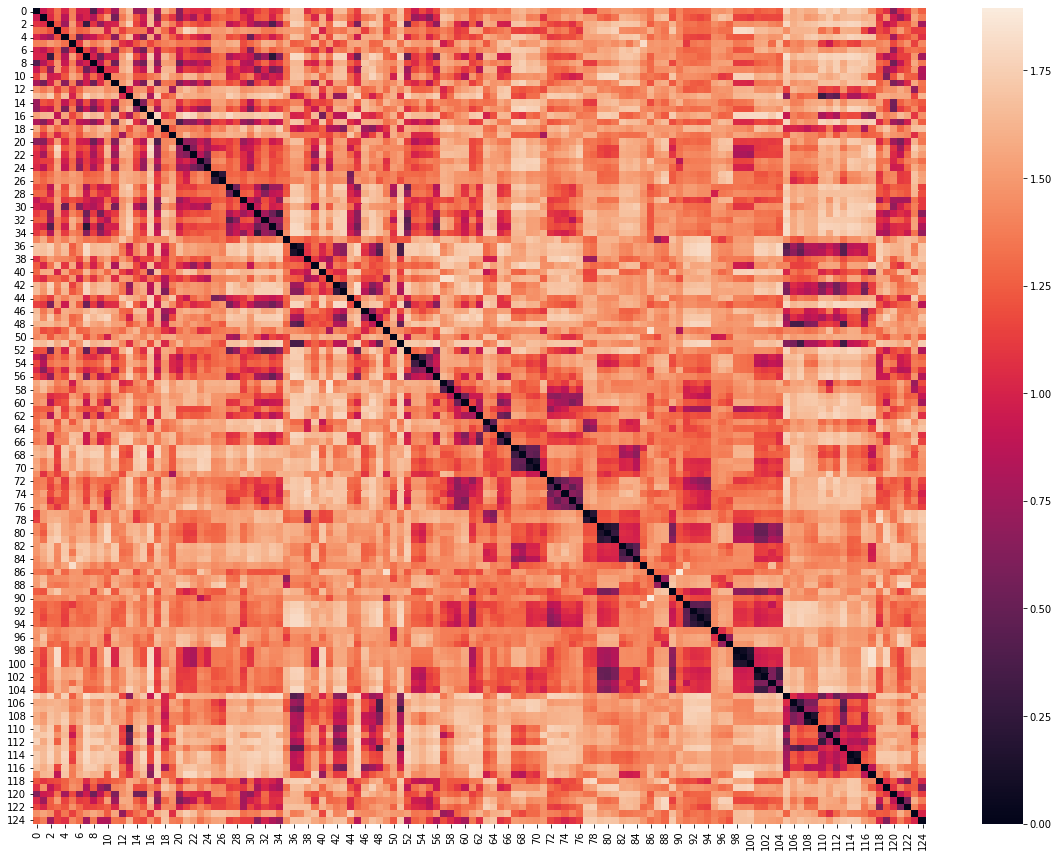

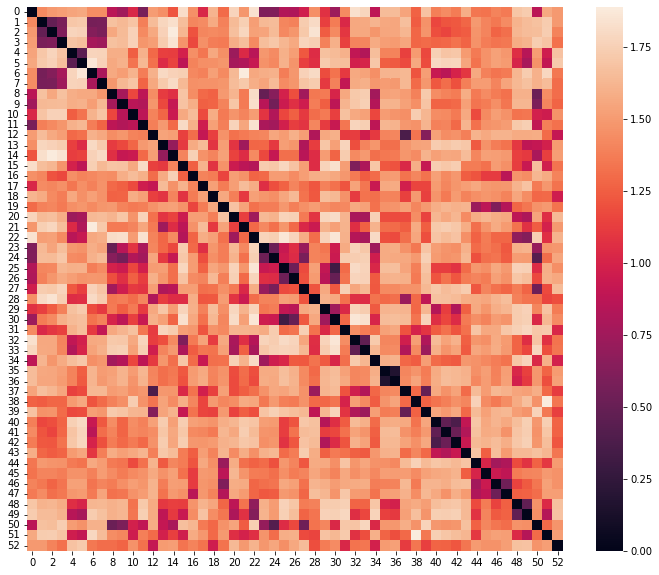

In [ ]:
#@title distance matrix for acsf data
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer


scalar = StandardScaler()
ax1 = plt.figure(figsize=[20,15]).add_subplot()

print(data_inh['all'].shape,data_exc['all'].shape)
data_inh_pca_acsf = scalar.fit_transform(data_inh['all'])
data_inh_pca_acsf = normalize(data_inh_pca_acsf)
data_exc_pca_acsf = scalar.fit_transform(data_exc['all'])
data_exc_pca_acsf = normalize(data_exc_pca_acsf)
dist_exc_acsf = distance_matrix(data_exc_pca_acsf, data_exc_pca_acsf,p=2)
# dist_exc_acsf = compute_serial_matrix(dist_exc_acsf)
# sns.heatmap(dist_exc_acsf[0],xticklabels=dist_exc_acsf[1],yticklabels=dist_exc_acsf[1],ax=ax1)
sns.heatmap(dist_exc_acsf,ax=ax1)

plt.show()
ax2 = plt.figure(figsize=[12,10]).add_subplot()
dist_inh_acsf = distance_matrix(data_inh_pca_acsf, data_inh_pca_acsf,p=2)
# dist_inh_acsf = compute_serial_matrix(dist_inh_acsf)
# sns.heatmap(dist_inh_acsf[0],xticklabels=dist_inh_acsf[1],yticklabels=dist_inh_acsf[1],ax=ax2)
sns.heatmap(dist_inh_acsf,ax=ax2)

plt.show()

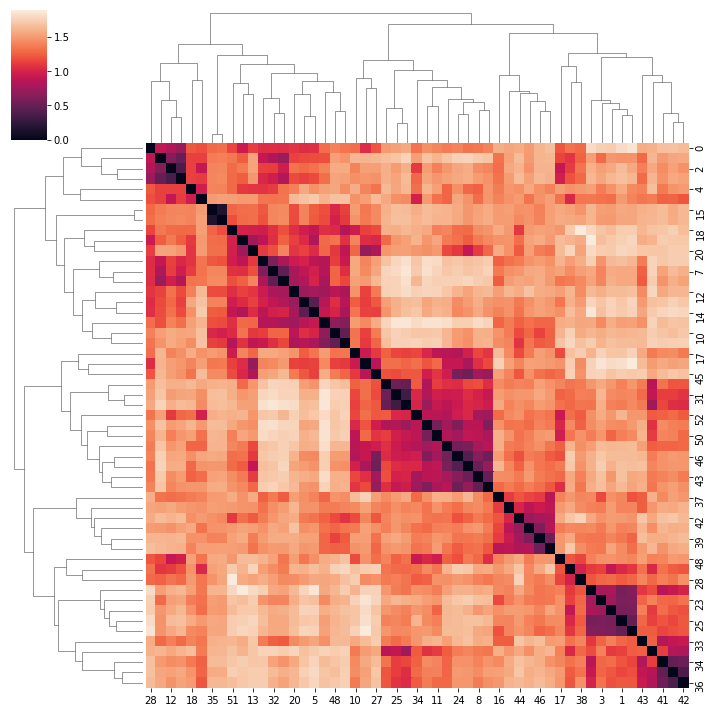

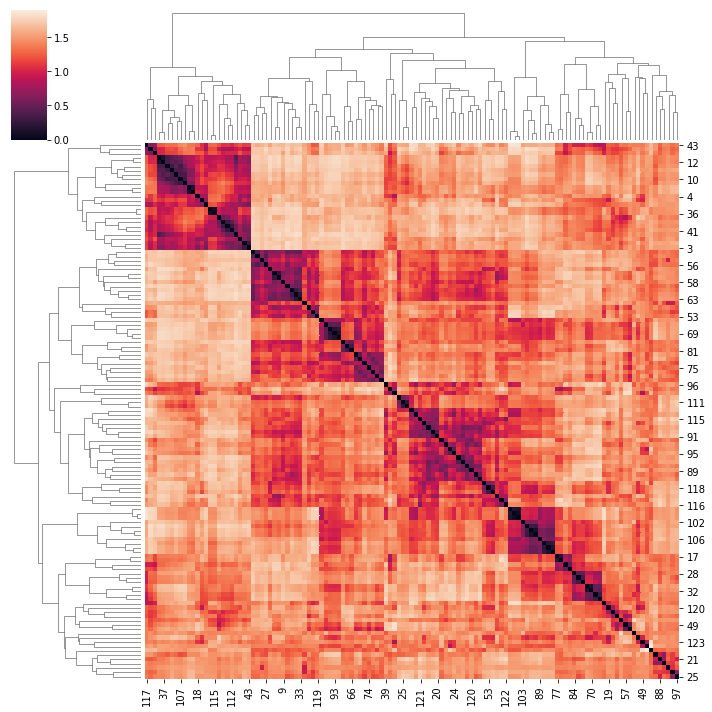

In [ ]:
data_inh_pca
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']
df_inh = pd.DataFrame(data= dist_inh_acsf[0], columns=dist_inh_acsf[1])
sns.clustermap(data=df_inh)
plt.show()
df_exc = pd.DataFrame(data= dist_exc_acsf[0], columns=dist_exc_acsf[1])
sns.clustermap(data=df_exc,)


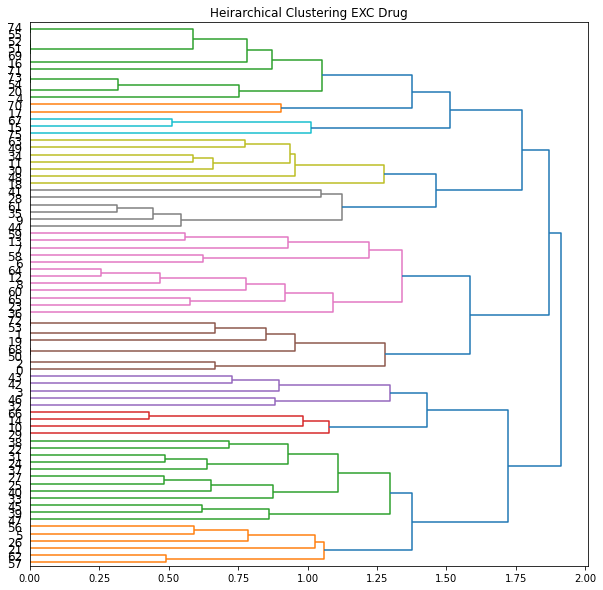

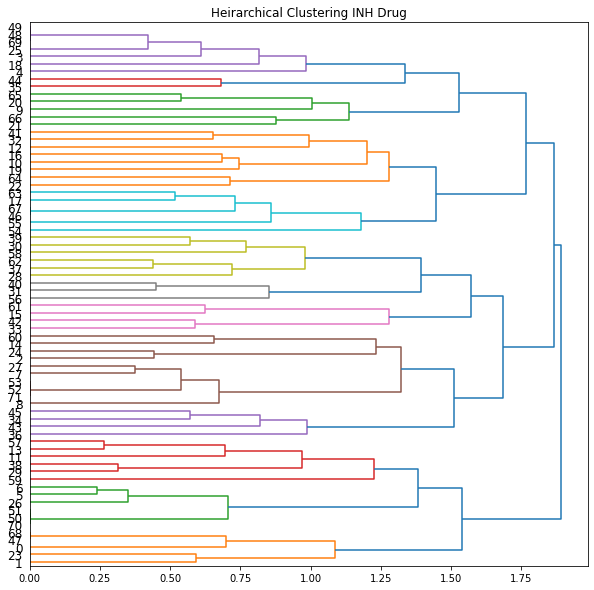

In [ ]:
#@title Dendrogram (Drug) 
Z_exc_drug = hierarchy.linkage(data_exc_drug, 'complete')
plt.figure(figsize=(10, 10))
dendro_drug = hierarchy.dendrogram(Z_exc_drug, leaf_rotation=0, leaf_font_size=12, orientation='right')
plt.title('Heirarchical Clustering EXC Drug')
plt.show()
Z_inh_drug = hierarchy.linkage(data_inh_drug, 'complete')
plt.figure(figsize=(10, 10))
dendro_drug = hierarchy.dendrogram(Z_inh_drug, leaf_rotation=0, leaf_font_size=12, orientation='right')
plt.title('Heirarchical Clustering INH Drug')
plt.show()



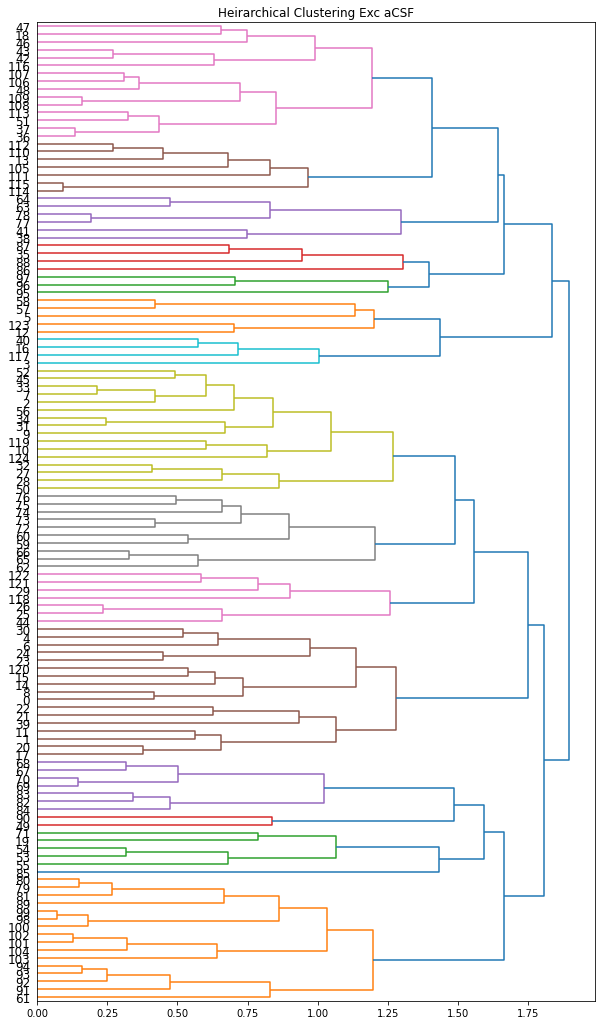

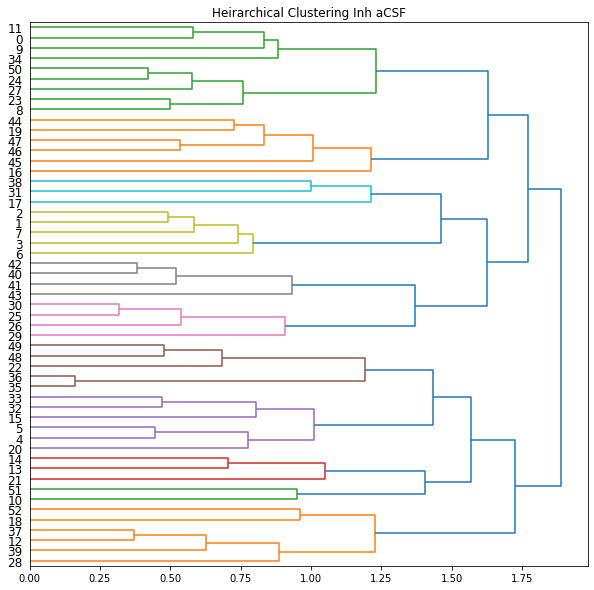

In [ ]:
#@title Dendrogram (aCSF) 

Z_exc_acsf = hierarchy.linkage(data_exc_pca_acsf, 'complete')
plt.figure(figsize=(10, 18))
dendro_acsf_exc = hierarchy.dendrogram(Z_exc_acsf, leaf_rotation=0, leaf_font_size=12, orientation='right')
plt.title('Heirarchical Clustering Exc aCSF')

plt.show()

Z_inh_acsf = hierarchy.linkage(data_inh_pca_acsf, 'complete')
plt.figure(figsize=(10, 10))
dendro_acsf_inh = hierarchy.dendrogram(Z_inh_acsf, leaf_rotation=0, leaf_font_size=12, orientation='right')
plt.title('Heirarchical Clustering Inh aCSF')

plt.show()

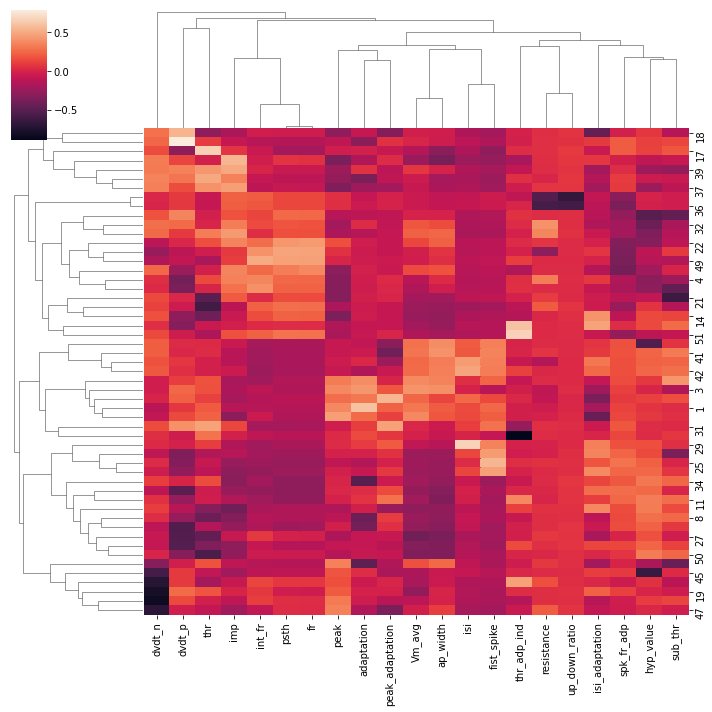

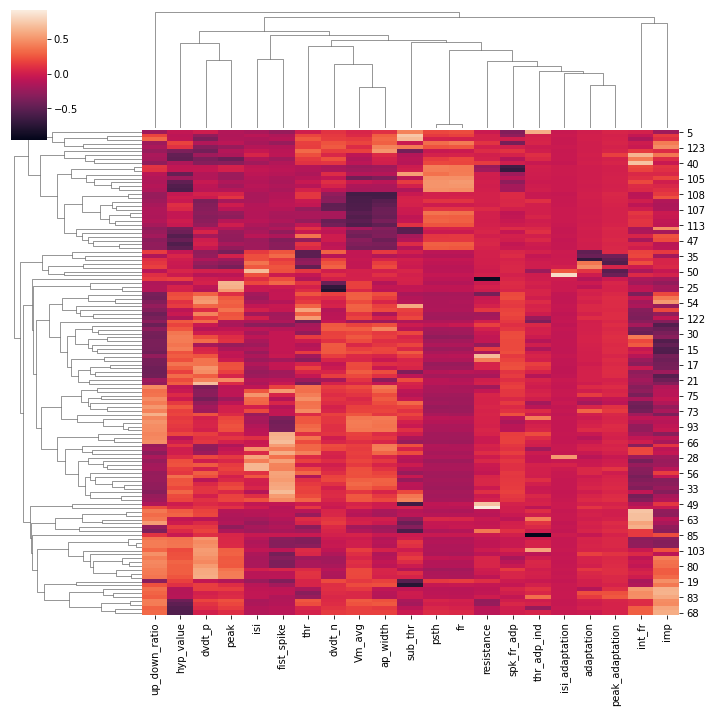

In [ ]:
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

df_inh = pd.DataFrame(data= data_inh_pca_acsf, columns=features,)
sns.clustermap(data=df_inh)
plt.show()

df_exc = pd.DataFrame(data= data_exc_pca_acsf, columns=features,)
sns.clustermap(data=df_exc)
plt.show()


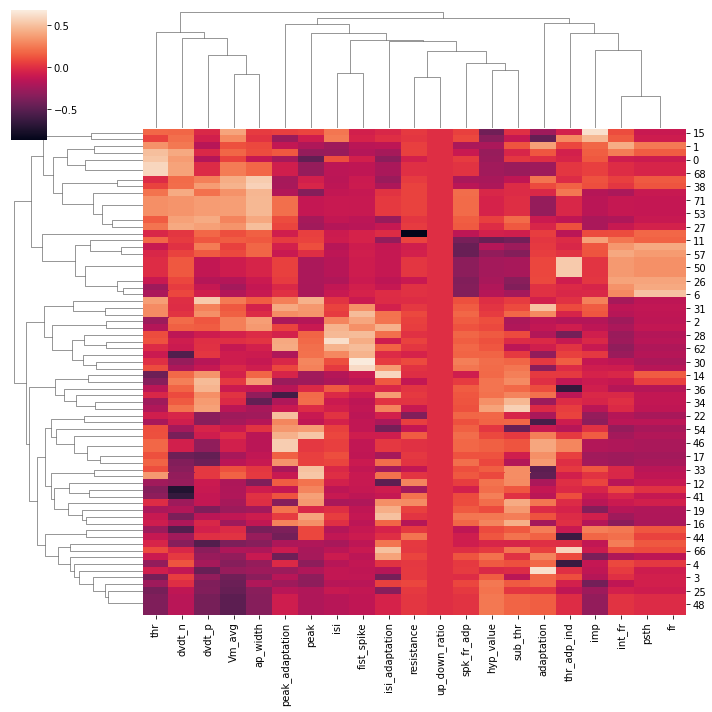

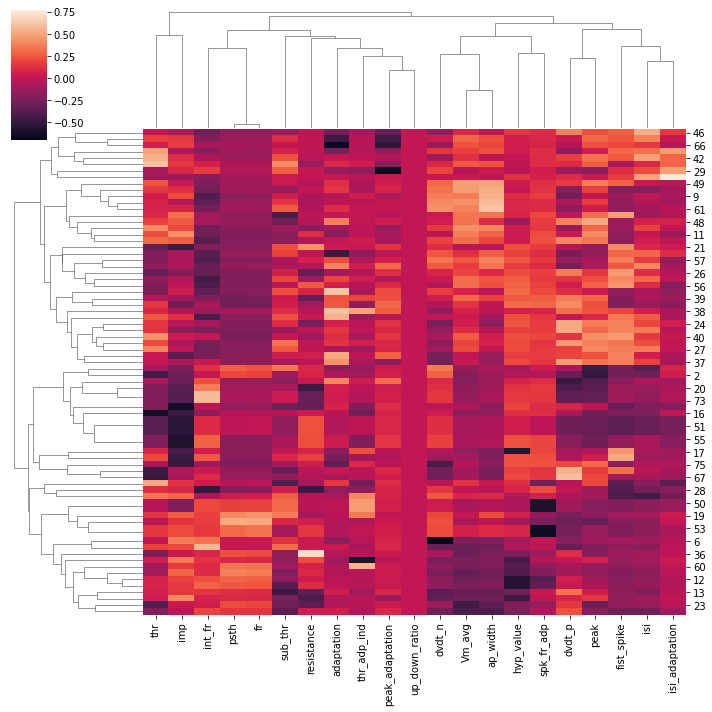

In [ ]:
features = ['Vm_avg','dvdt_p','dvdt_n','resistance','thr','adaptation',
'isi','peak','peak_adaptation','ap_width','hyp_value','fist_spike','up_down_ratio',
'isi_adaptation','thr_adp_ind','psth','int_fr','fr','sub_thr','spk_fr_adp','imp']

df_inh = pd.DataFrame(data= data_inh_drug, columns=features,)
sns.clustermap(data=df_inh)
plt.show()

df_exc = pd.DataFrame(data= data_exc_drug, columns=features,)
sns.clustermap(data=df_exc)
plt.show()
